# Proyecto de Grado

Presentado por Sofía Gutiérrez R [201612121]



<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

Se importan las librerías necesarias

In [1]:
# Librerías
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score#,max_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

#import xgboost

# Numerics
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
"Se importaron las Librerías"

'Se importaron las Librerías'

# Preprocesamiento

## Se cargan y unen los datos de SOLCAST

In [14]:
"""Esta parte solo se corre una vez, ya no es necesario correrla de nuevo"""
# Cargar datos
datos_solar_1 = pd.read_csv(os.path.join("Data","DatosSOLARCAST4.710989_-74.072092_Solcast_PT60M.csv"))
datos_solar_2 = pd.read_csv(os.path.join("Data","2020-2021Nuevos4.710989_-74.072092_Solcast_PT60M.csv"))

# Filtrar fechas
datos_solar_2 = datos_solar_2[datos_solar_2["PeriodStart"]>="2020-04-22T21:00:00Z"]

# Quitar columnas adicionales
drop_columns = list(set(datos_solar_2.columns).difference(set(datos_solar_1.columns)))
datos_solar_2.drop(columns=drop_columns, inplace=True)

# Revisar las columnas son las mismas
assert len(datos_solar_1.columns)==len(datos_solar_2.columns) and (datos_solar_1.columns==datos_solar_2.columns).all(), "Las columnas no son iguales"

datos_solar = pd.concat([datos_solar_1,datos_solar_2])

# Guardar nueva tabla
datos_solar.to_csv("datosSOLCAST_Unidos.csv", index=False)
print("El tamaño de la tabla de SOLCAST es {}.".format(datos_solar.shape))
datos_solar.head()

El tamaño de la tabla de SOLCAST es (123334, 20).


,PeriodEnd,PeriodStart,Period,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith
0,2007-01-01T02:00:00Z,2007-01-01T01:00:00Z,PT60M,17.1,0.13,116,0.0,14.0,0,0,0,0,0,0,22.5,82.2,814.6,112,1.9,126
1,2007-01-01T03:00:00Z,2007-01-01T02:00:00Z,PT60M,15.5,0.13,121,0.0,13.8,0,0,0,0,0,0,22.5,89.7,815.2,115,1.8,140
2,2007-01-01T04:00:00Z,2007-01-01T03:00:00Z,PT60M,14.6,0.13,134,0.0,13.7,0,0,0,0,0,0,22.3,94.2,815.4,119,1.8,152
3,2007-01-01T05:00:00Z,2007-01-01T04:00:00Z,PT60M,14.3,0.13,161,0.0,13.6,0,0,0,0,0,0,22.0,95.4,815.3,123,1.8,160
4,2007-01-01T06:00:00Z,2007-01-01T05:00:00Z,PT60M,14.0,0.13,-160,0.0,13.5,0,0,0,0,0,0,21.7,96.5,815.2,127,1.9,160


## Se cargan los datos de temperatura de los modulos del Enel

In [79]:
"""YA NO ES NECESARIO CORRER ESTA PARTE YA QUE SE ARREGLARON Y SE HIZO UN NUEVO ARCHIVO """
datosTempModuleEnel = pd.read_excel(os.getcwd()+"\\Data\\TEMP MODULE-2.xlsx", header=1)
datosTempModuleEnel.head()

,Time,EP1_I02_AN00037,EP1_I03_AN00037,EP1_I06_AN00037,EP1_I09_AN00037,EP1_I10_AN00037,EP1_I12_AN00037
0,2020-08-10 00:00:00,26.7546,0 FA,26.4704,25.8349,25.9908,26.1084
1,2020-08-10 00:01:00,26.8613,0 FA,26.4349,25.8349,25.9551,26.0728
2,2020-08-10 00:02:00,26.8613,0 FA,26.4349,25.7638,25.9194,26.0017
3,2020-08-10 00:03:00,26.7902,0 FA,26.3993,25.7282,25.9551,25.9662
4,2020-08-10 00:04:00,26.6835,0 FA,26.3993,25.6571,25.9551,25.9306


In [80]:
datosTempModuleEnel.iloc[0]

Time               2020-08-10 00:00:00
EP1_I02_AN00037                26.7546
EP1_I03_AN00037                  0  FA
EP1_I06_AN00037                26.4704
EP1_I09_AN00037                25.8349
EP1_I10_AN00037                25.9908
EP1_I12_AN00037                26.1084
Name: 0, dtype: object

In [81]:
datosTempModuleEnel.iloc[-1]

Time               2021-02-12 11:00:00
EP1_I02_AN00037                54.2783
EP1_I03_AN00037                55.7442
EP1_I06_AN00037                55.1613
EP1_I09_AN00037                51.2881
EP1_I10_AN00037                52.8822
EP1_I12_AN00037                53.6407
Name: 268497, dtype: object

In [121]:
# Arreglar columnas numéricas
datosTempModuleEnel = datosTempModuleEnel.replace("0  FA", np.nan)
datosTempModuleEnel = datosTempModuleEnel.replace("FA", "", regex=True)
datosTempModuleEnel = datosTempModuleEnel.replace(",", ".", regex=True)

# Se toman todas las columnas menos la del tiempo 
strip_columns = list(datosTempModuleEnel.columns)
strip_columns.remove("Time")

#Se les quita el FA
datosTempModuleEnel[strip_columns] = datosTempModuleEnel[strip_columns].astype(str).apply(lambda x: x.str.strip()).astype(float)
   
datosTempModuleEnel.head()

,Time,EP1_I02_AN00037,EP1_I03_AN00037,EP1_I06_AN00037,EP1_I09_AN00037,EP1_I10_AN00037,EP1_I12_AN00037
0,2020-08-10 00:00:00,26.754639,NaN,26.470428,25.834869,25.990753,26.108429
1,2020-08-10 00:01:00,26.861328,NaN,26.434875,25.834869,25.955109,26.072845
2,2020-08-10 00:02:00,26.861328,NaN,26.434875,25.763763,25.919434,26.001740
3,2020-08-10 00:03:00,26.790161,NaN,26.399292,25.728210,25.955109,25.966156
4,2020-08-10 00:04:00,26.683502,NaN,26.399292,25.657074,25.955109,25.930573


In [122]:
datosTempModuleEnel.isna().sum()

Time                    0
EP1_I02_AN00037        26
EP1_I03_AN00037    112838
EP1_I06_AN00037         0
EP1_I09_AN00037         0
EP1_I10_AN00037         0
EP1_I12_AN00037         0
dtype: int64

In [123]:
datosTempModuleEnel.describe()

,EP1_I02_AN00037,EP1_I03_AN00037,EP1_I06_AN00037,EP1_I09_AN00037,EP1_I10_AN00037,EP1_I12_AN00037
count,268472.000000,155660.000000,268498.000000,268498.000000,268498.000000,268498.000000
mean,31.064785,32.113355,30.908295,31.273204,31.391518,31.132948
std,10.598050,11.865350,10.898173,11.637025,11.199916,11.408818
min,0.000000,17.896942,17.000336,16.403442,17.921570,16.888733
25%,22.527863,22.719543,22.313477,22.105194,22.581933,22.236328
50%,25.439178,25.848083,25.190186,24.910522,25.598724,25.077271
75%,39.935059,41.874084,39.152283,40.842194,39.881348,40.044922
max,66.200348,63.163940,62.390869,64.972565,64.933594,64.986603


In [85]:
datosTempModuleEnel['Time'].min()

Timestamp('2020-08-10 00:00:00')

In [86]:
fechasEnel = pd.date_range(start = datosTempModuleEnel['Time'].min(), end = datosTempModuleEnel['Time'].max(), freq="H" )
fechasEnel

DatetimeIndex(['2020-08-10 00:00:00', '2020-08-10 01:00:00',
               '2020-08-10 02:00:00', '2020-08-10 03:00:00',
               '2020-08-10 04:00:00', '2020-08-10 05:00:00',
               '2020-08-10 06:00:00', '2020-08-10 07:00:00',
               '2020-08-10 08:00:00', '2020-08-10 09:00:00',
               ...
               '2021-02-12 02:00:00', '2021-02-12 03:00:00',
               '2021-02-12 04:00:00', '2021-02-12 05:00:00',
               '2021-02-12 06:00:00', '2021-02-12 07:00:00',
               '2021-02-12 08:00:00', '2021-02-12 09:00:00',
               '2021-02-12 10:00:00', '2021-02-12 11:00:00'],
              dtype='datetime64[ns]', length=4476, freq='H')

### Se promedian los datos para tener frecuencia horaria

In [105]:
""" Esta parte ya no es necesaria correrla otra vez, ya que se realizó un nuevo archivo"""
""" Ya que los datos vienen con frecuencia en minutos es necesario promediarlos a horaria"""
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
nuevo = datosTempModuleEnel.iloc[0:59]#.dropna().select_dtypes(include=numerics).mean(axis=0)
nuevo

,Time,EP1_I02_AN00037,EP1_I03_AN00037,EP1_I06_AN00037,EP1_I09_AN00037,EP1_I10_AN00037,EP1_I12_AN00037
0,2020-08-10 00:00:00,26.754639,NaN,26.470428,25.834869,25.990753,26.108429
1,2020-08-10 00:01:00,26.861328,NaN,26.434875,25.834869,25.955109,26.072845
2,2020-08-10 00:02:00,26.861328,NaN,26.434875,25.763763,25.919434,26.001740
3,2020-08-10 00:03:00,26.790161,NaN,26.399292,25.728210,25.955109,25.966156
4,2020-08-10 00:04:00,26.683502,NaN,26.399292,25.657074,25.955109,25.930573
5,2020-08-10 00:05:00,26.612366,NaN,26.399292,25.621521,25.919434,25.930573
6,2020-08-10 00:06:00,26.541229,NaN,26.363739,25.550415,25.883820,25.930573
7,2020-08-10 00:07:00,26.541229,NaN,26.363739,25.621521,25.848175,25.930573
8,2020-08-10 00:08:00,26.470123,NaN,26.328125,25.657074,25.812561,25.930573
9,2020-08-10 00:09:00,26.398987,NaN,26.292572,25.657074,25.812561,25.895020


In [106]:
# Se prueba para una sola columna
datosTempModuleEnel['EP1_I06_AN00037'].iloc[0:59].mean()

26.024294118644086

In [118]:
"""Sacar el promedio con o group by o un for de modulo 60"""

#En este caso se hace con un for para la columna seleccionada
test = datosTempModuleEnel[:]
nuevo = [test['EP1_I06_AN00037'].iloc[0:59].mean()]

for i in range(1,len(test)-1,60):
    #nuevo[i%60] = datosTempModuleEnel[i:i+59].mean()
    temp = test['EP1_I06_AN00037'].iloc[i:i+59].mean()
    #print(i, temp)
    """print(i)
    print(i+59)
    print(temp)"""    
    nuevo.append(temp)
    

In [111]:
rango = range(1,len(datosTempModuleEnel)-1,60)

In [124]:
print(nuevo)

[26.024294118644086, 26.01645628813561, 25.772922813559337, 25.43843866101694, 24.569222305084747, 23.933320135593224, 22.547441999999997, 29.284681457627112, 34.51012354237288, 34.537906915254226, 37.181379423728806, 41.32254491525425, 45.754950118644075, 50.95107259322033, 54.46724428813559, 53.98230447457627, 43.98440715254237, 43.70947476271186, 33.79393501694915, 28.71972916949153, 26.571815050847462, 25.361956067796616, 24.39207577966102, 24.501084728813556, 23.44695067796609, 22.78624774576271, 22.68397659322034, 22.717075322033907, 22.13187481355933, 22.37121023728814, 22.229291559322025, 23.458008423728813, 31.26405357627118, 34.96787430508474, 36.54163637288136, 31.17443908474577, 35.38982644067798, 44.93545123728815, 40.89556830508476, 44.57866350847456, 37.37591662711864, 33.324945983050846, 30.74019201694916, 26.486882, 25.726550118644074, 25.949540576271207, 24.70475698305086, 23.111137355932215, 23.17983449152543, 24.7144372881356, 22.511981542372872, 21.995383576271188,

In [119]:
len(nuevo)

4476

In [112]:
len(rango)

4475

In [115]:
type(datosTempModuleEnel['Time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [125]:
test['Time2'] = datosTempModuleEnel['Time'].apply(lambda x: x.replace(minute=0, second=0))

In [126]:
test.dtypes

Time               datetime64[ns]
EP1_I02_AN00037           float64
EP1_I03_AN00037           float64
EP1_I06_AN00037           float64
EP1_I09_AN00037           float64
EP1_I10_AN00037           float64
EP1_I12_AN00037           float64
Time2              datetime64[ns]
dtype: object

In [130]:
test[['Time2','EP1_I06_AN00037']].groupby('Time2')

In [131]:
b = test[['Time2','EP1_I06_AN00037']].groupby('Time2').mean()

In [132]:
b

,EP1_I06_AN00037
Time2,
2020-08-10 00:00:00,26.024022
2020-08-10 01:00:00,25.776248
2020-08-10 02:00:00,25.440227
2020-08-10 03:00:00,24.582534
2020-08-10 04:00:00,23.937092
2020-08-10 05:00:00,22.556556
2020-08-10 06:00:00,29.182691
2020-08-10 07:00:00,34.500356
2020-08-10 08:00:00,34.534827


In [139]:
datosTempModuleEnel.columns

Index(['Time', 'EP1_I02_AN00037', 'EP1_I03_AN00037', 'EP1_I06_AN00037',
       'EP1_I09_AN00037', 'EP1_I10_AN00037', 'EP1_I12_AN00037'],
      dtype='object')

In [140]:
 # Se toman todas las columnas menos la del tiempo 
columnasEnel = list(datosTempModuleEnel.columns)
columnasEnel.remove("Time")
columnasEnel.append("Time2")
#
#datosTempModuleEnel[[columnasEnel]].groupby('Time2').mean()

In [141]:
columnasEnel

['EP1_I02_AN00037',
 'EP1_I03_AN00037',
 'EP1_I06_AN00037',
 'EP1_I09_AN00037',
 'EP1_I10_AN00037',
 'EP1_I12_AN00037',
 'Time2']

In [142]:
test.groupby('Time2').mean()

,EP1_I02_AN00037,EP1_I03_AN00037,EP1_I06_AN00037,EP1_I09_AN00037,EP1_I10_AN00037,EP1_I12_AN00037
Time2,,,,,,
2020-08-10 00:00:00,26.402557,NaN,26.024022,25.364945,25.654569,25.663890
2020-08-10 01:00:00,26.221804,NaN,25.776248,25.156976,25.560735,25.347426
2020-08-10 02:00:00,25.880495,NaN,25.440227,24.680711,25.172427,24.860468
2020-08-10 03:00:00,24.867285,NaN,24.582534,23.988564,24.203915,23.852758
2020-08-10 04:00:00,24.188298,NaN,23.937092,23.412628,23.653960,23.449658
2020-08-10 05:00:00,22.474085,NaN,22.556556,22.025987,22.741996,22.008723
2020-08-10 06:00:00,26.183792,NaN,29.182691,26.789213,28.162852,25.416027
2020-08-10 07:00:00,33.977649,NaN,34.500356,40.153322,41.806496,32.747846
2020-08-10 08:00:00,40.859219,NaN,34.534827,47.802817,47.888587,40.491469


In [143]:
datosEnelPromediados = test.groupby('Time2').mean()
datosEnelPromediados.describe()

In [145]:
list(datosEnelPromediados)

['EP1_I02_AN00037',
 'EP1_I03_AN00037',
 'EP1_I06_AN00037',
 'EP1_I09_AN00037',
 'EP1_I10_AN00037',
 'EP1_I12_AN00037']

In [150]:
datosEnelPromediados.index

DatetimeIndex(['2020-08-10 00:00:00', '2020-08-10 01:00:00',
               '2020-08-10 02:00:00', '2020-08-10 03:00:00',
               '2020-08-10 04:00:00', '2020-08-10 05:00:00',
               '2020-08-10 06:00:00', '2020-08-10 07:00:00',
               '2020-08-10 08:00:00', '2020-08-10 09:00:00',
               ...
               '2021-02-12 02:00:00', '2021-02-12 03:00:00',
               '2021-02-12 04:00:00', '2021-02-12 05:00:00',
               '2021-02-12 06:00:00', '2021-02-12 07:00:00',
               '2021-02-12 08:00:00', '2021-02-12 09:00:00',
               '2021-02-12 10:00:00', '2021-02-12 11:00:00'],
              dtype='datetime64[ns]', name='Time2', length=4476, freq=None)

In [151]:
datosEnelPromediados['Time'] = datosEnelPromediados.index
datosEnelPromediados.head()

,EP1_I02_AN00037,EP1_I03_AN00037,EP1_I06_AN00037,EP1_I09_AN00037,EP1_I10_AN00037,EP1_I12_AN00037,Time
Time2,,,,,,,
2020-08-10 00:00:00,26.402557,NaN,26.024022,25.364945,25.654569,25.663890,2020-08-10 00:00:00
2020-08-10 01:00:00,26.221804,NaN,25.776248,25.156976,25.560735,25.347426,2020-08-10 01:00:00
2020-08-10 02:00:00,25.880495,NaN,25.440227,24.680711,25.172427,24.860468,2020-08-10 02:00:00
2020-08-10 03:00:00,24.867285,NaN,24.582534,23.988564,24.203915,23.852758,2020-08-10 03:00:00
2020-08-10 04:00:00,24.188298,NaN,23.937092,23.412628,23.653960,23.449658,2020-08-10 04:00:00


In [152]:
datosEnelPromediados.to_csv('datosEnelPromediados.csv')
"Se guardaron los datos en un nuevo archivo"

'Se guardaron los datos en un nuevo archivo'

# Se cargan los datos

## Todos los datos del SD, nuevo archivo

In [2]:
ruta = os.path.join("Data","")
print(ruta+'UNIANDES_SD_2021-02-01.xlsx')

Data\UNIANDES_SD_2021-02-01.xlsx


In [3]:
# Se cargan los datos
datosSD = pd.read_excel(ruta+"UNIANDES_SD_2021-02-01.xlsx")
# Marcar Vacíos
datosSD = datosSD.replace("--", np.nan)
datosSDconFecha = datosSD.set_index('Date & Time')
datosSD.head()

,Date & Time,Date,Time,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
0,2019-05-07 16:00:00,2019-05-07,16:00:00,21.2,21.3,21.2,47.0,9.5,12.2,0.9,...,0.0,NaN,NaN,NaN,0.00,1.6,0.69,1.6,0.000,0.217
1,2019-05-07 17:00:00,2019-05-07,17:00:00,19.4,23.0,19.4,52.0,9.3,11.8,0.4,...,0.0,59.0,5.08,162.0,0.05,0.4,0.17,1.6,0.000,0.083
2,2019-05-07 18:00:00,2019-05-07,18:00:00,17.4,19.5,17.4,60.0,9.6,11.7,1.3,...,0.0,47.0,4.04,97.0,0.05,0.0,0.00,0.5,0.067,0.000
3,2019-05-07 19:00:00,2019-05-07,19:00:00,16.4,17.4,16.3,64.0,9.6,11.5,2.2,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.142,0.000
4,2019-05-07 20:00:00,2019-05-07,20:00:00,16.3,16.6,16.1,67.0,10.2,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.150,0.000


In [4]:
datosSD.describe()

,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,Viento Corriente - m,Alta velocidad del viento - m/s,Viento Frío - °C,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
count,15003.000000,15057.000000,15057.000000,15003.000000,15003.000000,15003.000000,15057.000000,15057.000000,15253.000000,15003.000000,...,15253.000000,15050.000000,15050.000000,15028.000000,15253.000000,15053.000000,15053.000000,15023.000000,15003.000000,15003.000000
mean,14.207199,14.759713,13.677565,74.264214,9.486469,10.870759,1.589075,1.604237,5.095575,13.987776,...,0.667987,143.366711,12.335872,256.668153,0.110925,1.322075,0.566587,2.208380,0.196560,0.003631
std,2.636047,2.709943,2.524418,11.127351,1.801792,1.621114,1.002065,0.994587,2.534429,2.830766,...,6.225197,221.162289,19.029579,369.557770,0.141728,2.254743,0.966318,3.540358,0.127587,0.016996
min,6.100000,7.400000,5.900000,21.000000,-6.100000,-0.700000,0.000000,0.000000,0.000000,3.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.300000,12.800000,11.800000,67.000000,8.600000,10.000000,0.900000,0.890000,3.100000,12.100000,...,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.100000,0.000000
50%,13.800000,14.300000,13.300000,76.000000,9.600000,11.000000,1.300000,1.340000,4.900000,13.700000,...,0.000000,2.000000,0.170000,16.000000,0.030000,0.000000,0.000000,0.000000,0.199000,0.000000
75%,16.100000,16.800000,15.500000,83.000000,10.600000,11.900000,2.200000,2.240000,6.700000,15.900000,...,0.000000,241.000000,20.740000,432.000000,0.180000,2.000000,0.860000,3.500000,0.271000,0.000000
max,24.100000,24.600000,22.400000,95.000000,14.500000,15.700000,8.500000,8.490000,19.200000,24.100000,...,235.200000,1151.000000,99.040000,1517.000000,0.760000,11.900000,5.100000,16.000000,0.808000,0.238000


In [5]:
datosSD.min()

Date & Time                        2019-05-07 16:00:00
Date                               2019-05-07 00:00:00
Time                                          00:00:00
Alta velocidad del viento - m/s                      0
Barómetro - mm Hg                                551.3
Lluvia - mm                                          0
Tasa de lluvia - mm/h                                0
ET - mm                                              0
dtype: object

In [7]:
datosSD.max()

Date & Time                        2021-02-01 09:00:00
Date                               2021-02-01 00:00:00
Time                                          23:00:00
Alta velocidad del viento - m/s                   19.2
Barómetro - mm Hg                                564.4
Lluvia - mm                                       30.6
Tasa de lluvia - mm/h                            235.2
ET - mm                                           0.76
dtype: object

In [5]:
#datosSD = datosSD.reset_index(drop=True)
# Cantidad de vacíos
datosSD.isna().sum()

Date & Time                          0
Date                                 0
Time                                 0
Temp - °C                          250
Temp. Alta - °C                    196
Temp. Baja - °C                    196
Hum - %                            250
Punto de rocío - °C                250
Wet Bulb - °C                      250
Velocidad del viento - m/s         196
Dirección del viento               307
Viento Corriente - m               196
Alta velocidad del viento - m/s      0
Alta Dirección del viento          197
Viento Frío - °C                   250
Índice de calor - °C               250
THW Index - °C                     250
THSW  índice - °C                  251
Barómetro - mm Hg                    0
Lluvia - mm                          0
Tasa de lluvia - mm/h                0
Rad Solar - W/m^2                  203
Energía solar                      203
Rad Solar Alta - W/m^2             225
ET - mm                              0
El índice UV - Index     

In [59]:
# Cantidad de datos totales
datosSD.shape

(15253, 30)

In [10]:
datosSD["Temp - °C"].isna().sum() == 0

False

In [11]:
datosSD["Temp - °C"].isna().sum()

250

In [12]:
datosSD["Velocidad del viento - m/s"].isna().sum()

196

In [13]:
datosSD["Rad Solar - W/m^2"].isna().sum()

203

Faltan 250 temperaturas, 203 irradiancias y 196 velocidades de viento, se tienen desde 2019-05-07 16:00:00 a 2021-02-01 09:00:00, casi 1 año y 9 meses

## Se cargan los datos previamente unidos (SOLCAST)


In [5]:
datos_solar =  pd.read_csv("datosSOLCAST_Unidos.csv")
datos_solar.describe()

,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith
count,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000
mean,16.490122,0.125194,-0.150737,41.219229,13.910538,125.877317,112.551794,75.497251,201.377852,195.636361,226.108932,25.987851,86.019176,805.436811,134.665899,1.499023,89.963911
std,2.865403,0.005043,96.012780,27.319541,2.269917,167.664278,228.060272,168.530507,273.401148,263.397997,299.800713,4.089952,13.364029,24.324412,73.778456,0.629107,47.166742
min,5.300000,0.120000,-174.000000,0.000000,-5.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000,24.000000,734.200000,0.000000,0.000000,6.000000
25%,14.600000,0.120000,-89.000000,17.600000,13.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.600000,79.300000,812.800000,101.000000,1.100000,48.250000
50%,16.500000,0.130000,-14.000000,43.700000,14.400000,7.000000,0.000000,0.000000,9.000000,9.000000,8.000000,26.600000,90.300000,814.200000,124.000000,1.500000,89.000000
75%,18.500000,0.130000,89.000000,63.400000,15.300000,233.000000,95.000000,45.000000,374.000000,369.000000,441.000000,28.900000,96.700000,815.200000,140.000000,1.900000,133.000000
max,25.500000,0.140000,170.000000,100.000000,19.300000,726.000000,1118.000000,1037.000000,1129.000000,1092.000000,1119.000000,38.600000,100.000000,819.500000,360.000000,8.400000,175.000000


In [15]:
datos_solar.isna().sum()

PeriodEnd            0
PeriodStart          0
Period               0
AirTemp              0
AlbedoDaily          0
Azimuth              0
CloudOpacity         0
DewpointTemp         0
Dhi                  0
Dni                  0
Ebh                  0
Ghi                  0
GtiFixedTilt         0
GtiTracking          0
PrecipitableWater    0
RelativeHumidity     0
SurfacePressure      0
WindDirection10m     0
WindSpeed10m         0
Zenith               0
dtype: int64

No hay huecos en datos Solar

In [10]:
datos_solar.loc[0]

PeriodEnd            2007-01-01T02:00:00Z
PeriodStart          2007-01-01T01:00:00Z
Period                              PT60M
AirTemp                              17.1
AlbedoDaily                          0.13
Azimuth                               116
CloudOpacity                            0
DewpointTemp                           14
Dhi                                     0
Dni                                     0
Ebh                                     0
Ghi                                     0
GtiFixedTilt                            0
GtiTracking                             0
PrecipitableWater                    22.5
RelativeHumidity                     82.2
SurfacePressure                     814.6
WindDirection10m                      112
WindSpeed10m                          1.9
Zenith                                126
Name: 0, dtype: object

In [67]:
datos_solar.iloc[-1]

PeriodEnd            2021-01-25T22:00:00Z
PeriodStart          2021-01-25T21:00:00Z
Period                              PT60M
AirTemp                              15.9
AlbedoDaily                          0.13
Azimuth                               113
CloudOpacity                         27.2
DewpointTemp                          9.8
Dhi                                   199
Dni                                   203
Ebh                                    68
Ghi                                   267
GtiFixedTilt                          275
GtiTracking                           407
PrecipitableWater                    18.5
RelativeHumidity                     67.1
SurfacePressure                     735.2
WindDirection10m                      156
WindSpeed10m                          1.7
Zenith                                 69
Date & Time           2021-01-25 16:00:00
Name: 123333, dtype: object

Los datos de Solar se tiene: 2007-01-01T01:00:00Z - 2021-01-25T22:00:00Z

In [6]:
# Se arregla la zona horaria de los datos
datos_solar['Date & Time'] = (pd.to_datetime(datos_solar['PeriodStart']) - \
                              pd.Timedelta(hours=5)).dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')
datos_solar['Date & Time']

0        2006-12-31 20:00:00
1        2006-12-31 21:00:00
2        2006-12-31 22:00:00
3        2006-12-31 23:00:00
4        2007-01-01 00:00:00
5        2007-01-01 01:00:00
6        2007-01-01 02:00:00
7        2007-01-01 03:00:00
8        2007-01-01 04:00:00
9        2007-01-01 05:00:00
10       2007-01-01 06:00:00
11       2007-01-01 07:00:00
12       2007-01-01 08:00:00
13       2007-01-01 09:00:00
14       2007-01-01 10:00:00
15       2007-01-01 11:00:00
16       2007-01-01 12:00:00
17       2007-01-01 13:00:00
18       2007-01-01 14:00:00
19       2007-01-01 15:00:00
20       2007-01-01 16:00:00
21       2007-01-01 17:00:00
22       2007-01-01 18:00:00
23       2007-01-01 19:00:00
24       2007-01-01 20:00:00
25       2007-01-01 21:00:00
26       2007-01-01 22:00:00
27       2007-01-01 23:00:00
28       2007-01-02 00:00:00
29       2007-01-02 01:00:00
                 ...        
123304   2021-01-24 11:00:00
123305   2021-01-24 12:00:00
123306   2021-01-24 13:00:00
123307   2021-

In [7]:
datos_solar.head()

,PeriodEnd,PeriodStart,Period,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,...,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,Date & Time
0,2007-01-01T02:00:00Z,2007-01-01T01:00:00Z,PT60M,17.1,0.13,116,0.0,14.0,0,0,...,0,0,0,22.5,82.2,814.6,112,1.9,126,2006-12-31 20:00:00
1,2007-01-01T03:00:00Z,2007-01-01T02:00:00Z,PT60M,15.5,0.13,121,0.0,13.8,0,0,...,0,0,0,22.5,89.7,815.2,115,1.8,140,2006-12-31 21:00:00
2,2007-01-01T04:00:00Z,2007-01-01T03:00:00Z,PT60M,14.6,0.13,134,0.0,13.7,0,0,...,0,0,0,22.3,94.2,815.4,119,1.8,152,2006-12-31 22:00:00
3,2007-01-01T05:00:00Z,2007-01-01T04:00:00Z,PT60M,14.3,0.13,161,0.0,13.6,0,0,...,0,0,0,22.0,95.4,815.3,123,1.8,160,2006-12-31 23:00:00
4,2007-01-01T06:00:00Z,2007-01-01T05:00:00Z,PT60M,14.0,0.13,-160,0.0,13.5,0,0,...,0,0,0,21.7,96.5,815.2,127,1.9,160,2007-01-01 00:00:00


## Se cargan los datos de Temperatura de las celdas fotovoltaicas del SD

In [8]:
datosTempSD = pd.read_csv('Temp_SD_2019_01_01_2021_04_28.csv', sep=";")#,error_bad_lines=False)
datosTempSD.columns = ["Time", "Tc", "Ta"]
datosTempSD["Tc"] = datosTempSD["Tc"].str.replace(",",".").astype(float)
datosTempSD["Ta"] = datosTempSD["Ta"].str.replace(",",".").astype(float)

datosTempSD = datosTempSD[(~datosTempSD["Tc"].isna())].reset_index(drop=True)

datosTempSD.head()

,Time,Tc,Ta
0,2019-10-01 00:00:00,10.274,NaN
1,2019-10-01 01:00:00,10.394,NaN
2,2019-10-01 02:00:00,9.590,NaN
3,2019-10-01 03:00:00,9.431,NaN
4,2019-10-01 04:00:00,10.331,NaN


In [10]:
datosTempSD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13809 entries, 0 to 13808
Data columns (total 3 columns):
Time    13809 non-null object
Tc      13809 non-null float64
Ta      11601 non-null float64
dtypes: float64(2), object(1)
memory usage: 323.7+ KB


In [69]:
datosTempSD.shape

(13809, 3)

In [70]:
datosTempSD.loc[8758]["Tc"]

10.67

In [73]:
datosTempSD.iloc[-1]

Time    2021-04-28 08:00:00
Tc                   20.655
Ta                    32.47
Name: 13808, dtype: object

In [74]:
datosTempSD['Tc'].isna().sum()

0

In [75]:
datosTempSD['Ta'].isna().sum()

2208

## Se cargan datos Enel

In [9]:
# Datos ENEL
ruta = os.getcwd()+"\\Data\\Datos_ENEL_TemperaturaSD\\METEO\\"
datosEnelMeteo = pd.read_csv(ruta+'meteost.csv')
datosEnelMeteo.head()

,FECHA,Ambient Temp [°C],Pressure [hPa],Humidity [%],Wind Direction,Wind Speed [m/s],Radiance 1 [w/m2],Radiance 2 [w/m2],Horizontal Rad [w/m2],Diffuse Rad [w/m2],Rain [mm]
0,2020-04-01 00:00:00,24.895508,1001.746887,94.090454,80.522446,0.315409,0.508256,0.592724,0.148274,0.000000,0.0
1,2020-04-01 00:01:00,24.952179,1001.746887,94.074852,56.369400,0.000000,0.330422,0.328036,0.000000,0.140811,0.0
2,2020-04-01 00:02:00,24.964752,1001.746887,94.070976,119.776382,0.000000,0.330422,0.063073,0.000000,0.304920,0.0
3,2020-04-01 00:03:00,24.974213,1001.746887,94.168434,66.151276,0.451012,0.419201,0.000000,0.000000,0.304920,0.0
4,2020-04-01 00:04:00,24.980530,1001.746887,93.556374,347.483063,0.000000,0.508256,0.151486,0.061736,0.140811,0.0


In [10]:
# Datos ENELPyra
datosEnelPyra = pd.read_csv(ruta+'pyranometers.csv')
datosEnelPyra.head()

,Fecha,CU 1,CU 2,CU 3,CU 4,CU 5,CU 6,CU 7,CU 8,CU 9,CU 10,Cu 11,CU 12
0,2020-04-01 06:00:00,10.671976,10.671976,11.452055,11.452055,11.409412,11.409412,11.409412,11.184085,11.184085,10.205260,11.554094,11.554094
1,2020-04-01 06:01:00,12.542882,12.542882,12.472702,12.472702,12.737749,12.737749,12.737749,12.611233,12.611233,11.253648,12.934043,12.934043
2,2020-04-01 06:02:00,13.591203,13.591203,14.529661,14.529661,14.096912,14.096912,14.096912,14.119223,14.119223,13.437860,14.297347,14.297347
3,2020-04-01 06:03:00,14.752391,14.752391,15.534512,15.534512,15.780644,15.780644,15.780644,15.481402,15.481402,14.451329,15.627497,15.627497
4,2020-04-01 06:04:00,16.752289,16.752289,17.607267,17.607267,17.263496,17.263496,17.263496,17.054495,17.054495,16.565708,17.057106,17.057106


### Se cargan los datos de temperatura de los paneles del Enel

In [11]:
datos_Temp_Enel = pd.read_csv("datosEnelPromediados.csv")
datos_Temp_Enel.head()

,Time2,EP1_I02_AN00037,EP1_I03_AN00037,EP1_I06_AN00037,EP1_I09_AN00037,EP1_I10_AN00037,EP1_I12_AN00037,Time
0,2020-08-10 00:00:00,26.402557,NaN,26.024022,25.364945,25.654569,25.663890,2020-08-10 00:00:00
1,2020-08-10 01:00:00,26.221804,NaN,25.776248,25.156976,25.560735,25.347426,2020-08-10 01:00:00
2,2020-08-10 02:00:00,25.880495,NaN,25.440227,24.680711,25.172427,24.860468,2020-08-10 02:00:00
3,2020-08-10 03:00:00,24.867285,NaN,24.582534,23.988564,24.203915,23.852758,2020-08-10 03:00:00
4,2020-08-10 04:00:00,24.188298,NaN,23.937092,23.412628,23.653960,23.449658,2020-08-10 04:00:00


In [14]:
datos_Temp_Enel.describe()

,EP1_I02_AN00037,EP1_I03_AN00037,EP1_I06_AN00037,EP1_I09_AN00037,EP1_I10_AN00037,EP1_I12_AN00037
count,4476.000000,2596.000000,4476.000000,4476.000000,4476.000000,4476.000000
mean,31.068940,32.123802,30.913643,31.277635,31.396237,31.137931
std,10.457070,11.722265,10.770222,11.485646,11.061255,11.276159
min,17.729683,18.193198,17.313916,16.899639,18.072262,17.316556
25%,22.550326,22.725643,22.341124,22.153566,22.634002,22.250684
50%,25.578163,25.906227,25.346716,25.079726,25.679480,25.150150
75%,40.241716,42.067260,39.315925,41.163464,40.090420,40.150893
max,59.509414,60.281476,59.666710,61.460619,63.544589,60.776005


### Se cargan los datos metereológicos del Enel 

In [12]:
# Se hizo un script aparte para cargar todos los datos del Enel en un solo archivo
datos_Enel = pd.read_csv("datos_procesados.csv", encoding="latin-1")
#datos_Enel = datos_Enel.set_index("Date & Time")
datos_Enel.describe()

,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,Viento Corriente - m,Alta velocidad del viento - m/s,Viento Frío - °C,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
count,15258.000000,15057.000000,15057.000000,15003.000000,15003.000000,15003.000000,15258.000000,15057.000000,15253.000000,15003.000000,...,15253.000000,15050.000000,15050.000000,15028.000000,15253.000000,15053.000000,15053.000000,15023.000000,15003.000000,15003.000000
mean,14.211737,14.759713,13.677565,74.264214,9.486469,10.870759,1.589490,1.604237,5.095575,13.987776,...,0.667987,143.366711,12.335872,256.668153,0.110925,1.322075,0.566587,2.208380,0.196560,0.003631
std,2.631758,2.709943,2.524418,11.127351,1.801792,1.621114,0.999596,0.994587,2.534429,2.830766,...,6.225197,221.162289,19.029579,369.557770,0.141728,2.254743,0.966318,3.540358,0.127587,0.016996
min,6.100000,7.400000,5.900000,21.000000,-6.100000,-0.700000,0.000000,0.000000,0.000000,3.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.300000,12.800000,11.800000,67.000000,8.600000,10.000000,0.900000,0.890000,3.100000,12.100000,...,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.100000,0.000000
50%,13.800000,14.300000,13.300000,76.000000,9.600000,11.000000,1.300000,1.340000,4.900000,13.700000,...,0.000000,2.000000,0.170000,16.000000,0.030000,0.000000,0.000000,0.000000,0.199000,0.000000
75%,16.100000,16.800000,15.500000,83.000000,10.600000,11.900000,2.200000,2.240000,6.700000,15.900000,...,0.000000,241.000000,20.740000,432.000000,0.180000,2.000000,0.860000,3.500000,0.271000,0.000000
max,24.100000,24.600000,22.400000,95.000000,14.500000,15.700000,8.500000,8.490000,19.200000,24.100000,...,235.200000,1151.000000,99.040000,1517.000000,0.760000,11.900000,5.100000,16.000000,0.808000,0.238000


In [24]:
len(datos_Enel)

15258

In [16]:
datos_Enel

,Date & Time,Date,Time,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
0,2019-05-07 16:00:00,2019-05-07 00:00:00,16:00:00,21.2,21.3,21.2,47.0,9.5,12.2,0.9,...,0.0,NaN,NaN,NaN,0.00,1.6,0.69,1.6,0.000,0.217
1,2019-05-07 17:00:00,2019-05-07 00:00:00,17:00:00,19.4,23.0,19.4,52.0,9.3,11.8,0.4,...,0.0,59.0,5.08,162.0,0.05,0.4,0.17,1.6,0.000,0.083
2,2019-05-07 18:00:00,2019-05-07 00:00:00,18:00:00,17.4,19.5,17.4,60.0,9.6,11.7,1.3,...,0.0,47.0,4.04,97.0,0.05,0.0,0.00,0.5,0.067,0.000
3,2019-05-07 19:00:00,2019-05-07 00:00:00,19:00:00,16.4,17.4,16.3,64.0,9.6,11.5,2.2,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.142,0.000
4,2019-05-07 20:00:00,2019-05-07 00:00:00,20:00:00,16.3,16.6,16.1,67.0,10.2,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.150,0.000
5,2019-05-07 21:00:00,2019-05-07 00:00:00,21:00:00,16.2,16.7,15.7,68.0,10.3,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.163,0.000
6,2019-05-07 22:00:00,2019-05-07 00:00:00,22:00:00,16.1,16.2,15.2,68.0,10.1,11.8,0.4,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.171,0.000
7,2019-05-07 23:00:00,2019-05-07 00:00:00,23:00:00,14.9,16.1,14.7,70.0,9.5,11.1,0.4,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.254,0.000
8,2019-05-08 00:00:00,2019-05-08 00:00:00,00:00:00,14.8,15.6,14.3,71.0,9.6,11.2,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.262,0.000
9,2019-05-08 01:00:00,2019-05-08 00:00:00,01:00:00,14.9,14.9,13.9,72.0,9.9,11.4,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.258,0.000


In [21]:
list(datosSD)

['Date & Time',
 'Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento']

In [63]:
datos_Enel.isna().sum()

Date & Time                          0
Date                                 5
Time                                 5
Temp - °C                            0
Temp. Alta - °C                    201
Temp. Baja - °C                    201
Hum - %                            255
Punto de rocío - °C                255
Wet Bulb - °C                      255
Velocidad del viento - m/s           0
Dirección del viento               312
Viento Corriente - m               201
Alta velocidad del viento - m/s      5
Alta Dirección del viento          202
Viento Frío - °C                   255
Índice de calor - °C               255
THW Index - °C                     255
THSW  índice - °C                  256
Barómetro - mm Hg                    5
Lluvia - mm                          5
Tasa de lluvia - mm/h                5
Rad Solar - W/m^2                  208
Energía solar                      208
Rad Solar Alta - W/m^2             230
ET - mm                              5
El índice UV - Index     

In [13]:
"No olvidar"
# Se hace una columna de fecha para ambos y así poder unirlos
datos_Enel['Fecha'] = datos_Enel['Date & Time'].astype(str)
datosSD['Fecha'] = datosSD['Date & Time'].astype(str)

Los datos del Enel tienen el mismo rango que los del SD pero están completos en fechas y en temperatura y velocidad, en radicación faltan 208

## Se unen los datos de Enel y el SD

In [14]:
datos_Enel_SD = datos_Enel.merge(datosSD, how = 'left', on = 'Fecha')
datos_Enel_SD

,Date & Time_x,Date_x,Time_x,Temp - °C_x,Temp. Alta - °C_x,Temp. Baja - °C_x,Hum - %_x,Punto de rocío - °C_x,Wet Bulb - °C_x,Velocidad del viento - m/s_x,...,Tasa de lluvia - mm/h_y,Rad Solar - W/m^2_y,Energía solar_y,Rad Solar Alta - W/m^2_y,ET - mm_y,El índice UV - Index_y,Dosis de UV_y,Alto índice UV - Index_y,Días-grado de calentamiento_y,Días-grado de enfriamiento_y
0,2019-05-07 16:00:00,2019-05-07 00:00:00,16:00:00,21.2,21.3,21.2,47.0,9.5,12.2,0.9,...,0.0,NaN,NaN,NaN,0.00,1.6,0.69,1.6,0.000,0.217
1,2019-05-07 17:00:00,2019-05-07 00:00:00,17:00:00,19.4,23.0,19.4,52.0,9.3,11.8,0.4,...,0.0,59.0,5.08,162.0,0.05,0.4,0.17,1.6,0.000,0.083
2,2019-05-07 18:00:00,2019-05-07 00:00:00,18:00:00,17.4,19.5,17.4,60.0,9.6,11.7,1.3,...,0.0,47.0,4.04,97.0,0.05,0.0,0.00,0.5,0.067,0.000
3,2019-05-07 19:00:00,2019-05-07 00:00:00,19:00:00,16.4,17.4,16.3,64.0,9.6,11.5,2.2,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.142,0.000
4,2019-05-07 20:00:00,2019-05-07 00:00:00,20:00:00,16.3,16.6,16.1,67.0,10.2,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.150,0.000
5,2019-05-07 21:00:00,2019-05-07 00:00:00,21:00:00,16.2,16.7,15.7,68.0,10.3,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.163,0.000
6,2019-05-07 22:00:00,2019-05-07 00:00:00,22:00:00,16.1,16.2,15.2,68.0,10.1,11.8,0.4,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.171,0.000
7,2019-05-07 23:00:00,2019-05-07 00:00:00,23:00:00,14.9,16.1,14.7,70.0,9.5,11.1,0.4,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.254,0.000
8,2019-05-08 00:00:00,2019-05-08 00:00:00,00:00:00,14.8,15.6,14.3,71.0,9.6,11.2,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.262,0.000
9,2019-05-08 01:00:00,2019-05-08 00:00:00,01:00:00,14.9,14.9,13.9,72.0,9.9,11.4,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.258,0.000


In [38]:
list(datos_Enel_SD)

['Date & Time_x',
 'Date_x',
 'Time_x',
 'Temp - °C_x',
 'Temp.\xa0Alta - °C_x',
 'Temp. Baja - °C_x',
 'Hum - %_x',
 'Punto de rocío - °C_x',
 'Wet Bulb - °C_x',
 'Velocidad del viento - m/s_x',
 'Dirección del viento_x',
 'Viento Corriente - m_x',
 'Alta velocidad del viento - m/s_x',
 'Alta Dirección del viento_x',
 'Viento Frío - °C_x',
 'Índice de calor - °C_x',
 'THW Index - °C_x',
 'THSW  índice - °C_x',
 'Barómetro - mm Hg_x',
 'Lluvia - mm_x',
 'Tasa de lluvia - mm/h_x',
 'Rad Solar - W/m^2_x',
 'Energía solar_x',
 'Rad Solar Alta - W/m^2_x',
 'ET - mm_x',
 'El índice UV - Index_x',
 'Dosis de UV_x',
 'Alto índice UV - Index_x',
 'Días-grado de calentamiento_x',
 'Días-grado de enfriamiento_x',
 'Fecha',
 'Date & Time_y',
 'Date_y',
 'Time_y',
 'Temp - °C_y',
 'Temp.\xa0Alta - °C_y',
 'Temp. Baja - °C_y',
 'Hum - %_y',
 'Punto de rocío - °C_y',
 'Wet Bulb - °C_y',
 'Velocidad del viento - m/s_y',
 'Dirección del viento_y',
 'Viento Corriente - m_y',
 'Alta velocidad del viento

In [19]:
datos_Enel_SD.describe()

,Temp - °C_x,Temp. Alta - °C_x,Temp. Baja - °C_x,Hum - %_x,Punto de rocío - °C_x,Wet Bulb - °C_x,Velocidad del viento - m/s_x,Viento Corriente - m_x,Alta velocidad del viento - m/s_x,Viento Frío - °C_x,...,El índice UV - Index_x,Dosis de UV_x,Alto índice UV - Index_x,Días-grado de calentamiento_x,Días-grado de enfriamiento_x,Alta velocidad del viento - m/s_y,Barómetro - mm Hg_y,Lluvia - mm_y,Tasa de lluvia - mm/h_y,ET - mm_y
count,15258.000000,15057.000000,15057.000000,15003.000000,15003.000000,15003.000000,15258.000000,15057.000000,15253.000000,15003.000000,...,15053.000000,15053.000000,15023.000000,15003.000000,15003.000000,15253.000000,15253.000000,15253.000000,15253.000000,15253.000000
mean,14.211737,14.759713,13.677565,74.264214,9.486469,10.870759,1.589490,1.604237,5.095575,13.987776,...,1.322075,0.566587,2.208380,0.196560,0.003631,5.095575,557.299141,0.117393,0.667987,0.110925
std,2.631758,2.709943,2.524418,11.127351,1.801792,1.621114,0.999596,0.994587,2.534429,2.830766,...,2.254743,0.966318,3.540358,0.127587,0.016996,2.534429,1.240379,0.932272,6.225197,0.141728
min,6.100000,7.400000,5.900000,21.000000,-6.100000,-0.700000,0.000000,0.000000,0.000000,3.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,551.300000,0.000000,0.000000,0.000000
25%,12.300000,12.800000,11.800000,67.000000,8.600000,10.000000,0.900000,0.890000,3.100000,12.100000,...,0.000000,0.000000,0.000000,0.100000,0.000000,3.100000,556.500000,0.000000,0.000000,0.030000
50%,13.800000,14.300000,13.300000,76.000000,9.600000,11.000000,1.300000,1.340000,4.900000,13.700000,...,0.000000,0.000000,0.000000,0.199000,0.000000,4.900000,557.300000,0.000000,0.000000,0.030000
75%,16.100000,16.800000,15.500000,83.000000,10.600000,11.900000,2.200000,2.240000,6.700000,15.900000,...,2.000000,0.860000,3.500000,0.271000,0.000000,6.700000,558.100000,0.000000,0.000000,0.180000
max,24.100000,24.600000,22.400000,95.000000,14.500000,15.700000,8.500000,8.490000,19.200000,24.100000,...,11.900000,5.100000,16.000000,0.808000,0.238000,19.200000,564.400000,30.600000,235.200000,0.760000


In [20]:
datos_Enel_SD.shape

(15258, 61)

In [18]:
# Se identifican las 5 fechas que no tienen los datos del SD
# Se crean las fechas
min_date = np.datetime64('2019-05-07')
max_date = np.datetime64('2021-02-02')

cantidad_totales = pd.date_range(start = min_date, end = max_date, freq = "H" )
print(cantidad_totales[16:-15])

DatetimeIndex(['2019-05-07 16:00:00', '2019-05-07 17:00:00',
               '2019-05-07 18:00:00', '2019-05-07 19:00:00',
               '2019-05-07 20:00:00', '2019-05-07 21:00:00',
               '2019-05-07 22:00:00', '2019-05-07 23:00:00',
               '2019-05-08 00:00:00', '2019-05-08 01:00:00',
               ...
               '2021-02-01 00:00:00', '2021-02-01 01:00:00',
               '2021-02-01 02:00:00', '2021-02-01 03:00:00',
               '2021-02-01 04:00:00', '2021-02-01 05:00:00',
               '2021-02-01 06:00:00', '2021-02-01 07:00:00',
               '2021-02-01 08:00:00', '2021-02-01 09:00:00'],
              dtype='datetime64[ns]', length=15258, freq='H')


In [19]:
cantidad_totales = cantidad_totales[16:-15]
len(cantidad_totales) #En SD hay 15253 de 2019-05-07 16:00:00  2021-02-01 09:00:00

15258

In [20]:
# Faltan 5
faltantes = cantidad_totales.difference(datosSD['Date & Time'])

print("Cantidad horas faltantes: {}".format(len(faltantes)))
print("Cantidad horas Totales: {}".format(len(cantidad_totales)))

faltantes

Cantidad horas faltantes: 5
Cantidad horas Totales: 15258


DatetimeIndex(['2020-03-18 08:00:00', '2020-04-23 06:00:00',
               '2020-09-27 15:00:00', '2020-10-22 13:00:00',
               '2020-11-16 01:00:00'],
              dtype='datetime64[ns]', freq=None)

In [29]:
datos_Enel_SD['Date & Time_x'][faltantes]

2020-03-18 08:00:00    NaN
2020-04-23 06:00:00    NaN
2020-09-27 15:00:00    NaN
2020-10-22 13:00:00    NaN
2020-11-16 01:00:00    NaN
Name: Date & Time_x, dtype: object

In [30]:
datos_Enel_SD['Date & Time_y'][faltantes]

2020-03-18 08:00:00   NaT
2020-04-23 06:00:00   NaT
2020-09-27 15:00:00   NaT
2020-10-22 13:00:00   NaT
2020-11-16 01:00:00   NaT
Name: Date & Time_y, dtype: datetime64[ns]

In [54]:
datos_Enel_SD['Date & Time_y'][faltantes].index

DatetimeIndex(['2020-03-18 08:00:00', '2020-04-23 06:00:00',
               '2020-09-27 15:00:00', '2020-10-22 13:00:00',
               '2020-11-16 01:00:00'],
              dtype='datetime64[ns]', freq=None)

In [55]:
datos_Enel_SD['Date & Time_y'][faltantes].index.astype(str)

Index(['2020-03-18 08:00:00', '2020-04-23 06:00:00', '2020-09-27 15:00:00',
       '2020-10-22 13:00:00', '2020-11-16 01:00:00'],
      dtype='object')

In [59]:
datos_Enel_SD['Date & Time_y'][faltantes].index.astype(str) == datos_Enel_SD['Fecha'][faltantes]

array([False, False, False, False, False])

In [87]:
#int_df = pd.merge(d1, d2, how ='inner', on =['A', 'B'])
#print(int_df)
#df2.user_id.isin(df1.user_id)
#[faltantes]
datos_Enel_SD['Fecha'] == datos_Enel_SD['Date & Time_y'].index.astype(str)

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
15228    False
15229    False
15230    False
15231    False
15232    False
15233    False
15234    False
15235    False
15236    False
15237    False
15238    False
15239    False
15240    False
15241    False
15242    False
15243    False
15244    False
15245    False
15246    False
15247    False
15248    False
15249    False
15250    False
15251    False
15252    False
15253    False
15254    False
15255    False
15256    False
15257    False
Length: 15258, dtype: bool

In [88]:
datos_Enel_SD['Fecha'][0]

'2019-05-07 16:00:00'

In [92]:
str(datos_Enel_SD['Date & Time_y'][0])

'2019-05-07 16:00:00'

In [93]:
datos_Enel_SD['Fecha'][0] == str(datos_Enel_SD['Date & Time_y'][0])

True

In [101]:
datos_Enel_SD['Fecha'][faltantes].index.astype(str) == datos_Enel_SD['Date & Time_y'][faltantes].index.astype(str)

array([ True,  True,  True,  True,  True])

In [31]:
datos_Enel_SD['Fecha'][faltantes]

2020-03-18 08:00:00    NaN
2020-04-23 06:00:00    NaN
2020-09-27 15:00:00    NaN
2020-10-22 13:00:00    NaN
2020-11-16 01:00:00    NaN
Name: Fecha, dtype: object

In [98]:
datos_Enel_SD['Fecha'][faltantes].index

DatetimeIndex(['2020-03-18 08:00:00', '2020-04-23 06:00:00',
               '2020-09-27 15:00:00', '2020-10-22 13:00:00',
               '2020-11-16 01:00:00'],
              dtype='datetime64[ns]', freq=None)

In [100]:
datos_Enel_SD['Date & Time_y'][faltantes].index.astype(str)

Index(['2020-03-18 08:00:00', '2020-04-23 06:00:00', '2020-09-27 15:00:00',
       '2020-10-22 13:00:00', '2020-11-16 01:00:00'],
      dtype='object')

In [102]:
datos_Enel_SD['Fecha'].isna().sum()

0

In [103]:
datos_Enel_SD['Fecha'][datos_Enel_SD['Fecha'] == np.nan]

Series([], Name: Fecha, dtype: object)

In [64]:
~datos_Enel_SD['Date & Time_y'].isin(datos_Enel_SD['Date & Time_x'])

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
15228    False
15229    False
15230    False
15231    False
15232    False
15233    False
15234    False
15235    False
15236    False
15237    False
15238    False
15239    False
15240    False
15241    False
15242    False
15243    False
15244    False
15245    False
15246    False
15247    False
15248    False
15249    False
15250    False
15251    False
15252    False
15253    False
15254    False
15255    False
15256    False
15257    False
Name: Date & Time_y, Length: 15258, dtype: bool

In [32]:
#Estos son los datos que hay que completar
datos_Enel_SD[~datos_Enel_SD['Date & Time_y'].isin(datos_Enel_SD['Date & Time_x'])]

,Date & Time_x,Date_x,Time_x,Temp - °C_x,Temp. Alta - °C_x,Temp. Baja - °C_x,Hum - %_x,Punto de rocío - °C_x,Wet Bulb - °C_x,Velocidad del viento - m/s_x,...,Tasa de lluvia - mm/h_y,Rad Solar - W/m^2_y,Energía solar_y,Rad Solar Alta - W/m^2_y,ET - mm_y,El índice UV - Index_y,Dosis de UV_y,Alto índice UV - Index_y,Días-grado de calentamiento_y,Días-grado de enfriamiento_y
7576,2020-03-18 08:00:00,NaN,NaN,14.712500,NaN,NaN,NaN,NaN,NaN,1.9375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8438,2020-04-23 06:00:00,NaN,NaN,12.700000,NaN,NaN,NaN,NaN,NaN,0.9250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12215,2020-09-27 15:00:00,NaN,NaN,15.442857,NaN,NaN,NaN,NaN,NaN,3.1250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12813,2020-10-22 13:00:00,NaN,NaN,16.383333,NaN,NaN,NaN,NaN,NaN,1.8375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13401,2020-11-16 01:00:00,NaN,NaN,11.750000,NaN,NaN,NaN,NaN,NaN,0.8000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
datos_Enel_SD[~datos_Enel_SD['Date & Time_x'].isin(datos_Enel_SD['Date & Time_y'])]

,Date & Time_x,Date_x,Time_x,Temp - °C_x,Temp. Alta - °C_x,Temp. Baja - °C_x,Hum - %_x,Punto de rocío - °C_x,Wet Bulb - °C_x,Velocidad del viento - m/s_x,...,Tasa de lluvia - mm/h_y,Rad Solar - W/m^2_y,Energía solar_y,Rad Solar Alta - W/m^2_y,ET - mm_y,El índice UV - Index_y,Dosis de UV_y,Alto índice UV - Index_y,Días-grado de calentamiento_y,Días-grado de enfriamiento_y
0,2019-05-07 16:00:00,2019-05-07 00:00:00,16:00:00,21.2,21.3,21.2,47.0,9.5,12.2,0.9,...,0.0,NaN,NaN,NaN,0.00,1.6,0.69,1.6,0.000,0.217
1,2019-05-07 17:00:00,2019-05-07 00:00:00,17:00:00,19.4,23.0,19.4,52.0,9.3,11.8,0.4,...,0.0,59.0,5.08,162.0,0.05,0.4,0.17,1.6,0.000,0.083
2,2019-05-07 18:00:00,2019-05-07 00:00:00,18:00:00,17.4,19.5,17.4,60.0,9.6,11.7,1.3,...,0.0,47.0,4.04,97.0,0.05,0.0,0.00,0.5,0.067,0.000
3,2019-05-07 19:00:00,2019-05-07 00:00:00,19:00:00,16.4,17.4,16.3,64.0,9.6,11.5,2.2,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.142,0.000
4,2019-05-07 20:00:00,2019-05-07 00:00:00,20:00:00,16.3,16.6,16.1,67.0,10.2,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.150,0.000
5,2019-05-07 21:00:00,2019-05-07 00:00:00,21:00:00,16.2,16.7,15.7,68.0,10.3,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.163,0.000
6,2019-05-07 22:00:00,2019-05-07 00:00:00,22:00:00,16.1,16.2,15.2,68.0,10.1,11.8,0.4,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.171,0.000
7,2019-05-07 23:00:00,2019-05-07 00:00:00,23:00:00,14.9,16.1,14.7,70.0,9.5,11.1,0.4,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.254,0.000
8,2019-05-08 00:00:00,2019-05-08 00:00:00,00:00:00,14.8,15.6,14.3,71.0,9.6,11.2,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.262,0.000
9,2019-05-08 01:00:00,2019-05-08 00:00:00,01:00:00,14.9,14.9,13.9,72.0,9.9,11.4,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.258,0.000


# Adaptación de datos satelitales a datos in sitio

In [28]:
datosSD.head()

,Date & Time,Date,Time,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
0,2019-05-07 16:00:00,2019-05-07,16:00:00,21.2,21.3,21.2,47.0,9.5,12.2,0.9,...,0.0,NaN,NaN,NaN,0.00,1.6,0.69,1.6,0.000,0.217
1,2019-05-07 17:00:00,2019-05-07,17:00:00,19.4,23.0,19.4,52.0,9.3,11.8,0.4,...,0.0,59.0,5.08,162.0,0.05,0.4,0.17,1.6,0.000,0.083
2,2019-05-07 18:00:00,2019-05-07,18:00:00,17.4,19.5,17.4,60.0,9.6,11.7,1.3,...,0.0,47.0,4.04,97.0,0.05,0.0,0.00,0.5,0.067,0.000
3,2019-05-07 19:00:00,2019-05-07,19:00:00,16.4,17.4,16.3,64.0,9.6,11.5,2.2,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.142,0.000
4,2019-05-07 20:00:00,2019-05-07,20:00:00,16.3,16.6,16.1,67.0,10.2,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.150,0.000


In [30]:
# Completar 'Temp - °C'
datosSD['Temp - °C'].isna().sum()

250

In [26]:
list(datosSD)

['Date & Time',
 'Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento']

In [65]:
datos_solar["PeriodStart"]

0        2007-01-01T01:00:00Z
1        2007-01-01T02:00:00Z
2        2007-01-01T03:00:00Z
3        2007-01-01T04:00:00Z
4        2007-01-01T05:00:00Z
                 ...         
17608    2021-01-25T17:00:00Z
17609    2021-01-25T18:00:00Z
17610    2021-01-25T19:00:00Z
17611    2021-01-25T20:00:00Z
17612    2021-01-25T21:00:00Z
Name: PeriodStart, Length: 123334, dtype: object

In [32]:
datos_solar['Date & Time']

0        2006-12-31 20:00:00
1        2006-12-31 21:00:00
2        2006-12-31 22:00:00
3        2006-12-31 23:00:00
4        2007-01-01 00:00:00
5        2007-01-01 01:00:00
6        2007-01-01 02:00:00
7        2007-01-01 03:00:00
8        2007-01-01 04:00:00
9        2007-01-01 05:00:00
10       2007-01-01 06:00:00
11       2007-01-01 07:00:00
12       2007-01-01 08:00:00
13       2007-01-01 09:00:00
14       2007-01-01 10:00:00
15       2007-01-01 11:00:00
16       2007-01-01 12:00:00
17       2007-01-01 13:00:00
18       2007-01-01 14:00:00
19       2007-01-01 15:00:00
20       2007-01-01 16:00:00
21       2007-01-01 17:00:00
22       2007-01-01 18:00:00
23       2007-01-01 19:00:00
24       2007-01-01 20:00:00
25       2007-01-01 21:00:00
26       2007-01-01 22:00:00
27       2007-01-01 23:00:00
28       2007-01-02 00:00:00
29       2007-01-02 01:00:00
                 ...        
123304   2021-01-24 11:00:00
123305   2021-01-24 12:00:00
123306   2021-01-24 13:00:00
123307   2021-

In [93]:
datos_solar.columns

Index(['PeriodEnd', 'PeriodStart', 'Period', 'AirTemp', 'AlbedoDaily',
       'Azimuth', 'CloudOpacity', 'DewpointTemp', 'Dhi', 'Dni', 'Ebh', 'Ghi',
       'GtiFixedTilt', 'GtiTracking', 'PrecipitableWater', 'RelativeHumidity',
       'SurfacePressure', 'WindDirection10m', 'WindSpeed10m', 'Zenith',
       'Date & Time'],
      dtype='object')

In [21]:
dataSolarRangoSD = datos_solar[datos_solar["Date & Time"]>="2019-05-07T16:00:00Z"]
len(dataSolarRangoSD)

15098

In [71]:
print(dataSolarRangoSD.iloc[0], datosSD.iloc[0])

PeriodEnd            2019-05-07T22:00:00Z
PeriodStart          2019-05-07T21:00:00Z
Period                              PT60M
AirTemp                              19.7
AlbedoDaily                          0.12
Azimuth                                74
CloudOpacity                         34.4
DewpointTemp                         16.5
Dhi                                   185
Dni                                   107
Ebh                                    39
Ghi                                   224
GtiFixedTilt                          217
GtiTracking                           303
PrecipitableWater                    28.8
RelativeHumidity                     81.8
SurfacePressure                     813.4
WindDirection10m                      138
WindSpeed10m                          2.1
Zenith                                 69
Date & Time           2019-05-07 16:00:00
Name: 108236, dtype: object Date & Time                        2019-05-07 16:00:00
Date                               

In [72]:
print(dataSolarRangoSD.iloc[-1], datosSD.iloc[-1])

PeriodEnd            2021-01-25T22:00:00Z
PeriodStart          2021-01-25T21:00:00Z
Period                              PT60M
AirTemp                              15.9
AlbedoDaily                          0.13
Azimuth                               113
CloudOpacity                         27.2
DewpointTemp                          9.8
Dhi                                   199
Dni                                   203
Ebh                                    68
Ghi                                   267
GtiFixedTilt                          275
GtiTracking                           407
PrecipitableWater                    18.5
RelativeHumidity                     67.1
SurfacePressure                     735.2
WindDirection10m                      156
WindSpeed10m                          1.7
Zenith                                 69
Date & Time           2021-01-25 16:00:00
Name: 123333, dtype: object Date & Time                        2021-02-01 09:00:00
Date                               

In [68]:
"""
Los 250 datos de diferencia están en la diferencia de finalización del SD (posterior) y SOLCAST
Además, faltan las 5 horas que no venían en el archivo datos del SD
"""
print(len(dataSolarRangoSD['AirTemp']), len(datosSD['Temp - °C']))

15098 15253


In [21]:
"""
SOLCAST:15098 SD:15253
Conclusión: La fecha de finalización del SD es posterior a la de SOLCAST,por lo que se creó la columna "Date & Time" para unir los datos de SOLCAST con los del SDDebo completar los datos faltantes del SD.
Además ya identifiqué los gaps para completar los 5 faltantes del SD
"""

'\nSOLCAST:15098 SD=15253\nConclusión: La fecha de finalización del SD es posterior a la de SOLCAST,por lo que se creó la columna "Date & Time" para unir los datos de SOLCAST con los del SDDebo completar los datos faltantes del SD.\nAdemás ya identifiqué los gaps para completar los 5 faltantes del SD\n'

### Método graficar

In [22]:
def graficar(y1 = dataSolarRangoSD['AirTemp'], y2 = datosSD['Temp - °C'], 
             titulo = "Temperatura SD in sitio y satelital", leyendas = ["SD", "SOLCAST"],
             x_label = "Hora [h]", y_label = "Temperatura [°C]"):
    
    x1 = range(len(y1))
    x2 = range(len(y2))
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.plot(x1,y1)
    plt.plot(x2,y2)
    
    plt.title(titulo)
    plt.legend(leyendas)
    
    "Será que pongo indicativos de cada día?"
    #plt.xticks(np.arange(0, 24*7, step=24),["L","M","X","J","V","S","D"])
    plt.show()

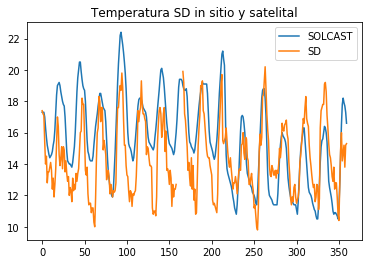

In [67]:
# Gráficas
y1 = dataSolarRangoSD['AirTemp'][24*15:24*30]
y2 = datosSD['Temp - °C'][24*15:24*30]

x1 = range(len(y1))
x2 = range(len(y2))

plt.plot(x1,y1)
plt.plot(x2,y2)

plt.title("Temperatura SD in sitio y satelital")
plt.legend(["SOLCAST", "SD"])
plt.show()

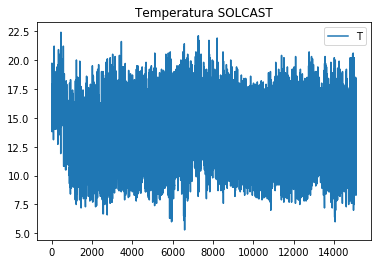

In [39]:
plt.plot(x1,dataSolarRangoSD['AirTemp'])
plt.title("Temperatura SOLCAST")
plt.legend("Temp")
plt.show()

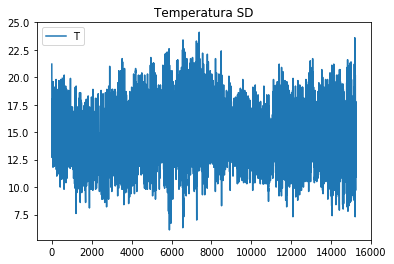

In [170]:
plt.plot(x2,datosSD['Temp - °C'])
plt.title("Temperatura SD")
plt.legend("Temp")
plt.show()

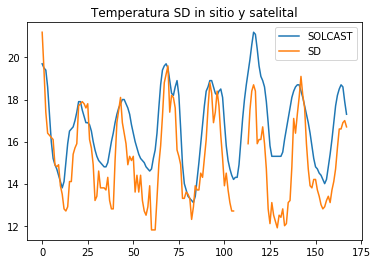

In [177]:
graficar(y1 = dataSolarRangoSD['AirTemp'][0:7*24], y2 = datosSD['Temp - °C'][0:7*24], 
         titulo = "Temperatura SD in sitio y satelital", leyendas = ["SOLCAST", "SD"],
         x_label = "Hora [h]", y_label = "Temperatura [°C]")

### Se hace un nuevo dataFrame para completar los datos del SD

In [24]:
list(datosSD)

['Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento',
 'Fecha']

In [25]:
# Fijar la fecha como el índice 
"""En donde la fije antes """
datosSD = datosSD.set_index("Date & Time")
datosSD.index

DatetimeIndex(['2019-05-07 16:00:00', '2019-05-07 17:00:00',
               '2019-05-07 18:00:00', '2019-05-07 19:00:00',
               '2019-05-07 20:00:00', '2019-05-07 21:00:00',
               '2019-05-07 22:00:00', '2019-05-07 23:00:00',
               '2019-05-08 00:00:00', '2019-05-08 01:00:00',
               ...
               '2021-02-01 00:00:00', '2021-02-01 01:00:00',
               '2021-02-01 02:00:00', '2021-02-01 03:00:00',
               '2021-02-01 04:00:00', '2021-02-01 05:00:00',
               '2021-02-01 06:00:00', '2021-02-01 07:00:00',
               '2021-02-01 08:00:00', '2021-02-01 09:00:00'],
              dtype='datetime64[ns]', name='Date & Time', length=15253, freq=None)

In [26]:
# Fecha mínima y máxima
min_date = datosSD.index.min()#["Date & Time"].min()
max_date = datosSD.index.max()#["Date & Time"].max()

# Todas las fechas entre 'min_date' y 'max_date'
all_dates = pd.date_range(start = min_date, end = max_date, freq="H")
all_dates

DatetimeIndex(['2019-05-07 16:00:00', '2019-05-07 17:00:00',
               '2019-05-07 18:00:00', '2019-05-07 19:00:00',
               '2019-05-07 20:00:00', '2019-05-07 21:00:00',
               '2019-05-07 22:00:00', '2019-05-07 23:00:00',
               '2019-05-08 00:00:00', '2019-05-08 01:00:00',
               ...
               '2021-02-01 00:00:00', '2021-02-01 01:00:00',
               '2021-02-01 02:00:00', '2021-02-01 03:00:00',
               '2021-02-01 04:00:00', '2021-02-01 05:00:00',
               '2021-02-01 06:00:00', '2021-02-01 07:00:00',
               '2021-02-01 08:00:00', '2021-02-01 09:00:00'],
              dtype='datetime64[ns]', length=15258, freq='H')

In [27]:
"""
cantidad_totales
cantidad_totales.min()
cantidad_totales.max()

Antes lo tenía así pero no sé que pasó
all_dates = cantidad_totales
all_dates.shape
"""


""" Soy consciente que el nuevo dataframe con los datos faltantes se llama datosSDConFechas?"""
# Rellenar fechas faltantes
datosSDConFechas = datosSD.reindex(all_dates, fill_value = np.nan)
datosSDConFechas


,Date,Time,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,Dirección del viento,...,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento,Fecha
2019-05-07 16:00:00,2019-05-07,16:00:00,21.2,21.3,21.2,47.0,9.5,12.2,0.9,ENE,...,NaN,NaN,NaN,0.00,1.6,0.69,1.6,0.000,0.217,2019-05-07 16:00:00
2019-05-07 17:00:00,2019-05-07,17:00:00,19.4,23.0,19.4,52.0,9.3,11.8,0.4,E,...,59.0,5.08,162.0,0.05,0.4,0.17,1.6,0.000,0.083,2019-05-07 17:00:00
2019-05-07 18:00:00,2019-05-07,18:00:00,17.4,19.5,17.4,60.0,9.6,11.7,1.3,ESE,...,47.0,4.04,97.0,0.05,0.0,0.00,0.5,0.067,0.000,2019-05-07 18:00:00
2019-05-07 19:00:00,2019-05-07,19:00:00,16.4,17.4,16.3,64.0,9.6,11.5,2.2,ESE,...,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.142,0.000,2019-05-07 19:00:00
2019-05-07 20:00:00,2019-05-07,20:00:00,16.3,16.6,16.1,67.0,10.2,11.9,0.9,SE,...,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.150,0.000,2019-05-07 20:00:00
2019-05-07 21:00:00,2019-05-07,21:00:00,16.2,16.7,15.7,68.0,10.3,11.9,0.9,S,...,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.163,0.000,2019-05-07 21:00:00
2019-05-07 22:00:00,2019-05-07,22:00:00,16.1,16.2,15.2,68.0,10.1,11.8,0.4,ESE,...,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.171,0.000,2019-05-07 22:00:00
2019-05-07 23:00:00,2019-05-07,23:00:00,14.9,16.1,14.7,70.0,9.5,11.1,0.4,SE,...,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.254,0.000,2019-05-07 23:00:00
2019-05-08 00:00:00,2019-05-08,00:00:00,14.8,15.6,14.3,71.0,9.6,11.2,0.9,ESE,...,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.262,0.000,2019-05-08 00:00:00
2019-05-08 01:00:00,2019-05-08,01:00:00,14.9,14.9,13.9,72.0,9.9,11.4,0.9,ESE,...,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.258,0.000,2019-05-08 01:00:00


In [28]:
# Regresar fecha como columna
datosSD = datosSD.reset_index().rename(columns = {"index":"Date & Time"})
datosSDConFechas = datosSDConFechas.reset_index().rename(columns = {"index":"Date & Time"})

# Nueva tabla
print("Nuevo tamaño {}".format(datosSDConFechas.shape))

Nuevo tamaño (15258, 31)


In [42]:
datosSD.shape

(15253, 31)

In [43]:
min_date

Timestamp('2019-05-07 16:00:00')

In [44]:
max_date

Timestamp('2021-02-01 09:00:00')

## Visualización previa

In [29]:
# Se unen los datos del SD con los de SOLCAST con la columna 'Date & Time' creada previamente
datos_merge = datosSD.merge(datos_solar[['Date & Time',"AirTemp"]], how ="left", on ='Date & Time')

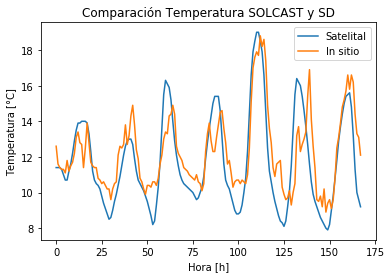

In [29]:
"""
    Comparar temperaturas
"""
k = 2358

start = k + 0
end = k + 24*7

graph = datos_merge.iloc[start:end,:]

"Será que pongo indicativos de cada día?"
#['L','Ma','Mi', 'J', 'V']

plt.title('Comparación Temperatura SOLCAST y SD')
plt.xlabel("Hora [h]")
plt.ylabel("Temperatura [°C]")

plt.plot(graph["AirTemp"].tolist())
plt.plot(graph['Temp - °C'].tolist())
plt.legend(['Satelital','In sitio'])
#plt.grid()

In [96]:
datos_merge.iloc[0]

AirTemp                             19.7
AlbedoDaily                         0.12
Azimuth                               74
CloudOpacity                        34.4
DewpointTemp                        16.5
Dhi                                  185
Dni                                  107
Ebh                                   39
Ghi                                  224
GtiFixedTilt                         217
GtiTracking                          303
PrecipitableWater                   28.8
RelativeHumidity                    81.8
SurfacePressure                    813.4
WindDirection10m                     138
WindSpeed10m                         2.1
Zenith                                69
Date & Time          2019-05-07 16:00:00
Temp - °C                           21.2
Name: 0, dtype: object

In [74]:
"""Tengo que revisar los Nan de datos_merge de los datos del SD"""
datos_merge.isna().sum()

Date & Time                          0
Date                                 0
Time                                 0
Temp - °C                            0
Temp. Alta - °C                      0
Temp. Baja - °C                      0
Hum - %                              0
Punto de rocío - °C                  0
Wet Bulb - °C                        0
Velocidad del viento - m/s           0
Dirección del viento               111
Viento Corriente - m                 0
Alta velocidad del viento - m/s      0
Alta Dirección del viento          175
Viento Frío - °C                     0
Índice de calor - °C                 0
THW Index - °C                       0
THSW  índice - °C                    0
Barómetro - mm Hg                    0
Lluvia - mm                          0
Tasa de lluvia - mm/h                0
Rad Solar - W/m^2                    0
Energía solar                        1
Rad Solar Alta - W/m^2               1
ET - mm                              0
El índice UV - Index     

In [75]:
datos_Enel_SD.isna().sum()

Date & Time_x                          0
Date_x                                 5
Time_x                                 5
Temp - °C_x                            0
Temp. Alta - °C_x                    201
Temp. Baja - °C_x                    201
Hum - %_x                            255
Punto de rocío - °C_x                255
Wet Bulb - °C_x                      255
Velocidad del viento - m/s_x           0
Dirección del viento_x               312
Viento Corriente - m_x               201
Alta velocidad del viento - m/s_x      5
Alta Dirección del viento_x          202
Viento Frío - °C_x                   255
Índice de calor - °C_x               255
THW Index - °C_x                     255
THSW  índice - °C_x                  256
Barómetro - mm Hg_x                    5
Lluvia - mm_x                          5
Tasa de lluvia - mm/h_x                5
Rad Solar - W/m^2_x                  208
Energía solar_x                      208
Rad Solar Alta - W/m^2_x             230
ET - mm_x       

## Modelos Temperatura

### Métodos para calcular métricas y modelos 

In [30]:
import sklearn
from sklearn.metrics import *

def myMetrics(true, pred):
    
    rmse = math.sqrt(mean_squared_error(true, pred))
    mae = sklearn.metrics.mean_absolute_error(true, pred)    
    mbe = np.mean(pred-true)
    r2 = r2_score(true, pred)
    #mape = sklearn.metrics.mean_absolute_percentage_error(true, pred)
    #maxerror = sklearn.metrics.max_error()
    
    print('RMSE: ' + str(rmse)) #Root Mean Square error
    print('MAE: ' + str(mae)) #Mean Absolute  error
    print('MBE: ' + str(mbe)) #Mean Bias error
    print('R2: ' + str(r2))
    #print('MAPE: '+ str(mape)) #Mean Absolute percentage error
   # print('Max Error'+str(maxerror))

In [31]:
def ModeloYgraficas(modelo, titulo, predictores = ["AirTemp",'Ghi', 'WindSpeed10m'], variable_y = "Temp - °C", ):
    
    predictores.append('Date & Time')

    # Comparar temperaturas
    datos_merge = datosSD.merge(datos_solar[predictores], how="left", on='Date & Time')

    all_columns = predictores.copy()
    all_columns.append(variable_y)

    datos_merge = datos_merge[all_columns]

    label_data = datos_merge.dropna()
    predictores.remove('Date & Time')

    X = label_data[predictores]
    y = label_data[variable_y]

    # Separar en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    # Modelo
    modelo.fit(X_train, y_train)
    y_predict = modelo.predict(X_test)

    # Errores
    rmse = math.sqrt(mean_squared_error(y_test, y_predict))
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test, y_predict)
    print("MAE:", mae)
    
    mbe = np.mean( y_predict - y_test )
    print('MBE: '+ str(mbe)) #Mean Bias error

    r2 = r2_score(y_test, y_predict) 
    print("R2:", r2)

    # Gráficas
    graficar(y1 = y_test[0:5*24], y2 = y_predict[0:5*24], 
         titulo = titulo, leyendas = ["Real", "Predicción"],
            x_label = "Hora [h]", y_label = "Temperatura [°C]")
    
    return modelo
 

In [31]:
sinNan = datos_merge.dropna()
myMetrics(sinNan["AirTemp"], sinNan['Temp - °C'])

RMSE: 2.286728490401732
MAE: 1.9365956291570516
MBE: 1.2402198995520568
R2: 0.5278969981348488


### Regresión Lineal

RMSE: 1.5033965469382127
MAE: 1.203306602791523
MBE: 0.01715953854093098
R2: 0.6735143678957047


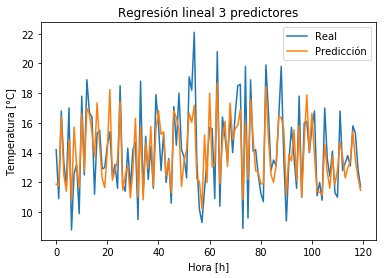

In [87]:
# Regresión Lineal - Pocos predictores
model_lr = linear_model.LinearRegression()
predictores = ["AirTemp",'Ghi', 'WindSpeed10m']
ModeloYgraficas(model_lr, "Regresión lineal 3 predictores", predictores=predictores)

RMSE: 1.2704892384194573
MAE: 1.0028755715760265
MBE: -0.015190336127006217
R2: 0.7668373630152872


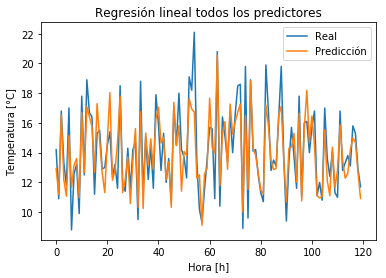

In [88]:
# Regresión Lineal - Todos los predictores
model_lr_todo = linear_model.LinearRegression()
predictores = list(datos_solar.select_dtypes(include=numerics).columns)
ModeloYgraficas(model_lr_todo, "Regresión lineal todos los predictores", predictores=predictores)

### Random Forest

C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 1.475587726414049
MAE: 1.1444772286262646
MBE: 0.013365821696540657
R2: 0.68548088474361


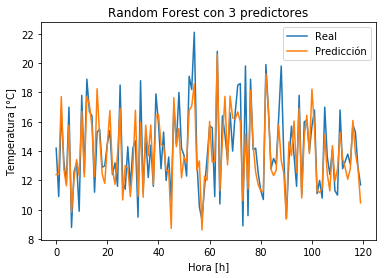

In [89]:
"""También podría desordenarlos"""

# RF - pocos predictores
model_rf = RandomForestRegressor()
predictores = ["AirTemp",'Ghi', 'WindSpeed10m']
ModeloYgraficas(model_rf, "Random Forest con 3 predictores", predictores=predictores)

RMSE: 1.431054357770699
MAE: 1.1179269707765103
R2: 0.7041788385242405


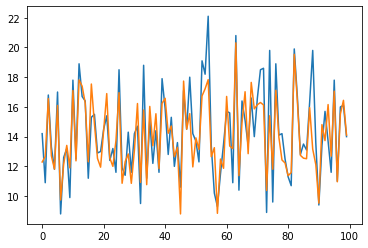

In [141]:
# RF - pocos predictores
model_rf = RandomForestRegressor()
predictores = ["AirTemp",'Ghi', 'WindSpeed10m']
ModeloYgraficas(model_rf, "Random Forest con 3 predictores", predictores=predictores)

C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 1.0978807320095159
MAE: 0.8508555069046817
MBE: -0.009872010778039836
R2: 0.8258885616353071


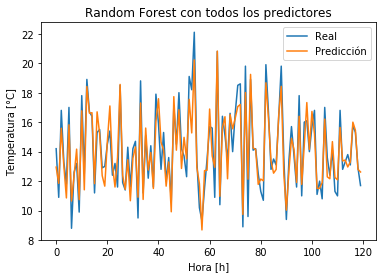

In [91]:
# RF - Todos los predictores
model_rf_todo = RandomForestRegressor()
predictores = list(datos_solar.select_dtypes(include=numerics).columns)
ModeloYgraficas(model_rf_todo, "Random Forest con todos los predictores", predictores=predictores)

C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 1.0881551870086406
MAE: 0.838006062647356
MBE: -0.0031525766251262943
R2: 0.8289596210468909


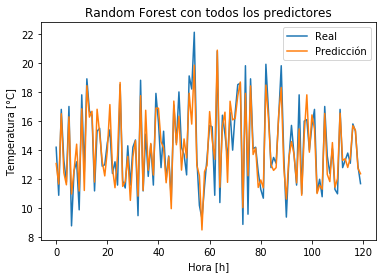

In [90]:
# RF - Todos los predictores
model_rf_todo = RandomForestRegressor()
predictores = list(datos_solar.select_dtypes(include=numerics).columns)
ModeloYgraficas(model_rf_todo, "Random Forest con todos los predictores", predictores=predictores)
""" Debería guardar los modelos y las predicciones de los datos (side-adaptation)"""

### XGBoost

RMSE: 1.3877205686297447
MAE: 1.0871107849218744
R2: 0.7218231226397138


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


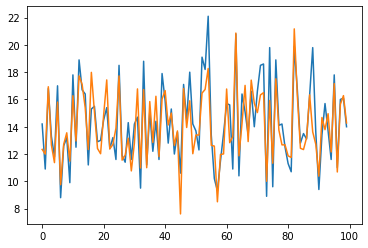

In [143]:
# Regresión Lineal - Todos los predictores
model_xgboost = xgboost.XGBRegressor()
predictores = ["AirTemp",'Ghi', 'WindSpeed10m']
ModeloYgraficas(model_xgboost, predictores = predictores)

In [28]:
# Regresión Lineal - Todos los predictores
model_xgboost_todo = xgboost.XGBRegressor()
predictores = list(datos_solar.select_dtypes(include = numerics).columns)
ModeloYgraficas(model_xgboost_todo, predictores = predictores)

NameError: name 'xgboost' is not defined

Se repite aparte el Modelo que mejor dió

C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 1.1057534705449017
MAE: 0.8561266419669923
R2: 0.8233825544638442


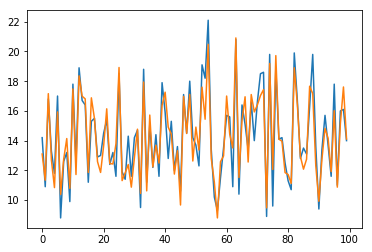

'Ya tengo resultados parciales de temperatura usando los mismos datos sin completar (CDT)'

In [31]:
model_rf_todo = RandomForestRegressor()

predictores = list(datos_solar.select_dtypes(include=numerics).columns)
predictores.append('Date & Time')

variable_y = "Temp - °C"

# Unir temperaturas
datos_merge = datosSD.merge(datos_solar[predictores], how ="left", on ='Date & Time')

all_columns = predictores.copy()
all_columns.append(variable_y)

datos_merge = datos_merge[all_columns]

label_data = datos_merge.dropna()
predictores.remove('Date & Time')

X = label_data[predictores]
y = label_data[variable_y]

# Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Modelo
model_rf_todo.fit(X_train, y_train)
y_predict = model_rf_todo.predict(X_test)

# Errores
myMetrics(y_test, y_predict)

# Gráficas
graficar(y1 = y_test[0:5*24], y2 = y_predict[0:5*24], 
         titulo = "Random Forest", leyendas = ["Real", "Predicción"],
            x_label = "Hora [h]", y_label = "Temperatura [°C]")


C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 1.0962435476647352
MAE: 0.8527349275850457
MBE: -0.012236443246884535
R2: 0.8264074522114512


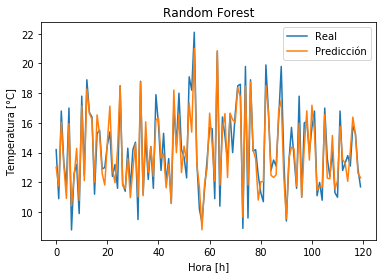

In [33]:

model_rf_todo = RandomForestRegressor()

predictores = list(datos_solar.select_dtypes(include=numerics).columns)
predictores.append('Date & Time')

variable_y = "Temp - °C"

# Unir temperaturas
datos_merge = datosSD.merge(datos_solar[predictores], how ="left", on ='Date & Time')

all_columns = predictores.copy()
all_columns.append(variable_y)

datos_merge = datos_merge[all_columns]

label_data = datos_merge.dropna()
predictores.remove('Date & Time')

X = label_data[predictores]
y = label_data[variable_y]

# Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Modelo
model_rf_todo.fit(X_train, y_train)
y_predict = model_rf_todo.predict(X_test)

# Errores
myMetrics(y_test, y_predict)

# Gráficas
graficar(y1 = y_test[0:5*24], y2 = y_predict[0:5*24], 
         titulo = "Random Forest", leyendas = ["Real", "Predicción"],
            x_label = "Hora [h]", y_label = "Temperatura [°C]")

In [34]:
"Tengo que adaptar/predecir todos los datos satelitales a los datos en sitio con el modelo que ya tengo"
datosSolar_completos = pd.read_csv("datosSOLCAST_Unidos.csv")
datos_adaptados = model_rf_todo.predict(datosSolar_completos[predictores])

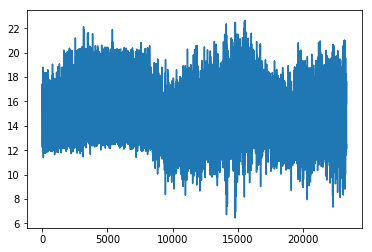

In [36]:
plt.plot(datos_adaptados[100000:])

In [ ]:
"""
    Por alguna razón hacia el final las temperaturas bajan
    hay que revisar
    También puedo graficar la temperatura que se tiene y calcular errores 
"""

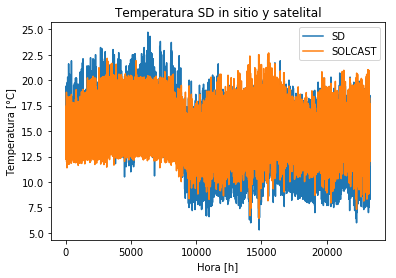

In [39]:
graficar(y1=datosSolar_completos['AirTemp'][100000:] , y2 = datos_adaptados[100000:])

In [41]:
datosSolar_completos.iloc[105000]

PeriodEnd            2018-12-24T02:00:00Z
PeriodStart          2018-12-24T01:00:00Z
Period                              PT60M
AirTemp                              16.7
AlbedoDaily                          0.13
Azimuth                               116
CloudOpacity                            0
DewpointTemp                         13.5
Dhi                                     0
Dni                                     0
Ebh                                     0
Ghi                                     0
GtiFixedTilt                            0
GtiTracking                             0
PrecipitableWater                    22.6
RelativeHumidity                     81.7
SurfacePressure                     809.4
WindDirection10m                      105
WindSpeed10m                          1.9
Zenith                                127
Name: 105000, dtype: object

In [37]:
pd.DataFrame(datos_adaptados).to_csv("TempSD_adaptada.csv", index=False, encoding="latin-1")

'Falta predecir velocidad de viento e irradiancia'

In [44]:
datos_solar['Date & Time']

0        2006-12-31 20:00:00
1        2006-12-31 21:00:00
2        2006-12-31 22:00:00
3        2006-12-31 23:00:00
4        2007-01-01 00:00:00
5        2007-01-01 01:00:00
6        2007-01-01 02:00:00
7        2007-01-01 03:00:00
8        2007-01-01 04:00:00
9        2007-01-01 05:00:00
10       2007-01-01 06:00:00
11       2007-01-01 07:00:00
12       2007-01-01 08:00:00
13       2007-01-01 09:00:00
14       2007-01-01 10:00:00
15       2007-01-01 11:00:00
16       2007-01-01 12:00:00
17       2007-01-01 13:00:00
18       2007-01-01 14:00:00
19       2007-01-01 15:00:00
20       2007-01-01 16:00:00
21       2007-01-01 17:00:00
22       2007-01-01 18:00:00
23       2007-01-01 19:00:00
24       2007-01-01 20:00:00
25       2007-01-01 21:00:00
26       2007-01-01 22:00:00
27       2007-01-01 23:00:00
28       2007-01-02 00:00:00
29       2007-01-02 01:00:00
                 ...        
123304   2021-01-24 11:00:00
123305   2021-01-24 12:00:00
123306   2021-01-24 13:00:00
123307   2021-

In [45]:
datos_adaptados_fecha = pd.DataFrame({'Date & Time':datos_solar['Date & Time'],'datos_adaptados':datos_adaptados})
datos_adaptados_fecha

,Date & Time,datos_adaptados
0,2006-12-31 20:00:00,17.10
1,2006-12-31 21:00:00,14.00
2,2006-12-31 22:00:00,14.51
3,2006-12-31 23:00:00,14.51
4,2007-01-01 00:00:00,13.19
5,2007-01-01 01:00:00,13.19
6,2007-01-01 02:00:00,13.38
7,2007-01-01 03:00:00,13.66
8,2007-01-01 04:00:00,13.27
9,2007-01-01 05:00:00,13.00


In [46]:
SD_adapt = datosSD.merge(datos_adaptados_fecha, how="left", on='Date & Time')
SD_adapt

,Date & Time,Date,Time,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,...,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento,Fecha,datos_adaptados
0,2019-05-07 16:00:00,2019-05-07,16:00:00,21.2,21.3,21.2,47.0,9.5,12.2,0.9,...,NaN,NaN,0.00,1.6,0.69,1.6,0.000,0.217,2019-05-07 16:00:00,20.59
1,2019-05-07 17:00:00,2019-05-07,17:00:00,19.4,23.0,19.4,52.0,9.3,11.8,0.4,...,5.08,162.0,0.05,0.4,0.17,1.6,0.000,0.083,2019-05-07 17:00:00,19.65
2,2019-05-07 18:00:00,2019-05-07,18:00:00,17.4,19.5,17.4,60.0,9.6,11.7,1.3,...,4.04,97.0,0.05,0.0,0.00,0.5,0.067,0.000,2019-05-07 18:00:00,16.99
3,2019-05-07 19:00:00,2019-05-07,19:00:00,16.4,17.4,16.3,64.0,9.6,11.5,2.2,...,0.00,0.0,0.03,0.0,0.00,0.0,0.142,0.000,2019-05-07 19:00:00,15.47
4,2019-05-07 20:00:00,2019-05-07,20:00:00,16.3,16.6,16.1,67.0,10.2,11.9,0.9,...,0.00,0.0,0.03,0.0,0.00,0.0,0.150,0.000,2019-05-07 20:00:00,16.27
5,2019-05-07 21:00:00,2019-05-07,21:00:00,16.2,16.7,15.7,68.0,10.3,11.9,0.9,...,0.00,0.0,0.03,0.0,0.00,0.0,0.163,0.000,2019-05-07 21:00:00,14.59
6,2019-05-07 22:00:00,2019-05-07,22:00:00,16.1,16.2,15.2,68.0,10.1,11.8,0.4,...,0.00,0.0,0.03,0.0,0.00,0.0,0.171,0.000,2019-05-07 22:00:00,14.94
7,2019-05-07 23:00:00,2019-05-07,23:00:00,14.9,16.1,14.7,70.0,9.5,11.1,0.4,...,0.00,0.0,0.03,0.0,0.00,0.0,0.254,0.000,2019-05-07 23:00:00,14.53
8,2019-05-08 00:00:00,2019-05-08,00:00:00,14.8,15.6,14.3,71.0,9.6,11.2,0.9,...,0.00,0.0,0.03,0.0,0.00,0.0,0.262,0.000,2019-05-08 00:00:00,13.25
9,2019-05-08 01:00:00,2019-05-08,01:00:00,14.9,14.9,13.9,72.0,9.9,11.4,0.9,...,0.00,0.0,0.03,0.0,0.00,0.0,0.258,0.000,2019-05-08 01:00:00,14.64


In [48]:
# error
SD_adapt = SD_adapt.dropna()
myMetrics(SD_adapt['datos_adaptados'], SD_adapt['Temp - °C'])

RMSE: 0.6433898260810483
MAE: 0.44113886249490974
MBE: 0.003116601058775669
R2: 0.9334061023887699


In [51]:
SD_adapt.to_csv("TempSD_adaptada_conFecha.csv", index=False)

In [64]:
datos_merge #= datosSD.merge(datos_solar[predictores], how="left", on='Date & Time')

,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,Date & Time,Temp - °C
0,19.7,0.12,74.0,34.4,16.5,185.0,107.0,39.0,224.0,217.0,303.0,28.8,81.8,813.4,138.0,2.1,69.0,2019-05-07 16:00:00,21.2
1,19.5,0.12,74.0,26.5,17.1,55.0,64.0,9.0,64.0,62.0,78.0,28.7,86.1,813.9,139.0,2.1,83.0,2019-05-07 17:00:00,19.4
2,19.4,0.12,72.0,29.1,17.8,0.0,0.0,0.0,0.0,0.0,0.0,28.5,90.5,814.3,140.0,2.1,98.0,2019-05-07 18:00:00,17.4
3,18.6,0.12,70.0,28.0,17.6,0.0,0.0,0.0,0.0,0.0,0.0,28.5,93.6,814.8,139.0,2.1,112.0,2019-05-07 19:00:00,16.4
4,17.3,0.12,66.0,39.3,16.5,0.0,0.0,0.0,0.0,0.0,0.0,28.7,95.3,815.4,138.0,2.1,126.0,2019-05-07 20:00:00,16.3
5,16.0,0.12,58.0,35.9,15.5,0.0,0.0,0.0,0.0,0.0,0.0,28.9,97.0,815.9,136.0,2.1,139.0,2019-05-07 21:00:00,16.2
6,15.2,0.12,42.0,0.3,14.9,0.0,0.0,0.0,0.0,0.0,0.0,28.8,98.1,816.0,138.0,1.8,150.0,2019-05-07 22:00:00,16.1
7,14.9,0.12,14.0,0.0,14.7,0.0,0.0,0.0,0.0,0.0,0.0,28.4,98.7,815.7,148.0,1.2,158.0,2019-05-07 23:00:00,14.9
8,14.7,0.12,-23.0,0.8,14.5,0.0,0.0,0.0,0.0,0.0,0.0,27.9,99.2,815.3,174.0,0.8,156.0,2019-05-08 00:00:00,14.8
9,14.4,0.12,-47.0,23.5,14.3,0.0,0.0,0.0,0.0,0.0,0.0,27.6,99.6,814.9,203.0,0.6,148.0,2019-05-08 01:00:00,14.9


### Normalizando

In [ ]:
""" Este es usando los mismos datos en sitio para predecir la temperatura"""

In [42]:
""" Esta parte la corrí en el notebook llamado 'Trabajo previo' """
shuffle_data = datosSD.sample(frac=1)
dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp - °C")
dataY = shuffle_data["Temp - °C"]

In [43]:
''' Esto lo había hecho antes para los datos del SD viejos, Re hacer'''

from sklearn import preprocessing
#shuffle_data = datosSD.sample(frac=1)
x = shuffle_data.select_dtypes(include=numerics).values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_shuffle_data = pd.DataFrame(x_scaled, columns = shuffle_data.select_dtypes(include=numerics).columns)
normalized_shuffle_data

,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,Viento Corriente - m,Alta velocidad del viento - m/s,Viento Frío - °C,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
0,0.488889,0.523256,0.533333,0.635135,0.737864,0.701220,0.576471,0.579505,0.630208,0.448780,...,0.000000,0.421373,0.421345,0.914305,0.500000,0.537815,0.537255,0.85625,0.174505,0.000000
1,0.466667,0.418605,0.503030,0.648649,0.728155,0.689024,0.105882,0.104829,0.161458,0.531707,...,0.000000,0.000000,0.000000,0.000000,0.039474,0.000000,0.000000,0.00000,0.198020,0.000000
2,0.366667,0.308140,0.375758,0.972973,0.859223,0.768293,0.000000,0.000000,0.046875,0.443902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.292079,0.000000
3,0.605556,0.558140,0.600000,0.554054,0.766990,0.756098,0.211765,0.210836,0.255208,0.653659,...,0.000000,0.250217,0.250202,0.280158,0.302632,0.352941,0.352941,0.50000,0.069307,0.000000
4,0.405556,0.348837,0.406061,0.918919,0.859223,0.786585,0.105882,0.104829,0.140625,0.478049,...,0.000000,0.032146,0.032108,0.032301,0.039474,0.000000,0.000000,0.00000,0.254950,0.000000
5,0.366667,0.331395,0.412121,0.729730,0.703883,0.640244,0.105882,0.104829,0.161458,0.443902,...,0.000000,0.000000,0.000000,0.000000,0.039474,0.000000,0.000000,0.00000,0.289604,0.000000
6,0.538889,0.488372,0.545455,0.648649,0.786408,0.756098,0.317647,0.315665,0.416667,0.585366,...,0.000000,0.325804,0.325828,0.347396,0.328947,0.361345,0.360784,0.38125,0.131188,0.000000
7,0.505556,0.540698,0.563636,0.675676,0.781553,0.743902,0.470588,0.473498,0.463542,0.502439,...,0.000000,0.232841,0.232835,0.486486,0.302632,0.176471,0.176471,0.24375,0.160891,0.000000
8,0.200000,0.156977,0.224242,0.891892,0.669903,0.554878,0.211765,0.210836,0.328125,0.268293,...,0.000000,0.000000,0.000000,0.000000,0.039474,0.000000,0.000000,0.00000,0.799505,0.000000
9,0.594444,0.587209,0.636364,0.418919,0.631068,0.628049,0.470588,0.473498,0.489583,0.590244,...,0.000000,0.696785,0.696789,0.671061,0.697368,0.764706,0.764706,0.70000,0.144802,0.000000


In [45]:
normalized_shuffle_data

,AirTemp
0,17.1
1,15.5
2,14.6
3,14.3
4,14.0
5,13.8
6,13.6
7,13.5
8,13.7
9,14.4


In [49]:
# Se dividen los datos
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

normalized_shuffle_data = normalized_shuffle_data.dropna()

dataX = normalized_shuffle_data.select_dtypes(include=numerics).drop(columns="Temp - °C")
"No se porque está esto"
#dataX = shuffle_data[["AirTemp"]]
dataY = normalized_shuffle_data["Temp - °C"]

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

RMSE: 0.0017383061562180324
MAE: 0.0008026565336074283
R2: 0.9998585600977683


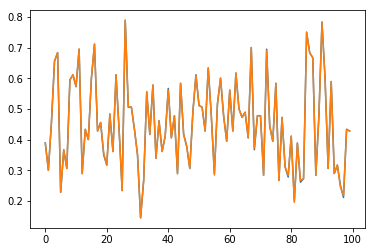

In [50]:
# Modelo
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Errores
rmse = math.sqrt(mean_squared_error(testY, yPredict))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredict)
print("MAE:", mae)

r2 = r2_score(testY,yPredict) 
print("R2:", r2)

x = range(len(testY))

# Gráficas
plt.plot(x[:100], testY[:100])
plt.plot(x[:100], yPredict[:100])
plt.show()

In [51]:
coeficientes = list(zip(dataX.columns, clf.coef_))
sorted(coeficientes, key=lambda x: -abs(x[1]))

[('THW Index - °C', -1.054633752174759),
 ('Viento Frío - °C', 1.0511700138606752),
 ('Índice de calor - °C', 0.9913264964427544),
 ('Energía solar', 0.10807385577974328),
 ('Rad Solar - W/m^2', -0.10776251627332528),
 ('Viento Corriente - m', 0.016894524550672533),
 ('Wet Bulb - °C', 0.013820787504591403),
 ('Velocidad del viento - m/s', -0.013462244685297607),
 ('Punto de rocío - °C', -0.010091282229147604),
 ('Hum - %', -0.008423603728946362),
 ('Temp. Baja - °C', 0.0018039854553809674),
 ('ET - mm', 0.0010477918279069335),
 ('El índice UV - Index', 0.0009663166612157292),
 ('THSW  índice - °C', 0.0007827500758191147),
 ('Barómetro - mm Hg', 0.0007549659060704224),
 ('Rad Solar Alta - W/m^2', -0.0007132493341009784),
 ('Días-grado de calentamiento', -0.0007011194008129249),
 ('Alto índice UV - Index', -0.0006038744203472927),
 ('Dosis de UV', -0.0005516964058753183),
 ('Alta velocidad del viento - m/s', -0.00048342692457917723),
 ('Días-grado de enfriamiento', 0.000431288190092892),

In [52]:
myMetrics(testY,yPredict)

RMSE: 0.0017383061562180324
MAE: 0.0008026565336074283
MBE: 2.11421693694771e-05
R2: 0.9998585600977683


Entrenamiento:
RMSE: 0.0017371627064725781
MAE: 0.0008021612629495835
MBE: 2.0038578514389534e-16
R2: 0.999858915832961
Testeo: 
RMSE: 0.0017383061562180324
MAE: 0.0008026565336074283
MBE: 2.11421693694771e-05
R2: 0.9998585600977683


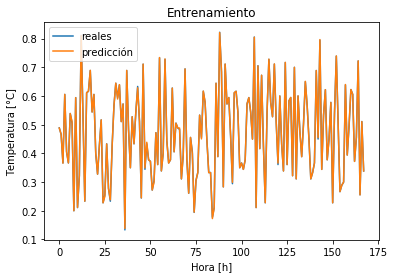

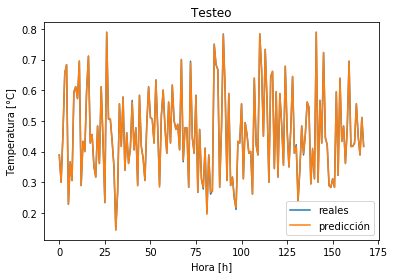

In [53]:
yPredict_train = clf.predict(trainX)
yPredict_test = clf.predict(testX)

# Errores
print("Entrenamiento:")
myMetrics(trainY, yPredict_train)
print("Testeo: ")
myMetrics(testY, yPredict_test)

# Gráficas
graficar(y1 = trainY[0:7*24], y2 = yPredict_train[0:7*24], titulo = "Entrenamiento", leyendas = ["reales" , "predicción"])
graficar(y1 = testY[0:7*24], y2 = yPredict_test[0:7*24], titulo = "Testeo", leyendas = ["reales" , "predicción"])


### Con datos de Enel (wetransfer)

Fecha mínima 2019-01-30 06:00:00
Fecha máxima 2021-02-11 00:00:00

In [69]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

datos_Enel_numeric = datos_Enel.select_dtypes(include=numerics)

shuffle_datos_Enel_numeric = datos_Enel_numeric.sample(frac=1)

shuffle_datos_Enel_numeric = shuffle_datos_Enel_numeric.dropna()

shuffle_datos_Enel_numeric.head()

,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,Viento Corriente - m,Alta velocidad del viento - m/s,Viento Frío - °C,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
Date & Time,,,,,,,,,,,,,,,,,,,,,
2020-12-29 13:00:00,18.9,20.7,18.9,63.0,11.7,13.6,0.9,0.89,4.9,18.9,...,0.0,211.0,18.16,345.0,0.20,3.7,1.59,10.9,0.000,0.025
2020-07-24 18:00:00,15.5,16.0,15.4,69.0,9.8,11.5,2.2,2.24,5.4,15.5,...,0.0,45.0,3.87,118.0,0.05,0.0,0.00,0.0,0.118,0.000
2020-02-19 03:00:00,14.9,15.2,14.4,70.0,9.5,11.1,0.4,0.45,2.2,14.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.141,0.000
2019-09-11 08:00:00,15.3,15.3,12.6,68.0,9.4,11.1,0.9,0.89,4.5,15.3,...,0.0,224.0,19.27,348.0,0.13,1.2,0.51,2.3,0.127,0.000
2020-10-04 03:00:00,12.1,12.5,11.8,88.0,10.1,10.8,0.9,0.89,2.7,12.1,...,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.262,0.000


In [70]:
list(datos_Enel)

['Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento']

In [71]:
shuffle_datos_Enel_numeric.shape

(15002, 25)

In [72]:
#dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp")
dataX = shuffle_datos_Enel_numeric.drop(columns='Temp - °C')
dataY = shuffle_datos_Enel_numeric['Temp - °C']

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

RMSE: 0.031200153732737965
MAE: 0.0144908514881165
R2: 0.9998593271608162


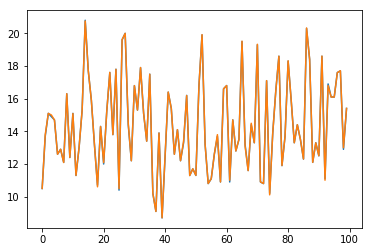

In [73]:
# Modelo
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Errores
rmse = math.sqrt(mean_squared_error(testY, yPredict))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredict)
print("MAE:", mae)

r2 = r2_score(testY,yPredict) 
print("R2:", r2)

x = range(len(testY))

# Gráficas
plt.plot(x[:100], testY[:100])
plt.plot(x[:100], yPredict[:100])
plt.show()

In [74]:
coeficientes = list(zip(dataX.columns, clf.coef_))
sorted(coeficientes, key=lambda x: -abs(x[1]))

[('Índice de calor - °C', 0.9744161422582798),
 ('Viento Frío - °C', 0.9184740608590207),
 ('THW Index - °C', -0.9041748254686227),
 ('Días-grado de enfriamiento', 0.029591475260149908),
 ('Viento Corriente - m', 0.025042486314319802),
 ('Velocidad del viento - m/s', -0.018142538266856537),
 ('Días-grado de calentamiento', -0.016337385435675505),
 ('ET - mm', 0.01357937762509808),
 ('Wet Bulb - °C', 0.01311345558013278),
 ('Dosis de UV', 0.012715306798083924),
 ('Energía solar', -0.007550443808129459),
 ('Punto de rocío - °C', -0.006658707262929673),
 ('El índice UV - Index', -0.004327066532403481),
 ('Temp. Baja - °C', 0.002471883804264427),
 ('Hum - %', -0.002372438470465241),
 ('Barómetro - mm Hg', 0.0012468551424631316),
 ('Alto índice UV - Index', -0.0009319856411582676),
 ('Rad Solar - W/m^2', 0.000652857318365298),
 ('THSW  índice - °C', 0.0005377794426662917),
 ('Alta velocidad del viento - m/s', -0.0005170430594506059),
 ('Temp.\xa0Alta - °C', 0.0002735273409813512),
 ('Lluvia

In sitio 2019-2020

satelitales para completar los datos in sitio

Tenemos varios modelos para la temperatura, este es el que mejor da, revisar el overfitting

### Random Forest Regressor
#### Se prueba con todos los datos disponibles

RMSE: 0.07561251261935971
MAE: 0.04226267051841296
R2: 0.9991779131811822


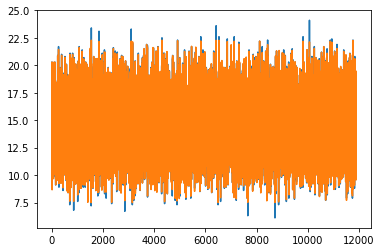

In [55]:
shuffle_data = shuffle_data.dropna()
dataXTodo = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp - °C")
#dataX = shuffle_data[["AirTemp"]] 
"revisar esto"
dataY = shuffle_data["Temp - °C"]

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainXTodo, testXTodo = dataXTodo[0:train_size], dataXTodo[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]
model_rfTodo = RandomForestRegressor(n_estimators=100, max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rfTodo.fit(trainXTodo, trainY)

yPredictTodo = model_rfTodo.predict(testXTodo)

rmse = math.sqrt(mean_squared_error(testY,yPredictTodo))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredictTodo)
print("MAE:", mae)

r2 = r2_score(testY, yPredictTodo) 
print("R2:", r2)

x = range(len(testY))
plt.plot(x, testY)
plt.plot(x, yPredictTodo)
plt.show()

Entrenamiento:
RMSE: 0.07166330378829565
MAE: 0.04065630905832639
MBE: -0.0007940339868647055
R2: 0.9992611278688097
Testeo: 
RMSE: 0.07561251261935972
MAE: 0.04226267051841294
MBE: -0.0007004764058480858
R2: 0.9991779131811822


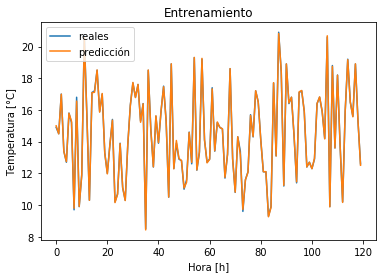

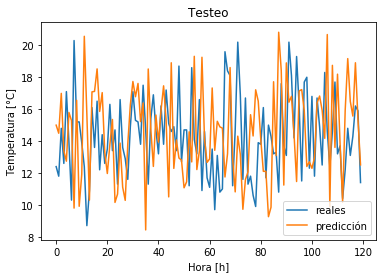

In [56]:
yPredict_train_todo = model_rfTodo.predict(trainXTodo)
yPredict_test_todo = model_rfTodo.predict(testXTodo)

# Errores
print("Entrenamiento:")
myMetrics(trainY, yPredict_train_todo)
print("Testeo: ")
myMetrics(testY, yPredict_test_todo)

# Gráficas
graficar(y1 = trainY[0:5*24], y2 = yPredict_train_todo[0:5*24], titulo = "Entrenamiento", leyendas = ["reales" , "predicción"])
graficar(y1 = testY[0:5*24], y2 = yPredict_train_todo[0:5*24], titulo = "Testeo", leyendas = ["reales" , "predicción"])


In [ ]:
"Voy aquíiii"
"""Con datos de ENEL """
dataXTodo = shuffle_datos_Enel_numeric.drop(columns='Temp - °C')
dataX = shuffle_datos_Enel_numeric[["Temp - °C"]]
dataY = shuffle_datos_Enel_numeric['Temp - °C']

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainXTodo, testXTodo = dataXTodo[0:train_size], dataXTodo[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]
model_rfTodo = RandomForestRegressor(n_estimators=100, max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rfTodo.fit(trainXTodo, trainY)

yPredictTodo = model_rfTodo.predict(testXTodo)

rmse = math.sqrt(mean_squared_error(testY,yPredictTodo))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredictTodo)
print("MAE:", mae)

r2 = r2_score(testY, yPredictTodo) 
print("R2:", r2)

x = range(len(testY))
plt.plot(x[:24*7], testY[:24*7])
plt.plot(x[:24*7], yPredictTodo[:24*7])
"Será que pongo indicativos de cada día?"
plt.xticks(np.arange(0, 24*7, step=24),["L","M","X","J","V","S","D"])
plt.show()

In [68]:
"""Asi no fue tan buena idea, es mejor con el merge"""
datosSDSinCompletar = datosSD.copy()
datosSDSinCompletar = datosSDSinCompletar[:15098]

In [ ]:
"Revisar"
# Datos SD viejos
datosSDSinCompletar = datosfechaSD2020.loc['2019-05-07 17:00:00':'2019-05-12  1:00:00']
datosSDSinCompletar = datosSDSinCompletar.append(datosfechaSD2020.loc['2019-05-12 9:00:00':'2019-05-16  3:00:00'])
datosSDSinCompletar = datosSDSinCompletar.append(datosfechaSD2020.loc['2019-05-16 11:00:00':'2019-05-29  6:00:00'])
datosSDSinCompletar = datosSDSinCompletar.append(datosfechaSD2020.loc['2019-05-29 14:00:00':'2019-07-8  9:00:00'])
#dataSolarRangoSD
datosSolarSinCompletar = dataFechaSolarCastArreglado.loc['2019-05-07T17:00:00Z':'2019-05-12T01:00:00Z']
datosSolarSinCompletar = datosSolarSinCompletar.append(dataFechaSolarCastArreglado.loc['2019-05-12T09:00:00Z':'2019-05-16T03:00:00Z'])
datosSolarSinCompletar = datosSolarSinCompletar.append(dataFechaSolarCastArreglado.loc['2019-05-16T11:00:00Z':'2019-05-29T06:00:00Z'])
datosSolarSinCompletar = datosSolarSinCompletar.append(dataFechaSolarCastArreglado.loc['2019-05-29T14:00:00Z':'2019-07-08T09:00:00Z'])
#
datosSolarSinCompletar2020 = datosSolarSinCompletar.set_index(datosSDSinCompletar.index)

In [ ]:
# Se 
#dataXTodo= pd.DataFrame({'Temp':datosSDSinCompletar.Temp, 'VelocidadViento':datosSDSinCompletar.VelocidadViento, 'Dhi':datosSolarSinCompletar.Dhi, 'Dni':datosSolarSinCompletar.Dni, 'Ghi':datosSolarSinCompletar.Ghi})
#dataY= datosSDSinCompletar.RadSolar
"""No es lo mismo que antes?"""
dataXTodo = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp - °C")
#dataX = shuffle_data[["AirTemp"]]
dataY = shuffle_data["Temp - °C"]

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainXTodo, testXTodo = dataXTodo[0:train_size], dataXTodo[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]
model_rfTodo = RandomForestRegressor(n_estimators=100, max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rfTodo.fit(trainXTodo, trainY)

yPredictTodo = model_rfTodo.predict(testXTodo)

rmse = math.sqrt(mean_squared_error(testY,yPredictTodo))
print(rmse)

r2 = r2_score(testY, yPredictTodo) 
print(r2)

x = range(len(testY))
plt.plot(x, testY)
plt.plot(x, yPredictTodo)
plt.show()

In [60]:
list(datosSDSinCompletar)

['Date & Time',
 'Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento',
 'Fecha']

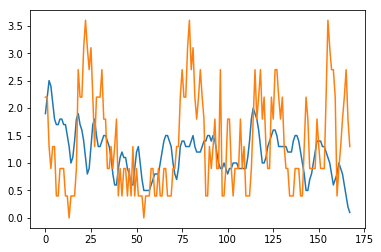

In [61]:
#%% Más grafiquitas
datosSolarSinCompletar = dataSolarRangoSD.copy()
x = range(len(datosSolarSinCompletar.WindSpeed10m[24*7*2:24*7*3]))
plt.plot(x, datosSolarSinCompletar.WindSpeed10m[24*7*2:24*7*3])
plt.plot(x, datosSDSinCompletar['Velocidad del viento - m/s'][24*7*2:24*7*3])
plt.show()

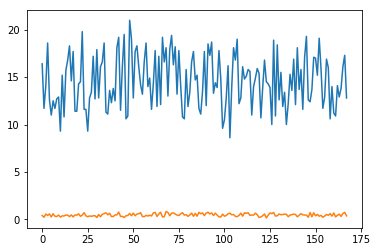

KeyError: 'Ghi'

In [74]:

#%%
x = range(len(testY[24*7*2:24*7*3]))
plt.plot(x, testY[24*7*2:24*7*3])
plt.plot(x, yPredict[24*7*2:24*7*3])
plt.show()
#%%
x = range(len(dataX[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, dataX['Ghi'][test_size+24*7*3:test_size+24*7*4])
plt.plot(x, dataY[test_size+24*7*3:test_size+24*7*4])
plt.show()


In [76]:
datosinCompletar = datosSolarSinCompletar.merge(datosSDSinCompletar, how ="left", on ='Date & Time').dropna()
rmse = math.sqrt(mean_squared_error(datosinCompletar['Rad Solar - W/m^2'],datosinCompletar['Ghi']))
print(rmse)
r2 = r2_score(datosinCompletar['Rad Solar - W/m^2'],datosinCompletar['Ghi']) 
print(r2)

171.0617303893515
0.398368981048162


In [63]:
list(datosSolarSinCompletar)

['PeriodEnd',
 'PeriodStart',
 'Period',
 'AirTemp',
 'AlbedoDaily',
 'Azimuth',
 'CloudOpacity',
 'DewpointTemp',
 'Dhi',
 'Dni',
 'Ebh',
 'Ghi',
 'GtiFixedTilt',
 'GtiTracking',
 'PrecipitableWater',
 'RelativeHumidity',
 'SurfacePressure',
 'WindDirection10m',
 'WindSpeed10m',
 'Zenith',
 'Date & Time']

rMSE velocidad viento:1.0425164602431385
r2 velocidad viento:-0.1003706493901717
rMSE temperatura2.286277273658829
r2 temperatura0.2429414593793332


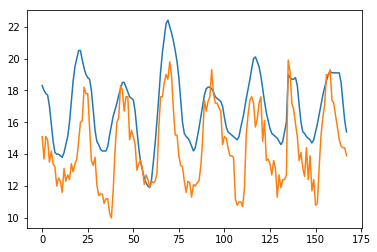

In [73]:
#%%
rmse = math.sqrt(mean_squared_error(datosinCompletar.WindSpeed10m,datosinCompletar['Velocidad del viento - m/s']))
print('rMSE velocidad viento:'+str(rmse))
r2 = r2_score(datosinCompletar['Velocidad del viento - m/s'], datosinCompletar.WindSpeed10m) 
print('r2 velocidad viento:'+str(r2))
rmse = math.sqrt(mean_squared_error(datosinCompletar["Temp - °C"], datosinCompletar.AirTemp))
print('rMSE temperatura'+ str(rmse))
r2 = r2_score( datosinCompletar["Temp - °C"], datosinCompletar.AirTemp) 
print('r2 temperatura'+ str(r2))
#%%
x = range(len(datosinCompletar.AirTemp[24*7*2:24*7*3]))
plt.plot(x, datosinCompletar.AirTemp[24*7*2:24*7*3])
plt.plot(x, datosinCompletar["Temp - °C"][24*7*2:24*7*3])
plt.show()

## Modelos Radiación

0.024474592399379783
0.9999999878198821


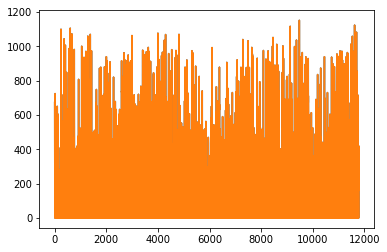

In [80]:
# Se prueba omitiendo los ceros entre las 6pm y 6am
dataX = datosinCompletar.drop(columns='Rad Solar - W/m^2').select_dtypes(include=numerics)
dataY = datosinCompletar['Rad Solar - W/m^2']

# Se dividen los datos
train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

# Modelo de regresión lineal
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Cálculos de errores
rmse = math.sqrt(mean_squared_error(testY,yPredict))
print(rmse)

r2 = r2_score(testY,yPredict) 
print(r2)

# Se grafica
x = range(len(testY))
plt.plot(x, testY)
plt.plot(x, yPredict)
plt.show()

Entrenamiento:
RMSE: 0.024406384696467137
MAE: 0.016054608562570783
MBE: -1.090290508062095e-07
R2: 0.9999999874832015
Testeo: 
RMSE: 0.024474592399379783
MAE: 0.016050321225299716
MBE: 0.0003229862931614762
R2: 0.9999999878198821


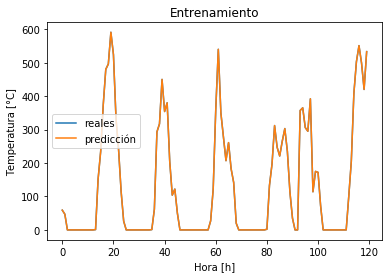

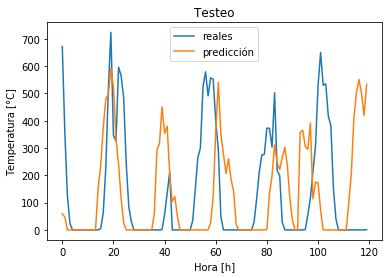

In [81]:
yPredict_train = clf.predict(trainX)
yPredict_test = clf.predict(testX)

# Errores
print("Entrenamiento:")
myMetrics(trainY, yPredict_train)
print("Testeo: ")
myMetrics(testY, yPredict_test)

# Gráficas
graficar(y1 = trainY[0:5*24], y2 = yPredict_train[0:5*24], titulo = "Entrenamiento", leyendas = ["reales" , "predicción"])
graficar(y1 = testY[0:5*24], y2 = yPredict_train[0:5*24], titulo = "Testeo", leyendas = ["reales" , "predicción"])


In [ ]:
"Overfitting every where"

### Se prueba omitiendo los ceros entre las 6pm y 6am

In [78]:
# Se prueba omitiendo los ceros entre las 6pm y 6am
dataX = dataX[datosSDSinCompletar['Rad Solar - W/m^2']!=0]
dataY = datosSDSinCompletar['Rad Solar - W/m^2'][datosSDSinCompletar['Rad Solar - W/m^2']!=0]

# Se dividen los datos
train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

# Modelo de regresión lineal
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Cálculos de errores
rmse = math.sqrt(mean_squared_error(testY,yPredict))
print(rmse)

r2 = r2_score(testY,yPredict) 
print(r2)

# Se grafica
x = range(len(testY))
plt.plot(x, testY)
plt.plot(x, yPredict)
plt.show()

C:\Users\Sony\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

### Se prueba con las 3 irradiaciones

In [ ]:
# solo DHI, DNI y GHI de SolarCast
dataX = pd.DataFrame({'Dhi':datosSolarSinCompletar.Dhi, 'Dni':datosSolarSinCompletar.Dni, 'Ghi':datosSolarSinCompletar.Ghi})
dataY = datosSDSinCompletar.RadSolar

# Se dividen los datos
train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

# Se crea y ajusta el modelo de regresión
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Se calculan los errores
rmse = math.sqrt(mean_squared_error(testY,yPredict))
print(rmse)

r2 = r2_score(testY,yPredict) 
print(r2)

# Se grafica
x = range(len(testY))
plt.plot(x, testY)
plt.plot(x, yPredict)
plt.show()

In [ ]:
# Se corrigen los ceros
correccionZeros = yPredict[testY==0]
copiaYPredict = yPredict
copiaYPredict[testY==0]=0

# Se recalculan los errores
rmse = math.sqrt(mean_squared_error(testY,copiaYPredict))
print(rmse)

r2 = r2_score(testY,copiaYPredict) 
print(r2)

# Se grafica
x = range(len(testY))
plt.plot(x, testY)
plt.plot(x, copiaYPredict)
plt.show()

### Random Forest Regressor

In [ ]:
#%%
dataX = pd.DataFrame({'AirTemp': datosSolarSinCompletar.AirTemp, 'Dhi':datosSolarSinCompletar.Dhi, 'Dni':datosSolarSinCompletar.Dni, 'Ghi':datosSolarSinCompletar.Ghi})
dataY = datosSDSinCompletar.RadSolar

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]
model_rf = RandomForestRegressor(n_estimators=100,  min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf.fit(trainX, trainY)

yPredictTrain = model_rf.predict(trainX)
yPredictTest = model_rf.predict(testX)

rmseTrain = math.sqrt(mean_squared_error(trainY,yPredictTrain))
rmseTest = math.sqrt(mean_squared_error(testY,yPredictTest))
print('RMSE Train: '+str(rmseTrain))
print('RMSE Test: '+str(rmseTest))

r2Train = r2_score(trainY,yPredictTrain) 
r2Test = r2_score(testY,yPredictTest) 
print('r2 Train: ' + str(r2Train))
print('r2 Test: ' + str(r2Test))

In [ ]:
#%%
dataX = pd.DataFrame({'SurfacePressure':datosSolarSinCompletar.SurfacePressure,'RelativeHumidity':datosSolarSinCompletar.RelativeHumidity,'CloudOpacity': datosSolarSinCompletar.CloudOpacity, 'WindSpeed10m': datosSolarSinCompletar.WindSpeed10m, 'AirTemp':datosSolarSinCompletar.AirTemp, 'Dhi':datosSolarSinCompletar.Dhi, 'Dni':datosSolarSinCompletar.Dni, 'Ghi':datosSolarSinCompletar.Ghi})
dataY = datosSDSinCompletar.RadSolar

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

model_rf = RandomForestRegressor(n_estimators=100, max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf.fit(trainX, trainY)

yPredictTrain = model_rf.predict(trainX)
yPredictTest = model_rf.predict(testX)

rmseTrain = math.sqrt(mean_squared_error(trainY,yPredictTrain))
rmseTest = math.sqrt(mean_squared_error(testY,yPredictTest))
print('RMSE Train: ' + str(rmseTrain))
print('RMSE Test: ' + str(rmseTest))

r2Train = r2_score(trainY,yPredictTrain) 
r2Test = r2_score(testY,yPredictTest) 
print('r2 Train: ' + str(r2Train))
print('r2 Test: ' + str(r2Test))

x = range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictTest[test_size+24*7*3:test_size+24*7*4])
plt.show()

In [ ]:
#%%
# LINEAR REGRESION
#%%
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

x = range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredict[test_size+24*7*3:test_size+24*7*4])
plt.show()

rmse = math.sqrt(mean_squared_error(testY,yPredict))
print(rmse)

r2 = r2_score(testY,yPredict) 
print(r2)

In [ ]:
#%% 
# GRIDSEARCH CV

from sklearn.model_selection import GridSearchCV
estimator = RandomForestRegressor()
param_grid = {"n_estimators": [10,50,100,200], "max_features": ["auto", "sqrt", "log2"],"min_samples_split" : [2,4,8],"bootstrap": [True, False]}
grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
grid.fit(trainX, trainY)
print(grid.best_score_)
print(grid.best_params_)

#%%
x = range(len(dataX[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, dataX.Ghi[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, dataY[test_size+24*7*3:test_size+24*7*4])
plt.show()

## Modelos Velocidad de viento

In [35]:
datos_wind_SD_Solar = datos_solar.merge(datosSD[['Velocidad del viento - m/s','Date & Time']], how ="left", on ='Date & Time')
datos_wind_SD_Solar

,PeriodEnd,PeriodStart,Period,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,...,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,Date & Time,Velocidad del viento - m/s
0,2007-01-01T02:00:00Z,2007-01-01T01:00:00Z,PT60M,17.1,0.13,116,0.0,14.0,0,0,...,0,0,22.5,82.2,814.6,112,1.9,126,2006-12-31 20:00:00,NaN
1,2007-01-01T03:00:00Z,2007-01-01T02:00:00Z,PT60M,15.5,0.13,121,0.0,13.8,0,0,...,0,0,22.5,89.7,815.2,115,1.8,140,2006-12-31 21:00:00,NaN
2,2007-01-01T04:00:00Z,2007-01-01T03:00:00Z,PT60M,14.6,0.13,134,0.0,13.7,0,0,...,0,0,22.3,94.2,815.4,119,1.8,152,2006-12-31 22:00:00,NaN
3,2007-01-01T05:00:00Z,2007-01-01T04:00:00Z,PT60M,14.3,0.13,161,0.0,13.6,0,0,...,0,0,22.0,95.4,815.3,123,1.8,160,2006-12-31 23:00:00,NaN
4,2007-01-01T06:00:00Z,2007-01-01T05:00:00Z,PT60M,14.0,0.13,-160,0.0,13.5,0,0,...,0,0,21.7,96.5,815.2,127,1.9,160,2007-01-01 00:00:00,NaN
5,2007-01-01T07:00:00Z,2007-01-01T06:00:00Z,PT60M,13.8,0.13,-133,0.0,13.4,0,0,...,0,0,21.4,97.2,815.0,128,1.9,151,2007-01-01 01:00:00,NaN
6,2007-01-01T08:00:00Z,2007-01-01T07:00:00Z,PT60M,13.6,0.13,-121,3.6,13.3,0,0,...,0,0,21.1,97.6,814.8,128,1.8,139,2007-01-01 02:00:00,NaN
7,2007-01-01T09:00:00Z,2007-01-01T08:00:00Z,PT60M,13.5,0.13,-115,16.8,13.2,0,0,...,0,0,20.7,97.9,814.5,127,1.7,126,2007-01-01 03:00:00,NaN
8,2007-01-01T10:00:00Z,2007-01-01T09:00:00Z,PT60M,13.7,0.13,-113,19.6,13.3,0,0,...,0,0,21.0,97.5,814.6,127,1.7,112,2007-01-01 04:00:00,NaN
9,2007-01-01T11:00:00Z,2007-01-01T10:00:00Z,PT60M,14.4,0.13,-113,43.7,13.8,0,0,...,0,0,21.7,96.5,814.9,127,1.8,98,2007-01-01 05:00:00,NaN


In [39]:
datos_wind_SD_Solar = datos_wind_SD_Solar.dropna()

In [40]:
"Falta predecir velocidad de viento"
"""Voy aquíii"""

"Voy a hacer un método para hacer "
dataX = datos_wind_SD_Solar.drop(columns = 'Velocidad del viento - m/s').select_dtypes(include=numerics)
#pd.DataFrame({'SurfacePressure':datosSolarSinCompletar.SurfacePressure,'RelativeHumidity':datosSolarSinCompletar.RelativeHumidity,'CloudOpacity': datosSolarSinCompletar.CloudOpacity, 'WindSpeed10m': datosSolarSinCompletar.WindSpeed10m, 'AirTemp':datosSolarSinCompletar.AirTemp, 'Dhi':datosSolarSinCompletar.Dhi, 'Dni':datosSolarSinCompletar.Dni, 'Ghi':datosSolarSinCompletar.Ghi})
dataY = datos_wind_SD_Solar['Velocidad del viento - m/s']

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]


RMSE Train: 0.6832601826632464
RMSE Test: 0.7293000587316071
r2 Train: 0.5264912576794765
r2 Test: 0.4679965362781907


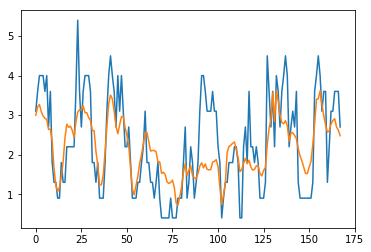

In [41]:

model_rf = RandomForestRegressor(n_estimators=100, max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf.fit(trainX, trainY)

yPredictTrain = model_rf.predict(trainX)
yPredictTest = model_rf.predict(testX)

rmseTrain = math.sqrt(mean_squared_error(trainY,yPredictTrain))
rmseTest = math.sqrt(mean_squared_error(testY,yPredictTest))
print('RMSE Train: ' + str(rmseTrain))
print('RMSE Test: ' + str(rmseTest))

r2Train = r2_score(trainY,yPredictTrain) 
r2Test = r2_score(testY,yPredictTest) 
print('r2 Train: ' + str(r2Train))
print('r2 Test: ' + str(r2Test))

x = range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictTest[test_size+24*7*3:test_size+24*7*4])
plt.show()

# Modelos de predicción de temperatura de celda

In [ ]:
RegresionYgraficasSG(variable_x = ["AirTemp"], variable_y = "Temp")
myMetrics()
graficar()

# Ecuaciones

## Paper 2

In [31]:
def ross(Ta, Tnoct, Gt):
    Tc = Ta + (Tnoct - 20)/800*Gt
    return Tc


## Paper 3 Curitiba

latitude 25.440626 S and longitude 49.268196 W. This system, according to [23], has 2.1 kWp of p-Si modules installed on the roof of the building. The measurements took place under the PV module, on June 11th 2018, hourly, between 8 am to 5 pm, and in this last time there was shading in the panel due to an adjacent building.

In [32]:
def risser(G, Ta, Vw):
    Tc = 3.81 + 0.0282*G + 1.31*Ta - 1.65*Vw
    return Tc

In [33]:
alfa = 0.0138
beta = 0.031
gamma = 0.042

In [34]:
#nm = Division between ηc and τα
#ηc = Conversion efficiency of the module described in its datasheet
#τα = Product of transmittance-absorbance, unknown exact value, however estimated at 0,9
def servant(Ta, G, Vw, nm):
    Tc = Ta + alfa*G*(1+beta*Ta)*(1-gamma*Vw)*(1-1.053*nm)
    return Tc

In [35]:
#ηc = Conversion efficiency of the module described in its datasheet
def duffie(Ta, G, Gnoct, Vw, Tcnoct, Tanoct, nc):
    Tc = Ta + ((G/Gnoct)*(9.5/(5.7+3.8*Vw)*(Tcnoct-Tanoct)*(1-nc/(r*a))))

In [56]:
list(datosSD)

['Date & Time',
 'Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento']

In [37]:
#si el índice de los datos no es 'Date & Time'
datosSD = datosSD.set_index('Date & Time')
datosSD.index

DatetimeIndex(['2019-05-07 16:00:00', '2019-05-07 17:00:00',
               '2019-05-07 18:00:00', '2019-05-07 19:00:00',
               '2019-05-07 20:00:00', '2019-05-07 21:00:00',
               '2019-05-07 22:00:00', '2019-05-07 23:00:00',
               '2019-05-08 00:00:00', '2019-05-08 01:00:00',
               ...
               '2021-02-01 00:00:00', '2021-02-01 01:00:00',
               '2021-02-01 02:00:00', '2021-02-01 03:00:00',
               '2021-02-01 04:00:00', '2021-02-01 05:00:00',
               '2021-02-01 06:00:00', '2021-02-01 07:00:00',
               '2021-02-01 08:00:00', '2021-02-01 09:00:00'],
              dtype='datetime64[ns]', name='Date & Time', length=15253, freq=None)

In [38]:
datosSD['Fecha'] = datosSD.index.astype('str')

In [39]:
datosTempSD['Fecha'] = datosTempSD.Time.astype('str')

In [40]:
list(datosTempSD)

['Time', 'Tc', 'Ta', 'Fecha']

In [58]:
datosTempSD.Time

0        2019-10-01 00:00:00
1        2019-10-01 01:00:00
2        2019-10-01 02:00:00
3        2019-10-01 03:00:00
4        2019-10-01 04:00:00
5        2019-10-01 05:00:00
6        2019-10-01 06:00:00
7        2019-10-01 07:00:00
8        2019-10-01 08:00:00
9        2019-10-01 09:00:00
10       2019-10-01 10:00:00
11       2019-10-01 11:00:00
12       2019-10-01 12:00:00
13       2019-10-01 13:00:00
14       2019-10-01 14:00:00
15       2019-10-01 15:00:00
16       2019-10-01 16:00:00
17       2019-10-01 17:00:00
18       2019-10-01 18:00:00
19       2019-10-01 19:00:00
20       2019-10-01 20:00:00
21       2019-10-01 21:00:00
22       2019-10-01 22:00:00
23       2019-10-01 23:00:00
24       2019-10-02 00:00:00
25       2019-10-02 01:00:00
26       2019-10-02 02:00:00
27       2019-10-02 03:00:00
28       2019-10-02 04:00:00
29       2019-10-02 05:00:00
                ...         
13779    2021-04-27 03:00:00
13780    2021-04-27 04:00:00
13781    2021-04-27 05:00:00
13782    2021-

In [41]:
dataSD_meteo_Tc = datosSD.merge(datosTempSD, how="left", on='Fecha')
dataSD_meteo_Tc

,Date,Time_x,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,Dirección del viento,...,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento,Fecha,Time_y,Tc,Ta
0,2019-05-07,16:00:00,21.2,21.3,21.2,47.0,9.5,12.2,0.9,ENE,...,0.00,1.6,0.69,1.6,0.000,0.217,2019-05-07 16:00:00,NaN,NaN,NaN
1,2019-05-07,17:00:00,19.4,23.0,19.4,52.0,9.3,11.8,0.4,E,...,0.05,0.4,0.17,1.6,0.000,0.083,2019-05-07 17:00:00,NaN,NaN,NaN
2,2019-05-07,18:00:00,17.4,19.5,17.4,60.0,9.6,11.7,1.3,ESE,...,0.05,0.0,0.00,0.5,0.067,0.000,2019-05-07 18:00:00,NaN,NaN,NaN
3,2019-05-07,19:00:00,16.4,17.4,16.3,64.0,9.6,11.5,2.2,ESE,...,0.03,0.0,0.00,0.0,0.142,0.000,2019-05-07 19:00:00,NaN,NaN,NaN
4,2019-05-07,20:00:00,16.3,16.6,16.1,67.0,10.2,11.9,0.9,SE,...,0.03,0.0,0.00,0.0,0.150,0.000,2019-05-07 20:00:00,NaN,NaN,NaN
5,2019-05-07,21:00:00,16.2,16.7,15.7,68.0,10.3,11.9,0.9,S,...,0.03,0.0,0.00,0.0,0.163,0.000,2019-05-07 21:00:00,NaN,NaN,NaN
6,2019-05-07,22:00:00,16.1,16.2,15.2,68.0,10.1,11.8,0.4,ESE,...,0.03,0.0,0.00,0.0,0.171,0.000,2019-05-07 22:00:00,NaN,NaN,NaN
7,2019-05-07,23:00:00,14.9,16.1,14.7,70.0,9.5,11.1,0.4,SE,...,0.03,0.0,0.00,0.0,0.254,0.000,2019-05-07 23:00:00,NaN,NaN,NaN
8,2019-05-08,00:00:00,14.8,15.6,14.3,71.0,9.6,11.2,0.9,ESE,...,0.03,0.0,0.00,0.0,0.262,0.000,2019-05-08 00:00:00,NaN,NaN,NaN
9,2019-05-08,01:00:00,14.9,14.9,13.9,72.0,9.9,11.4,0.9,ESE,...,0.03,0.0,0.00,0.0,0.258,0.000,2019-05-08 01:00:00,NaN,NaN,NaN


In [42]:
list(dataSD_meteo_Tc)

['Date',
 'Time_x',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento',
 'Fecha',
 'Time_y',
 'Tc',
 'Ta']

In [43]:
dataSD_meteo_Tc = dataSD_meteo_Tc.dropna()

In [45]:
#Datos SD
Ta = dataSD_meteo_Tc['Temp - °C']
Tnoct = 25
G = dataSD_meteo_Tc['Rad Solar - W/m^2']
Vw = dataSD_meteo_Tc['Velocidad del viento - m/s']
#nm

yRoss = ross(Ta, Tnoct, G)
yRisser = risser(G, Ta, Vw)

print('Ross: ')
print(myMetrics(yRoss, dataSD_meteo_Tc.Tc))

print('Risser: ')
print(myMetrics(yRisser, dataSD_meteo_Tc.Tc))

Ross: 
RMSE: 7.753992115525338
MAE: 4.4092824367939745
MBE: 3.9496852339967723
R2: -2.9014132959622985
None
Risser: 
RMSE: 5.732485796180623
MAE: 5.078926003227543
MBE: -4.875245529854783
R2: 0.6132104006260783
None


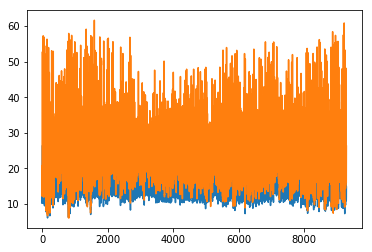

In [69]:
# Gráficas
x1 = range(len(yRoss))
x2 = range(len(yRisser))
plt.plot(x1,yRoss)
plt.plot(x2,yRisser)
plt.show()

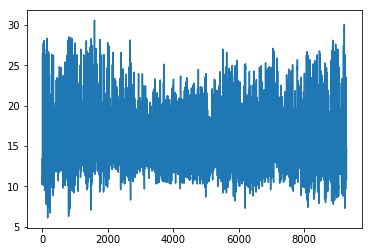

In [70]:
plt.plot(x1,yRoss)
plt.show()

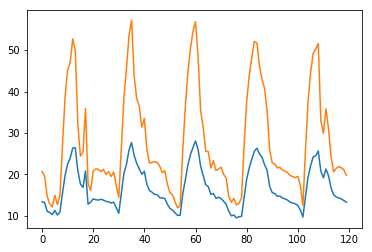

In [73]:
# Gráficas
x1 = range(24*5)
x2 = range(24*5)
plt.plot(x1,yRoss[:24*5])
plt.plot(x2,yRisser[:24*5])
plt.show()

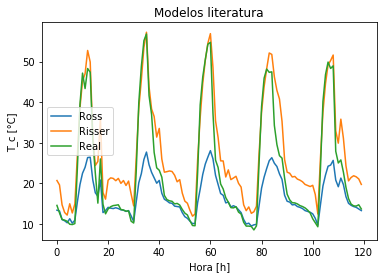

In [85]:
plt.plot(x1,yRoss[:24*5])
plt.plot(x2,yRisser[:24*5])
plt.plot(x1, dataSD_meteo_Tc.Tc[:24*5])

plt.xlabel("Hora [h]")
plt.ylabel("T_c [°C]")

plt.title("Modelos literatura")
plt.legend(["Ross","Risser","Real"])

plt.show()

Se prueba con datos satelitales

In [77]:
list(datos_solar)

['PeriodEnd',
 'PeriodStart',
 'Period',
 'AirTemp',
 'AlbedoDaily',
 'Azimuth',
 'CloudOpacity',
 'DewpointTemp',
 'Dhi',
 'Dni',
 'Ebh',
 'Ghi',
 'GtiFixedTilt',
 'GtiTracking',
 'PrecipitableWater',
 'RelativeHumidity',
 'SurfacePressure',
 'WindDirection10m',
 'WindSpeed10m',
 'Zenith',
 'Date & Time']

In [46]:
datos_solar['Fecha'] = datos_solar['Date & Time'].astype(str)
data_satelital_SD = datos_solar.merge(datosTempSD, how="left", on='Fecha')
list(data_satelital_SD)

['PeriodEnd',
 'PeriodStart',
 'Period',
 'AirTemp',
 'AlbedoDaily',
 'Azimuth',
 'CloudOpacity',
 'DewpointTemp',
 'Dhi',
 'Dni',
 'Ebh',
 'Ghi',
 'GtiFixedTilt',
 'GtiTracking',
 'PrecipitableWater',
 'RelativeHumidity',
 'SurfacePressure',
 'WindDirection10m',
 'WindSpeed10m',
 'Zenith',
 'Date & Time',
 'Fecha',
 'Time',
 'Tc',
 'Ta']

In [47]:
data_satelital_SD = data_satelital_SD.dropna()
Ta_sat = data_satelital_SD['AirTemp']
Tnoct = 25
G_sat = data_satelital_SD['Ghi']
Vw_sat = data_satelital_SD['WindSpeed10m']
#nm

yRoss_sat = ross(Ta_sat, Tnoct, G_sat)
yRisser_sat = risser(G_sat, Ta_sat, Vw_sat)

#Se calculan R2, RMSE, MBE
print('Ross')
myMetrics(yRoss_sat, data_satelital_SD.Tc)

print('Risser')
myMetrics(yRisser_sat, data_satelital_SD.Tc)

Ross
RMSE: 7.848960216076721
MAE: 5.195988163787588
MBE: 4.854356952441876
R2: -1.5869604749204744
Risser
RMSE: 7.906608234565484
MAE: 6.014483407976115
MBE: -5.5503956707187205
R2: 0.5326916004634674


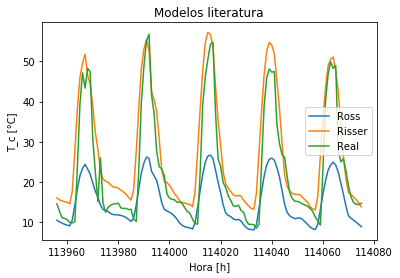

In [84]:
plt.plot(yRoss_sat[:24*5])
plt.plot(yRisser_sat[:24*5])
plt.plot(data_satelital_SD.Tc[:24*5])

plt.xlabel("Hora [h]")
plt.ylabel("T_c [°C]")

plt.title("Modelos literatura")
plt.legend(["Ross","Risser","Real"])

plt.show()

### Para datos ENEL

In [87]:
datos_Temp_Enel.columns

Index(['Time2', 'EP1_I02_AN00037', 'EP1_I03_AN00037', 'EP1_I06_AN00037',
       'EP1_I09_AN00037', 'EP1_I10_AN00037', 'EP1_I12_AN00037', 'Time'],
      dtype='object')

In [48]:
datos_Temp_Enel['Fecha'] = datos_Temp_Enel.Time.astype(str)
"Creo que esta parte no es necesaria ya tengo muchas columnas iguales con la fecha"

In [49]:
#Satelital
dataX = datos_solar.merge(datos_Temp_Enel, how="left", on='Fecha')
dataX = dataX.dropna()
dataX

,PeriodEnd,PeriodStart,Period,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,...,Date & Time,Fecha,Time2,EP1_I02_AN00037,EP1_I03_AN00037,EP1_I06_AN00037,EP1_I09_AN00037,EP1_I10_AN00037,EP1_I12_AN00037,Time
121165,2020-10-27T14:00:00Z,2020-10-27T13:00:00Z,PT60M,16.2,0.13,-111,16.7,12.0,272,461,...,2020-10-27 08:00:00,2020-10-27 08:00:00,2020-10-27 08:00:00,36.657263,38.419168,39.305792,37.810585,39.822927,40.003607,2020-10-27 08:00:00
121166,2020-10-27T15:00:00Z,2020-10-27T14:00:00Z,PT60M,18.1,0.13,-119,16.8,12.5,342,477,...,2020-10-27 09:00:00,2020-10-27 09:00:00,2020-10-27 09:00:00,40.014691,41.200365,42.854776,41.756546,43.524293,43.333846,2020-10-27 09:00:00
121167,2020-10-27T16:00:00Z,2020-10-27T15:00:00Z,PT60M,19.4,0.13,-136,20.0,13.0,433,405,...,2020-10-27 10:00:00,2020-10-27 10:00:00,2020-10-27 10:00:00,44.740313,46.215380,48.325253,47.085531,49.280874,49.159437,2020-10-27 10:00:00
121168,2020-10-27T17:00:00Z,2020-10-27T16:00:00Z,PT60M,20.1,0.13,-173,36.7,12.9,432,247,...,2020-10-27 11:00:00,2020-10-27 11:00:00,2020-10-27 11:00:00,45.877392,47.572402,49.953916,48.164314,50.364788,48.991143,2020-10-27 11:00:00
121169,2020-10-27T18:00:00Z,2020-10-27T17:00:00Z,PT60M,19.6,0.13,146,69.7,12.9,295,12,...,2020-10-27 12:00:00,2020-10-27 12:00:00,2020-10-27 12:00:00,48.989518,50.958203,53.152981,51.306499,53.444112,51.962862,2020-10-27 12:00:00
121170,2020-10-27T19:00:00Z,2020-10-27T18:00:00Z,PT60M,18.5,0.13,123,36.3,13.4,438,171,...,2020-10-27 13:00:00,2020-10-27 13:00:00,2020-10-27 13:00:00,52.441445,53.736047,54.802811,53.087225,55.586229,53.176292,2020-10-27 13:00:00
121171,2020-10-27T20:00:00Z,2020-10-27T19:00:00Z,PT60M,17.5,0.13,113,88.8,13.6,83,0,...,2020-10-27 14:00:00,2020-10-27 14:00:00,2020-10-27 14:00:00,50.058585,52.595026,52.102011,52.127904,52.891433,52.182435,2020-10-27 14:00:00
121172,2020-10-27T21:00:00Z,2020-10-27T20:00:00Z,PT60M,16.1,0.13,108,86.4,13.4,64,0,...,2020-10-27 15:00:00,2020-10-27 15:00:00,2020-10-27 15:00:00,45.196189,46.250410,45.844922,46.559087,46.071538,45.705647,2020-10-27 15:00:00
121173,2020-10-27T22:00:00Z,2020-10-27T21:00:00Z,PT60M,15.1,0.13,105,56.3,13.2,96,0,...,2020-10-27 16:00:00,2020-10-27 16:00:00,2020-10-27 16:00:00,34.624109,35.026826,35.402064,35.978439,35.366968,35.254481,2020-10-27 16:00:00
121174,2020-10-27T23:00:00Z,2020-10-27T22:00:00Z,PT60M,14.1,0.13,103,58.4,12.4,19,0,...,2020-10-27 17:00:00,2020-10-27 17:00:00,2020-10-27 17:00:00,28.178242,28.162668,27.517669,27.423817,28.080361,27.195781,2020-10-27 17:00:00


In [74]:
#Datos Satelitales para Tc ENEL
Ta_enel_sat = dataX['AirTemp']
Tnoct = 25
G_enel_sat = dataX[ 'Ghi']
Vw_enel_sat = dataX['WindSpeed10m']
#nm

yRoss_enel_sat = ross(Ta_enel_sat, Tnoct, G_enel_sat)
yRisser_enel_sat = risser(G_enel_sat, Ta_enel_sat, Vw_enel_sat)
#yServant = servant(Ta, G, Vw, nm)

#Se calculan R2, RMSE, MBE
print('Ross')
myMetrics(yRoss_enel_sat, dataX['EP1_I06_AN00037'])

print('Risser')
myMetrics(yRisser_enel_sat, dataX['EP1_I06_AN00037'])

Ross
RMSE: 18.22308549567154
MAE: 16.917210487347653
MBE: 16.912520821142
R2: -12.51426124522725
Risser
RMSE: 8.781712647309192
MAE: 7.480977719328598
MBE: 6.249027390989877
R2: 0.4357024023979039


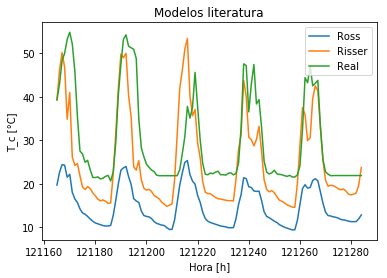

In [92]:
plt.plot(yRoss_enel_sat[:24*5])
plt.plot(yRisser_enel_sat[:24*5])
plt.plot(dataX['EP1_I06_AN00037'][:24*5])

plt.xlabel("Hora [h]")
plt.ylabel("T_c [°C]")

plt.title("Modelos literatura")
plt.legend(["Ross","Risser","Real"])

plt.show()

## Modelos Propios

In [62]:
""" Voy usar este no para side adapatation sino para los modelos de temp paneles """
# Función para graficar predicciones
def RegresionYgraficasSG(data = dataX, variable_x = ["AirTemp"], variable_y = 'EP1_I06_AN00037'):

    # Se dividen los datos
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    #Para modelo con todos predictores
    #dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="variable_y")
    data = data.select_dtypes(include=numerics)
    shuffle_data = data.sample(frac=1)
    dataX = shuffle_data[variable_x]
    dataY = shuffle_data[variable_y]

    train_size = int(len(dataX)*0.8)
    test_size = len(dataX) - train_size

    trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
    trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

    # Modelo
    clf = linear_model.LinearRegression()
    clf.fit(trainX, trainY)
    yPredict_train = clf.predict(trainX)
    yPredict_test = clf.predict(testX)

    # Errores
    print("Entrenamiento:")
    myMetrics(trainY, yPredict_train)
    print("Testeo: ")
    myMetrics(testY, yPredict_test)
    
    # Gráficas
    graficar(y1 = trainY[0:7*24], y2 = yPredict_train[0:7*24], titulo = "Entrenamiento", leyendas = ["reales" , "predicción"])
    graficar(y1 = testY[0:7*24], y2 = yPredict_test[0:7*24], titulo = "Testeo", leyendas = ["reales" , "predicción"])

    #Imprimir coeficientes
    print('Coeficientes: ')
    coeficientes = list(zip(dataX.columns, clf.coef_))
    print(sorted(coeficientes, key=lambda x: -abs(x[1])))
    
    return clf, clf.predict(data[predictores])
    
    """
    # Errores
    rmse = math.sqrt(mean_squared_error(testY, yPredict))
    print("RMSE:", rmse)

    mae = mean_absolute_error(testY, yPredict)
    print("MAE:", mae)

    r2 = r2_score(testY,yPredict) 
    print("R2:", r2)

    x = range(len(testY))

    # Gráficas
    plt.plot(x[:100], testY[:100])
    plt.plot(x[:100], yPredict[:100])
    plt.show() """

Entrenamiento:
RMSE: 4.48117917923977
MAE: 3.063858445363537
MBE: 1.7016167533620844e-15
R2: 0.8277785321958564
Testeo: 
RMSE: 4.393145826366049
MAE: 2.9949920189117716
MBE: 0.0007009251634923856
R2: 0.8305222314804939


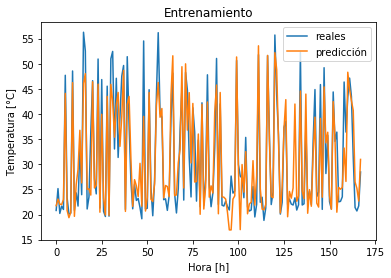

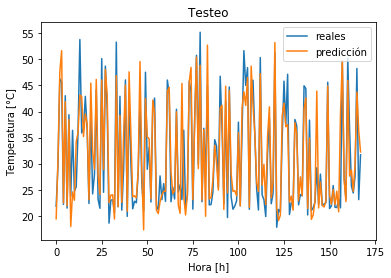

Coeficientes: 
[('WindSpeed10m', 3.824581983527248), ('AirTemp', 2.2025903707563654), ('Ghi', 0.006668921530886229)]


In [102]:
predictores = ["AirTemp",'Ghi', 'WindSpeed10m']
RegresionYgraficasSG(data = dataX, variable_x = predictores, variable_y = 'EP1_I06_AN00037')

In [51]:
list(dataX)

['PeriodEnd',
 'PeriodStart',
 'Period',
 'AirTemp',
 'AlbedoDaily',
 'Azimuth',
 'CloudOpacity',
 'DewpointTemp',
 'Dhi',
 'Dni',
 'Ebh',
 'Ghi',
 'GtiFixedTilt',
 'GtiTracking',
 'PrecipitableWater',
 'RelativeHumidity',
 'SurfacePressure',
 'WindDirection10m',
 'WindSpeed10m',
 'Zenith',
 'Date & Time',
 'Fecha',
 'Time2',
 'EP1_I02_AN00037',
 'EP1_I03_AN00037',
 'EP1_I06_AN00037',
 'EP1_I09_AN00037',
 'EP1_I10_AN00037',
 'EP1_I12_AN00037',
 'Time']

Entrenamiento:
RMSE: 1.9552529662937221
MAE: 0.9374710094078433
MBE: -9.048669594593322e-15
R2: 0.9671318330824791
Testeo: 
RMSE: 1.983687584817306
MAE: 0.9654433701836319
MBE: 0.000486930867276489
R2: 0.9661231355717241


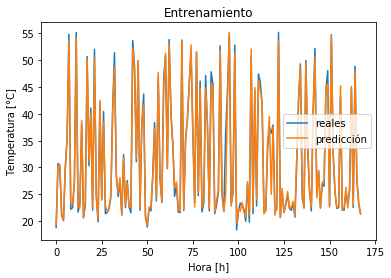

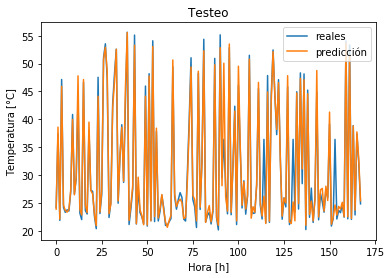

Coeficientes: 
[('AlbedoDaily', -23.442975825691313), ('EP1_I12_AN00037', 0.6530587390168567), ('WindSpeed10m', 0.49781981719427726), ('Dhi', -0.15385979676060932), ('Ebh', -0.15235636103636083), ('Ghi', 0.13173018894922575), ('DewpointTemp', 0.10817474415021028), ('EP1_I03_AN00037', 0.10713456485351947), ('EP1_I02_AN00037', 0.08609959062920568), ('RelativeHumidity', -0.07691343540277333), ('EP1_I09_AN00037', 0.06700488483974483), ('PrecipitableWater', 0.04642229406554505), ('GtiFixedTilt', 0.022785557735964947), ('EP1_I10_AN00037', 0.01860523762651898), ('AirTemp', -0.013892600255656496), ('SurfacePressure', 0.00634678609030362), ('CloudOpacity', 0.0032427629803560907), ('GtiTracking', -0.002803966666673877), ('Zenith', 0.002703854793277738), ('WindDirection10m', -0.0011789132073547353), ('Dni', -0.0005986761896763221), ('Azimuth', 3.169204609268986e-05)]


In [104]:
"Tiene casi todas las columnas de los datos del Enel excepto la que estoy prediciendo"
predictores = dataX.select_dtypes(include=numerics).drop(columns="EP1_I06_AN00037").columns
RegresionYgraficasSG(data = dataX, variable_x = predictores, variable_y = 'EP1_I06_AN00037')

Entrenamiento:
RMSE: 3.946787963224108
MAE: 2.693553654248671
MBE: -2.4719515579527176e-14
R2: 0.8667811819896137
Testeo: 
RMSE: 4.04490559583723
MAE: 2.755369361829972
MBE: -0.03006508748730923
R2: 0.8601912782356209


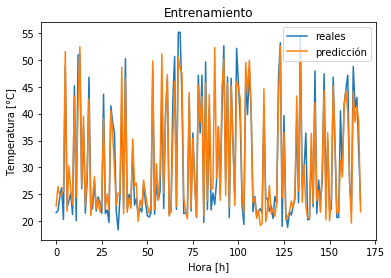

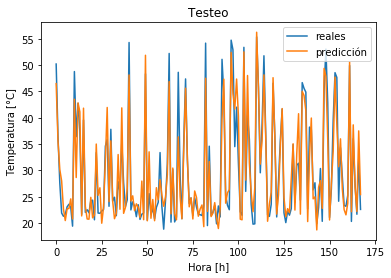

Coeficientes: 
[('AlbedoDaily', -42.91452229613371), ('WindSpeed10m', 2.4960610046552816), ('DewpointTemp', 1.762112788007594), ('Ebh', -0.7510153358919739), ('Dhi', -0.7497571458321537), ('RelativeHumidity', -0.4801511806198569), ('GtiFixedTilt', 0.4142824480060567), ('Ghi', 0.3487091710036253), ('AirTemp', -0.2422740927445544), ('PrecipitableWater', -0.12817651957516468), ('SurfacePressure', -0.09717300130997533), ('CloudOpacity', 0.029390087495516238), ('Zenith', -0.023544333680114233), ('Dni', -0.021022231352917763), ('Azimuth', 0.0069298161364157295), ('WindDirection10m', -0.006015483809900941), ('GtiTracking', 0.00023268010743689892)]


In [63]:
predictores = datos_solar.select_dtypes(include=numerics).columns
clf_enel, predicción = RegresionYgraficasSG(data = dataX, variable_x = predictores, variable_y = 'EP1_I06_AN00037')

In [66]:
"""Luego con data_satelital_SD
Voy aquii """

#prediccion = clf_enel.predict(dataX[predictores])
myMetrics(dataX['EP1_I06_AN00037'], predicción)

RMSE: 4.0180103425856055
MAE: 2.7263817290446983
MBE: 0.013061779996151811
R2: 0.8617619757022861


In [65]:
predicción

array([36.60126333, 41.97186455, 46.67865731, ..., 49.01840665,
       46.28711686, 41.79233074])

In [61]:
"""
Por alguna extraña razón el modelo que devuleve el método es None
"""
print(clf_enel)

None


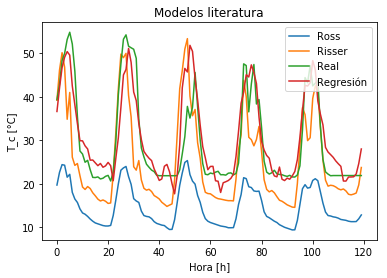

In [75]:
x1 = range(24*5)
plt.plot(x1, yRoss_enel_sat[:24*5])
plt.plot(x1, yRisser_enel_sat[:24*5])
plt.plot(x1, dataX['EP1_I06_AN00037'][:24*5])
plt.plot(x1, predicción[:24*5])

plt.xlabel("Hora [h]")
plt.ylabel("T_c [°C]")

plt.title("Modelos literatura")
plt.legend(["Ross","Risser","Real", "Regresión"])

plt.show()

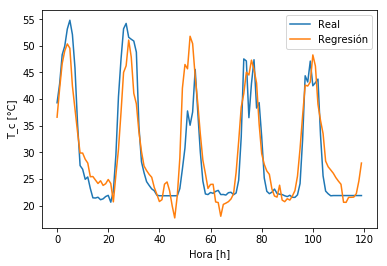

In [76]:
x1 = range(24*5)

plt.plot(x1, dataX['EP1_I06_AN00037'][:24*5])
plt.plot(x1, predicción[:24*5])

plt.xlabel("Hora [h]")
plt.ylabel("T_c [°C]")

#plt.title("Modelos literatura")
plt.legend(["Real", "Regresión"])

plt.show()

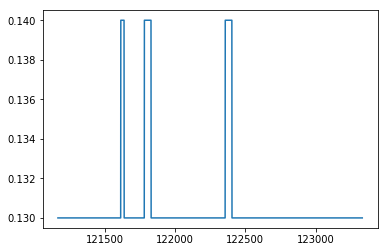

In [77]:
plt.plot(dataX['AlbedoDaily'])

In [78]:
dataX['AlbedoDaily']

121165    0.13
121166    0.13
121167    0.13
121168    0.13
121169    0.13
121170    0.13
121171    0.13
121172    0.13
121173    0.13
121174    0.13
121175    0.13
121176    0.13
121177    0.13
121178    0.13
121179    0.13
121180    0.13
121181    0.13
121182    0.13
121183    0.13
121184    0.13
121185    0.13
121186    0.13
121187    0.13
121188    0.13
121189    0.13
121190    0.13
121191    0.13
121192    0.13
121193    0.13
121194    0.13
          ... 
123304    0.13
123305    0.13
123306    0.13
123307    0.13
123308    0.13
123309    0.13
123310    0.13
123311    0.13
123312    0.13
123313    0.13
123314    0.13
123315    0.13
123316    0.13
123317    0.13
123318    0.13
123319    0.13
123320    0.13
123321    0.13
123322    0.13
123323    0.13
123324    0.13
123325    0.13
123326    0.13
123327    0.13
123328    0.13
123329    0.13
123330    0.13
123331    0.13
123332    0.13
123333    0.13
Name: AlbedoDaily, Length: 2169, dtype: float64

In [ ]:
# Función para graficar predicciones 
def ModeloYgraficas(model, variable_x = ["AirTemp"], variable_y = "Temp"):

    # Se dividen los datos
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    #dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp")
    dataX = shuffle_data[variable_x]
    dataY = shuffle_data["Temp"]

    train_size = int(len(dataX)*0.8)
    test_size = len(dataX) - train_size

    trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
    trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

    # Modelo
    model.fit(trainX, trainY)
    yPredict = model.predict(testX)
    
    # Errores
    print("Entrenamiento:")
    myMetrics(trainY, yPredict_train)
    print("Testeo: ")
    myMetrics(testY, yPredict_test)
    
    # Gráficas
    graficar(y1 = trainY[0:7*24], y2 = yPredict_train[0:7*24], titulo = "Entrenamiento", leyendas = ["reales" , "predicción"])
    graficar(y1 = trainY[0:7*24], y2 = yPredict_train[0:7*24], titulo = "Testeo", leyendas = ["reales" , "predicción"])

    return model, model.predict(dataX)

    """
    # Errores
    rmse = math.sqrt(mean_squared_error(testY, yPredict))
    print("RMSE:", rmse)

    mae = mean_absolute_error(testY, yPredict)
    print("MAE:", mae)

    r2 = r2_score(testY,yPredict) 
    print("R2:", r2)

    x = range(len(testY))

    # Gráficas
    plt.plot(x[:100], testY[:100])
    plt.plot(x[:100], yPredict[:100])
    plt.show()"""

## Datos ENEL

Datos in sitio:
    ENEL side adaptation (NREL) check
    SD temp promedio horas pasadas, velocidad de viento (interpolación)
    Side-adaptation con los datos [SOLCAST SD nuevos]
    
Calcular modelos de temperatura

In [ ]:
datosTempSD.head()

# Otros

In [127]:
#a = test['EP1_I06_AN00037'].astype(float).groupby('Time2').mean()
#print(a)

KeyError: 'Time2'

In [ ]:
from csv import reader

# open file in read mode
with open('Temp_SD_2019_01_01_2021_04_28.csv', 'r') as read_obj:
    
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for idx,row in enumerate(csv_reader):
        # row variable is a list that represents a row in csv
        print(row)
        if idx == 3:
            break

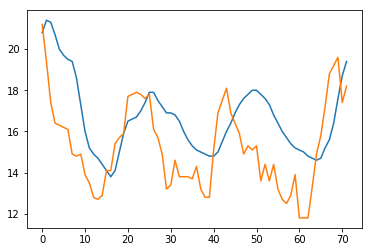

In [59]:
"Se muestra el corrimiento que tenían antes (En PeriodStart) los datos de SOLCAST"
x1 = datos_solar[datos_solar["PeriodStart"]>="2019-05-07T16:00:00Z"].head(72)["AirTemp"].tolist()
x2 = datosSD.head(72)['Temp - °C'].tolist()

plt.plot(x1)
plt.plot(x2)

In [85]:
len(datos_solar[datos_solar["PeriodStart"]>="2019-05-07T16:00:00Z"])

15103

In [86]:
len(datosSD)

15253

In [87]:
len(datos_solar)

123334

In [90]:
"Faltan 150"
datosSD.iloc[0]

Date & Time                        2019-05-07 16:00:00
Date                               2019-05-07 00:00:00
Time                                          16:00:00
Temp - °C                                         21.2
Temp. Alta - °C                                   21.3
Temp. Baja - °C                                   21.2
Hum - %                                             47
Punto de rocío - °C                                9.5
Wet Bulb - °C                                     12.2
Velocidad del viento - m/s                         0.9
Dirección del viento                               ENE
Viento Corriente - m                              0.89
Alta velocidad del viento - m/s                    1.8
Alta Dirección del viento                          ESE
Viento Frío - °C                                  21.2
Índice de calor - °C                              20.2
THW Index - °C                                    20.2
THSW  índice - °C                                  NaN
Barómetro 

In [93]:
datos_solcast_SD = datos_solar[datos_solar["PeriodStart"]>="2019-05-07T16:00:00Z"]

In [95]:
datos_solcast_SD.iloc[0]

PeriodEnd            2019-05-07T17:00:00Z
PeriodStart          2019-05-07T16:00:00Z
Period                              PT60M
AirTemp                              20.8
AlbedoDaily                          0.12
Azimuth                               -22
CloudOpacity                         20.8
DewpointTemp                         15.5
Dhi                                   459
Dni                                   396
Ebh                                   384
Ghi                                   843
GtiFixedTilt                          792
GtiTracking                           806
PrecipitableWater                    27.4
RelativeHumidity                     71.6
SurfacePressure                     815.6
WindDirection10m                      137
WindSpeed10m                          2.7
Zenith                                 14
Date & Time           2019-05-07 11:00:00
Name: 108231, dtype: object

In [31]:
"""Voy aquíiiii"""

"""Haré un dataset con los datos del SD y los de SOLAR,
para tenerlos en el mismo y luego hacer drop de los NaN
Creo que ya estaba hecho, así que revisaré
"""
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Se seleccionan los datos de SOLCAST para predecir los datos faltantes del SD
dataX = dataSolarRangoSD.select_dtypes(include=numerics)
dataX


,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith
108236,19.7,0.12,74,34.4,16.5,185,107,39,224,217,303,28.8,81.8,813.4,138,2.1,69
108237,19.5,0.12,74,26.5,17.1,55,64,9,64,62,78,28.7,86.1,813.9,139,2.1,83
108238,19.4,0.12,72,29.1,17.8,0,0,0,0,0,0,28.5,90.5,814.3,140,2.1,98
108239,18.6,0.12,70,28.0,17.6,0,0,0,0,0,0,28.5,93.6,814.8,139,2.1,112
108240,17.3,0.12,66,39.3,16.5,0,0,0,0,0,0,28.7,95.3,815.4,138,2.1,126
108241,16.0,0.12,58,35.9,15.5,0,0,0,0,0,0,28.9,97.0,815.9,136,2.1,139
108242,15.2,0.12,42,0.3,14.9,0,0,0,0,0,0,28.8,98.1,816.0,138,1.8,150
108243,14.9,0.12,14,0.0,14.7,0,0,0,0,0,0,28.4,98.7,815.7,148,1.2,158
108244,14.7,0.12,-23,0.8,14.5,0,0,0,0,0,0,27.9,99.2,815.3,174,0.8,156
108245,14.4,0.12,-47,23.5,14.3,0,0,0,0,0,0,27.6,99.6,814.9,203,0.6,148


In [32]:
datosSDConFechas.index

RangeIndex(start=0, stop=15258, step=1)

In [18]:
datosSD.index

RangeIndex(start=0, stop=15253, step=1)

In [33]:
dataY = datosSDConFechas.select_dtypes(include=numerics)
dataY = dataY.set_index(all_dates)
dataY

,Alta velocidad del viento - m/s,Barómetro - mm Hg,Lluvia - mm,Tasa de lluvia - mm/h,ET - mm
2019-05-07 16:00:00,1.8,556.2,0.0,0.0,0.00
2019-05-07 17:00:00,4.5,556.3,0.0,0.0,0.05
2019-05-07 18:00:00,4.9,555.9,0.0,0.0,0.05
2019-05-07 19:00:00,5.4,556.7,0.0,0.0,0.03
2019-05-07 20:00:00,3.1,557.2,0.0,0.0,0.03
2019-05-07 21:00:00,4.5,558.0,0.0,0.0,0.03
2019-05-07 22:00:00,3.6,557.8,0.0,0.0,0.03
2019-05-07 23:00:00,3.1,557.6,0.0,0.0,0.03
2019-05-08 00:00:00,3.6,557.7,0.0,0.0,0.03
2019-05-08 01:00:00,4.5,557.4,0.0,0.0,0.03


In [ ]:
"""No entiendo que pasa aquí"""
len(dataX)==len(dataY) 

In [34]:
print(" Datos X (datos SolCast): "+str(len(dataX))+", Datos Y (datos SD): "+str(len(dataY)))

 Datos X (datos SolCast): 15098, Datos Y (datos SD): 15258


In [ ]:
#shuffle_data = datosSD.sample(frac=1)
#dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp - °C")
dataY = shuffle_data["Temp - °C"]

# Se dividen los datos
train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

In [98]:
X_train

,AirTemp,Ghi,WindSpeed10m,Date & Time
4511,15.3,217.0,1.3,2019-11-11 15:00:00
3334,16.8,380.0,1.5,2019-09-23 14:00:00
8547,11.2,0.0,2.0,2020-04-27 20:00:00
10027,13.8,509.0,1.1,2020-06-28 12:00:00
7842,19.9,1016.0,1.9,2020-03-29 11:00:00
...,...,...,...,...
5269,8.5,0.0,1.0,2019-12-13 05:00:00
13641,8.7,1.0,0.8,2020-11-26 05:00:00
5468,18.4,457.0,2.3,2019-12-21 12:00:00
881,14.8,274.0,1.0,2019-06-13 09:00:00


In [ ]:
# Modelo datos SD 2020
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Errores
rmse = math.sqrt(mean_squared_error(testY, yPredict))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredict)
print("MAE:", mae)

r2 = r2_score(testY,yPredict) 
print("R2:", r2)

x=range(len(testY))

# Gráficas
plt.plot(x[:100], testY[:100])
plt.plot(x[:100], yPredict[:100])
plt.show()

In [42]:
# Modelo datos SD 2021
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Errores
rmse = math.sqrt(mean_squared_error(testY, yPredict))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredict)
print("MAE:", mae)

r2 = r2_score(testY,yPredict) 
print("R2:", r2)

x=range(len(testY))

# Gráficas
plt.plot(x[:100], testY[:100])
plt.plot(x[:100], yPredict[:100])
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Se guardan los datos
data.to_csv("datos_procesados.csv", index=False, encoding="latin-1")

In [ ]:
"""jupyter nbextension enable toc
pip install writeandexecute
import "https://raw.githubusercontent.com/minrk/ipython_extensions/master/extensions/writeandexecute.py"
jlpm run watch"""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Se cargan los datos

In [ ]:
ruta = os.getcwd()+"\\data\\"
# ruta = drive
#Datos viejos del SD
datosSD2020 = pd.read_excel(ruta+"datosRadiacionSD.xlsx")
datosfechaSD2020 = datosSD2020.set_index('DateTime')

In [ ]:
a =[None]*2
fechitas=['2006-12-31T20:00:00Z','2006-12-31T21:00:00Z','2006-12-31T22:00:00Z','2006-12-31T23:00:00Z','2007-01-01T00:00:00Z']
a.append(pd.Series(fechitas))
b = datosSolar.PeriodStart[0:len(datosSolar)-5]
a.append(b)
c=pd.concat(a)
dataFechaSolarCastArreglado = datosSolar.set_index(c)

In [ ]:
# Datos SD viejos
datosSDSinCompletar = datosfechaSD2020.loc['2019-05-07 17:00:00':'2019-05-12  1:00:00']
datosSDSinCompletar = datosSDSinCompletar.append(datosfechaSD2020.loc['2019-05-12 9:00:00':'2019-05-16  3:00:00'])
datosSDSinCompletar = datosSDSinCompletar.append(datosfechaSD2020.loc['2019-05-16 11:00:00':'2019-05-29  6:00:00'])
datosSDSinCompletar = datosSDSinCompletar.append(datosfechaSD2020.loc['2019-05-29 14:00:00':'2019-07-8  9:00:00'])

In [ ]:
#dataSolarRangoSD
datosSolarSinCompletar = dataFechaSolarCastArreglado.loc['2019-05-07T17:00:00Z':'2019-05-12T01:00:00Z']
datosSolarSinCompletar = datosSolarSinCompletar.append(dataFechaSolarCastArreglado.loc['2019-05-12T09:00:00Z':'2019-05-16T03:00:00Z'])
datosSolarSinCompletar = datosSolarSinCompletar.append(dataFechaSolarCastArreglado.loc['2019-05-16T11:00:00Z':'2019-05-29T06:00:00Z'])
datosSolarSinCompletar = datosSolarSinCompletar.append(dataFechaSolarCastArreglado.loc['2019-05-29T14:00:00Z':'2019-07-08T09:00:00Z'])
#
datosSolarSinCompletar2020 = datosSolarSinCompletar.set_index(datosSDSinCompletar.index)

In [ ]:
datosSDSinCompletar2020

In [ ]:
datosSolarSinCompletar

In [ ]:
# Merge data
data = datosSDSinCompletar2020.merge(datosSolarSinCompletar2020, left_index=True, right_index=True)
shuffle_data = data.sample(frac=1)
shuffle_data

In [ ]:
shuffle_data = datosSD.sample(frac=1)

# Se dividen los datos

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

#dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp")
dataX = shuffle_data[["AirTemp"]]
dataY = shuffle_data["Temp"]

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

In [ ]:
#%% Sofía está muy cansada y llegó hasta aquí
datosPredecir1 = datosfechaSD.loc['2019-05-12 2:00:00':'2019-05-12 8:00:00']
datosPredecir2 = datosfechaSD.loc['2019-05-16  4:00:00':'2019-05-16 10:00:00']
datosPredecir3 = datosfechaSD.loc['2019-05-29  7:00:00':'2019-05-29 13:00:00']
datosPredecir = datosPredecir1
datosPredecir = datosPredecir.append(datosPredecir2)
datosPredecir = datosPredecir.append(datosPredecir3)

datosPredecirSolar1 =  dataFechaSolarCastArreglado.loc['2019-05-12T02:00:00Z':'2019-05-12T08:00:00Z']
datosPredecirSolar2 = dataFechaSolarCastArreglado.loc['2019-05-16T04:00:00Z':'2019-05-16T10:00:00Z']
datosPredecirSolar3 = dataFechaSolarCastArreglado.loc['2019-05-29T07:00:00Z':'2019-05-29T13:00:00Z']
#%%
datosPredecirSolar = datosPredecirSolar1
datosPredecirSolar = datosPredecirSolar.append(datosPredecirSolar2)
datosPredecirSolar = datosPredecirSolar.append(datosPredecirSolar3)
#%%
datosPredecirSolar1 = datosPredecirSolar1.set_index(datosPredecir1.index)
datosPredecirSolar2 = datosPredecirSolar2.set_index(datosPredecir2.index)
datosPredecirSolar3 = datosPredecirSolar3.set_index(datosPredecir3.index)

#%% falla porque no hay los datos en sitio
dataXTodo = pd.DataFrame({'Temp':datosPredecir.Temp, 'VelocidadViento':datosPredecir.VelocidadViento, 'Dhi':datosPredecirSolar.Dhi, 'Dni':datosPredecirSolar.Dni, 'Ghi':datosPredecirSolar.Ghi})
yPredictTodo = model_rfTodo.predict(dataXTodo) 
#%%
dataX1 = pd.DataFrame({'SurfacePressure':datosPredecirSolar1.SurfacePressure,'RelativeHumidity':datosPredecirSolar1.RelativeHumidity,'CloudOpacity': datosPredecirSolar1.CloudOpacity, 'WindSpeed10m': datosPredecirSolar1.WindSpeed10m, 'AirTemp':datosPredecirSolar1.AirTemp, 'Dhi':datosPredecirSolar1.Dhi, 'Dni':datosPredecirSolar1.Dni, 'Ghi':datosPredecirSolar1.Ghi})
dataX2 = pd.DataFrame({'SurfacePressure':datosPredecirSolar2.SurfacePressure,'RelativeHumidity':datosPredecirSolar2.RelativeHumidity,'CloudOpacity': datosPredecirSolar2.CloudOpacity, 'WindSpeed10m': datosPredecirSolar2.WindSpeed10m, 'AirTemp':datosPredecirSolar2.AirTemp, 'Dhi':datosPredecirSolar2.Dhi, 'Dni':datosPredecirSolar2.Dni, 'Ghi':datosPredecirSolar2.Ghi})
dataX3 = pd.DataFrame({'SurfacePressure':datosPredecirSolar3.SurfacePressure,'RelativeHumidity':datosPredecirSolar3.RelativeHumidity,'CloudOpacity': datosPredecirSolar3.CloudOpacity, 'WindSpeed10m': datosPredecirSolar3.WindSpeed10m, 'AirTemp':datosPredecirSolar3.AirTemp, 'Dhi':datosPredecirSolar3.Dhi, 'Dni':datosPredecirSolar3.Dni, 'Ghi':datosPredecirSolar3.Ghi})

yPredict1 = model_rf.predict(dataX1)
yPredict2 = model_rf.predict(dataX2)
yPredict3 = model_rf.predict(dataX3)
#%%

x=range(len(yPredict))
plt.plot(x,datosPredecirSolar.Ghi)
plt.plot(x,yPredict)
#%%
datosCompletos = np.concatenate((np.array(datosfechaSD.loc['2019-05-07 17:00:00':'2019-05-12  1:00:00'].RadSolar),
                                yPredict1,
                                np.array(datosfechaSD.loc['2019-05-12 9:00:00':'2019-05-16  3:00:00'].RadSolar),
                                yPredict2,
                                np.array(datosfechaSD.loc['2019-05-16 11:00:00':'2019-05-29  6:00:00'].RadSolar),
                                yPredict3,
                                np.array(datosfechaSD.loc['2019-05-29 14:00:00':'2019-07-8  9:00:00'].RadSolar)))
#%%
datosCompletosDF = pd.DataFrame({'DateTime':datosSD.DateTime[1:len(datosSD)], 'Radiacion':datosCompletos})
datosCompletosDF.to_csv('DatosSDCompletados.csv', header=True, index=False)
#%%
datosIDEAMAuto = pd.read_csv('datosIDEAMAuto.csv')
completo = pd.read_csv('../Tesis/DatosKioskoNSRDB/DatosUnidosMediaHoraConBisiestos.csv')
#%%
fechasNSRDB= completo.Year.astype(int).astype(str)+'-'+completo.Month.astype(int).astype(str)+'-'+completo.Day.astype(int).astype(str)+'T'+completo.Hour.astype(int).astype(str)+':00:00Z'
completo = completo.set_index(fechasNSRDB)
#%%
prueba = datetime(int(completo.Year[0]), int(completo.Month[0]), int(completo.Day[0]) , int(completo.Hour[0]), 00 )
print(prueba)
#%%
prueba2 = datetime.strptime(datosIDEAMAuto.Fecha[0], '%Y-%m-%d %H:%M')
print(prueba2)
#%%
datosCompatiblesNRELeIDEAMAuto =  completo.loc['2013-12-1T0:00:00Z':'2018-10-1T0:00:00Z']

#%%
dataXIDEAMAuto = []
dataYIDEAMAuto = []
dataPredecirIDEAMAuto = []
i = 0
j = 0
while (i < len(datosCompatiblesNRELeIDEAMAuto)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMAuto.Year[i]), int(datosCompatiblesNRELeIDEAMAuto.Month[i]), int(datosCompatiblesNRELeIDEAMAuto.Day[i]) , int(datosCompatiblesNRELeIDEAMAuto.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMAuto.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        dataXIDEAMAuto.append(datosCompatiblesNRELeIDEAMAuto.iloc[i])
        dataYIDEAMAuto.append(datosIDEAMAuto.Valor[j])
        i = i+1
        j = j+1
    else:
        dataPredecirIDEAMAuto.append(datosCompatiblesNRELeIDEAMAuto.iloc[i])
        i = i+1
dataXIDEAMAuto = pd.DataFrame(dataXIDEAMAuto)
dataPredecirIDEAMAuto = pd.DataFrame(dataPredecirIDEAMAuto)   
#%% 
r2 = r2_score(dataYIDEAMAuto, dataXIDEAMAuto.GHI)
#%%
dataXfeaturesIDEAMAuto = pd.DataFrame({'DHI':dataXIDEAMAuto.DHI,'DNI':dataXIDEAMAuto.DNI, 'GHI':dataXIDEAMAuto.GHI})

train_sizeIDEAMAuto = int(len(dataXfeaturesIDEAMAuto)*0.8)
test_sizeIDEAMAuto = len(dataXfeaturesIDEAMAuto) - train_sizeIDEAMAuto

trainXIDEAMAuto, testXIDEAMAuto = dataXfeaturesIDEAMAuto[0:train_sizeIDEAMAuto], dataXfeaturesIDEAMAuto[test_sizeIDEAMAuto:len(dataXIDEAMAuto)]
trainYIDEAMAuto, testYIDEAMAuto = dataYIDEAMAuto[0:train_sizeIDEAMAuto], dataYIDEAMAuto[test_sizeIDEAMAuto:len(dataYIDEAMAuto)]

model_rfIDEAMAuto = RandomForestRegressor(n_estimators=100, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rfIDEAMAuto.fit(trainXIDEAMAuto, trainYIDEAMAuto)

yPredictIDEAMAuto = model_rfIDEAMAuto.predict(testXIDEAMAuto)

rmseIDEAMAuto = math.sqrt(mean_squared_error(testYIDEAMAuto,yPredictIDEAMAuto))
print(rmseIDEAMAuto)

r2IDEAMAuto = r2_score(testYIDEAMAuto,yPredictIDEAMAuto) 
print(r2)

xIDEAMAuto=range(len(testYIDEAMAuto[test_size+24*7*3:test_sizeIDEAMAuto+24*7*4]))
plt.plot(xIDEAMAuto, testYIDEAMAuto[test_size+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.plot(xIDEAMAuto, yPredictIDEAMAuto[test_size+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.show()

#%%
dataXfeatures1IDEAMAuto = pd.DataFrame({'DHI':dataXIDEAMAuto.DHI,'DNI':dataXIDEAMAuto.DNI, 'GHI':dataXIDEAMAuto.GHI, 'Clearsky DHI':dataXIDEAMAuto['Clearsky DHI'],'Clearsky DNI':dataXIDEAMAuto['Clearsky DNI'],'Clearsky GHI':dataXIDEAMAuto['Clearsky GHI'], 'Temperature':dataXIDEAMAuto.Temperature,'Wind Speed':dataXIDEAMAuto['Wind Speed'], 'Cloud Type':dataXIDEAMAuto['Cloud Type'], 'Relative Humidity':dataXIDEAMAuto['Relative Humidity'], 'Precipitable Water':dataXIDEAMAuto['Precipitable Water']})

train_sizeIDEAMAuto = int(len(dataXIDEAMAuto)*0.8)
test_sizeIDEAMAuto = len(dataXIDEAMAuto) - train_sizeIDEAMAuto

trainX1IDEAMAuto, testX1IDEAMAuto = dataXfeatures1IDEAMAuto[0:train_sizeIDEAMAuto], dataXfeatures1IDEAMAuto[test_sizeIDEAMAuto:len(dataXfeatures1IDEAMAuto)]
trainYIDEAMAuto, testYIDEAMAuto = dataYIDEAMAuto[0:train_sizeIDEAMAuto], dataYIDEAMAuto[test_sizeIDEAMAuto:len(dataYIDEAMAuto)]

model_rf1IDEAMAuto = RandomForestRegressor(n_estimators=100,max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf1IDEAMAuto.fit(trainX1IDEAMAuto, trainYIDEAMAuto)
yPredictRandomForestIDEAMAuto = model_rf1IDEAMAuto.predict(testX1IDEAMAuto)
rmseRandomForest = math.sqrt(mean_squared_error(testYIDEAMAuto,yPredictRandomForestIDEAMAuto))
print('rmseRandomForest: '+str(rmseRandomForest))
r2RandomForest = r2_score(testYIDEAMAuto,yPredictRandomForestIDEAMAuto) 
print('r2RandomForest: '+str(r2RandomForest))
xIDEAMAuto = range(len(testYIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4]))
plt.plot(xIDEAMAuto, testYIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.plot(xIDEAMAuto, yPredictRandomForestIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.show()

clf = linear_model.LinearRegression()
clf.fit(trainX1IDEAMAuto, trainYIDEAMAuto)
yPredictRegresionLinealIDEAMAuto = clf.predict(testX1IDEAMAuto)
rmseRegresionLineal = math.sqrt(mean_squared_error(testYIDEAMAuto,yPredictRegresionLinealIDEAMAuto))
print('rmseRegresionLineal: '+str(rmseRegresionLineal

#%% scores TRAIN
yPredictRandomForestIDEAMAutoTrain = model_rf1IDEAMAuto.predict(trainX1IDEAMAuto)
rmseRandomForestTrain = math.sqrt(mean_squared_error(trainYIDEAMAuto,yPredictRandomForestIDEAMAutoTrain))
print('rmseRandomForest: '+str(rmseRandomForestTrain))
r2RandomForestTrain = r2_score(trainYIDEAMAuto,yPredictRandomForestIDEAMAutoTrain) 
print('r2RandomForest: '+str(r2RandomForestTrain))
))
r2RegresionLineal = r2_score(testYIDEAMAuto,yPredictRegresionLinealIDEAMAuto) 
print('r2RegresionLineal: '+str(r2RegresionLineal))

xIDEAMAuto = range(len(testYIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4]))
plt.plot(xIDEAMAuto, testYIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.plot(xIDEAMAuto, yPredictRegresionLinealIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.show()
#%%
casiCompletos = model_rf1IDEAMAuto.predict(dataXfeatures1IDEAMAuto)
rmseRandomForestCC = math.sqrt(mean_squared_error(dataYIDEAMAuto,casiCompletos))
print('rmseRandomForest: '+str(rmseRandomForestCC))
r2RandomForestCC = r2_score(dataYIDEAMAuto,casiCompletos) 
print('r2RandomForest: '+str(r2RandomForestCC))

#%%
dataXfeatures2IDEAMAuto = pd.DataFrame({'DHI':completo.DHI,'DNI':completo.DNI, 'GHI':completo.GHI, 'Clearsky DHI':completo['Clearsky DHI'],'Clearsky DNI':completo['Clearsky DNI'],'Clearsky GHI':completo['Clearsky GHI'], 'Temperature':completo.Temperature,'Wind Speed':completo['Wind Speed'], 'Cloud Type':completo['Cloud Type'], 'Relative Humidity':completo['Relative Humidity'], 'Precipitable Water':completo['Precipitable Water']})
NRELAuto = model_rf1IDEAMAuto.predict(dataXfeatures2IDEAMAuto)

#%%
copiaNRELAuto = NRELAuto
copiaNRELAuto[(completo.Hour<6)|(completo.Hour>18)]=0

#%%
datosIDEAMCompletadosDF =pd.DataFrame({'Year':completo.Year, 'Month':completo.Month, 'Day': completo.Day, 'Hour':completo.Hour, 'Valor':copiaNRELAuto})
datosIDEAMCompletadosDF.to_csv('datosNREL2IDEAMAuto.csv', header=True, index=False)

#%%
copiaYPredictRandomForest=yPredictRandomForestIDEAMAuto
copiaYPredictRandomForest[(dataXIDEAMAuto[test_sizeIDEAMAuto:len(dataXfeatures1IDEAMAuto)].Hour<6)|(dataXIDEAMAuto.Hour[test_sizeIDEAMAuto:len(dataXfeatures1IDEAMAuto)]>18)]=0
rmseconCeros = math.sqrt(mean_squared_error(testYIDEAMAuto,copiaYPredictRandomForest))
print('rmseRegresionLineal: '+str(rmseconCeros))
r2conCeros = r2_score(testYIDEAMAuto,copiaYPredictRandomForest)
print('r2conCeros: '+str(r2conCeros))

#%%
a= dataX.GHI[dataX.GHI==0]
y =np.array(dataY)
c = y==0
a == c

#%%
yPredictRandomForestIDEAMAuto[testY==0]

#%% 
dataPredecirFeaturesIDEAMAuto = pd.DataFrame({'DHI':dataPredecirIDEAMAuto.DHI,'DNI':dataPredecirIDEAMAuto.DNI, 'GHI':dataPredecirIDEAMAuto.GHI, 'Clearsky DHI':dataPredecirIDEAMAuto['Clearsky DHI'],'Clearsky DNI':dataPredecirIDEAMAuto['Clearsky DNI'],'Clearsky GHI':dataPredecirIDEAMAuto['Clearsky GHI'], 'Temperature':dataPredecirIDEAMAuto.Temperature,'Wind Speed':dataPredecirIDEAMAuto['Wind Speed'], 'Cloud Type':dataPredecirIDEAMAuto['Cloud Type'], 'Relative Humidity':dataPredecirIDEAMAuto['Relative Humidity'], 'Precipitable Water':dataPredecirIDEAMAuto['Precipitable Water']})
datosPredichos = model_rf1IDEAMAuto.predict(dataPredecirFeaturesIDEAMAuto)

#%% Correción ceros
datosCompatiblesNRELeIDEAMAuto[datosCompatiblesNRELeIDEAMAuto.GHI==0]

#%%
datosIDEAMCompletados = []
i = 0
j = 0
k = 0
while (i < len(datosCompatiblesNRELeIDEAMAuto)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMAuto.Year[i]), int(datosCompatiblesNRELeIDEAMAuto.Month[i]), int(datosCompatiblesNRELeIDEAMAuto.Day[i]) , int(datosCompatiblesNRELeIDEAMAuto.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMAuto.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        datosIDEAMCompletados.append(datosIDEAMAuto.Valor[j])
        i = i+1
        j = j+1
    else:
        if((datosCompatiblesNRELeIDEAMAuto.Hour[i]<5)|(datosCompatiblesNRELeIDEAMAuto.Hour[i]>19)):
            datosIDEAMCompletados.append(0)
        else:
            datosIDEAMCompletados.append(datosPredichos[k])
        k = k+1
        i=i+1
datosIDEAMCompletadosDF =pd.DataFrame({'Year':datosCompatiblesNRELeIDEAMAuto.Year, 'Month':datosCompatiblesNRELeIDEAMAuto.Month, 'Day': datosCompatiblesNRELeIDEAMAuto.Day, 'Hour':datosCompatiblesNRELeIDEAMAuto.Hour, 'Valor':datosIDEAMCompletados})

#%%
datosIDEAMCompletadosDF.to_csv('datosIDEAMAutoCompletados.csv', header=True, index=False)
#%%
completo2 = pd.read_csv('../Tesis/DatosKioskoNSRDB/DatosUnidosPromediados.csv')
dataPredecir = pd.DataFrame({'DHI':completo2.DHI,'DNI':completo2.DNI, 'GHI':completo2.GHI, 'Clearsky DHI':completo2['Clearsky DHI'],'Clearsky DNI':completo2['Clearsky DNI'],'Clearsky GHI':completo2['Clearsky GHI'], 'Temperature':completo2.Temperature,'Wind Speed':completo2['Wind Speed'], 'Cloud Type':completo2['Cloud Type'], 'Relative Humidity':completo2['Relative Humidity'], 'Precipitable Water':completo2['Precipitable Water']})
datosPredichos = model_rf1IDEAMAuto.predict(dataPredecir)
datosPredichos.to_csv('datosIDEAMAutoCompletados.csv', header=True, index=False)

#%% Correción ceros
datosCompatiblesNRELeIDEAMAuto[datosCompatiblesNRELeIDEAMAuto.GHI==0]
#%%
'''
'''
datosIDEAMNuevaGeneracion = pd.read_csv('datosIDEAMNuevaGeneracion.csv') 
datosCompatiblesNRELeIDEAMNuevaGeneracion =  completo.loc['2015-2-1T0:00:00Z':'2018-10-1T0:00:00Z']
#%%
dataX = []
dataY = []
dataPredecir = []
i = 0
j = 0
while (i < len(datosCompatiblesNRELeIDEAMNuevaGeneracion)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Year[i]), int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Month[i]), int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Day[i]) , int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMNuevaGeneracion.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        dataX.append(datosCompatiblesNRELeIDEAMNuevaGeneracion.iloc[i])
        dataY.append(datosIDEAMNuevaGeneracion.Valor[j])
        i = i+1
        j = j+1
    else:
        dataPredecir.append(datosCompatiblesNRELeIDEAMNuevaGeneracion.iloc[i])
        i = i+1
dataX = pd.DataFrame(dataX)
dataPredecir = pd.DataFrame(dataPredecir)   
#%%
dataXfeatures = pd.DataFrame({'DHI':dataX.DHI,'DNI':dataX.DNI, 'GHI':dataX.GHI})

train_size = int(len(dataXfeatures)*0.8)
test_size = len(dataXfeatures) - train_size

trainX, testX = dataXfeatures[0:train_size], dataXfeatures[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

model_rf1 = RandomForestRegressor(n_estimators=100, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf1.fit(trainX, trainY)
yPredictRandomForest = model_rf1.predict(testX)
rmseRandomForest = math.sqrt(mean_squared_error(testY,yPredictRandomForest))
print('rmseRandomForest: '+str(rmseRandomForest))
r2RandomForest = r2_score(testY,yPredictRandomForest) 
print('r2RandomForest: '+str(r2RandomForest))
x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRandomForest[test_size+24*7*3:test_size+24*7*4])
plt.show()

clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredictRegresionLineal = clf.predict(testX)
rmseRegresionLineal = math.sqrt(mean_squared_error(testY,yPredictRegresionLineal))
print('rmseRegresionLineal: '+str(rmseRegresionLineal))
r2RegresionLineal = r2_score(testY,yPredictRegresionLineal) 
print('r2RegresionLineal: '+str(r2RegresionLineal))

x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRegresionLineal[test_size+24*7*3:test_size+24*7*4])
plt.show()
#%%
dataXfeatures1 = pd.DataFrame({'DHI':dataX.DHI,'DNI':dataX.DNI, 'GHI':dataX.GHI, 'Clearsky DHI':dataX['Clearsky DHI'],'Clearsky DNI':dataX['Clearsky DNI'],'Clearsky GHI':dataX['Clearsky GHI'], 'Temperature':dataX.Temperature,'Wind Speed':dataX['Wind Speed'], 'Cloud Type':dataX['Cloud Type'], 'Relative Humidity':dataX['Relative Humidity'], 'Precipitable Water':dataX['Precipitable Water']})

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX1, testX1 = dataXfeatures1[0:train_size], dataXfeatures1[test_size:len(dataXfeatures1)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

model_rf1 = RandomForestRegressor(n_estimators=100,max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf1.fit(trainX1, trainY)
yPredictRandomForest = model_rf1.predict(testX1)
rmseRandomForest = math.sqrt(mean_squared_error(testY,yPredictRandomForest))
print('rmseRandomForest: '+str(rmseRandomForest))
r2RandomForest = r2_score(testY,yPredictRandomForest) 
print('r2RandomForest: '+str(r2RandomForest))
x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRandomForest[test_size+24*7*3:test_size+24*7*4])
plt.show()

clf = linear_model.LinearRegression()
clf.fit(trainX1, trainY)
yPredictRegresionLineal = clf.predict(testX1)
rmseRegresionLineal = math.sqrt(mean_squared_error(testY,yPredictRegresionLineal))
print('rmseRegresionLineal: '+str(rmseRegresionLineal))
r2RegresionLineal = r2_score(testY,yPredictRegresionLineal) 
print('r2RegresionLineal: '+str(r2RegresionLineal))

x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRegresionLineal[test_size+24*7*3:test_size+24*7*4])
plt.show()

#%%
copiaYPredictRandomForest=yPredictRandomForest
copiaYPredictRandomForest[(dataX[test_size:len(dataXfeatures1)].Hour<6)|(dataX.Hour[test_size:len(dataXfeatures1)]>18)]=0
rmseconCeros = math.sqrt(mean_squared_error(testY,copiaYPredictRandomForest))
print('rmseRegresionLineal: '+str(rmseconCeros))
r2conCeros = r2_score(testY,copiaYPredictRandomForest)
print('r2conCeros: '+str(r2conCeros))

#%%
datosIDEAMCompletados = []
i = 0
j = 0
k = 0
while (i < len(datosCompatiblesNRELeIDEAMNuevaGeneracion)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Year[i]), int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Month[i]), int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Day[i]) , int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMNuevaGeneracion.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        datosIDEAMCompletados.append(datosIDEAMNuevaGeneracion.Valor[j])
        i = i+1
        j = j+1
    else:
        datosIDEAMCompletados.append(copiaYPredictRandomForest[k])
        k = k+1
        i=i+1
datosIDEAMCompletadosDF =pd.DataFrame({'Year':datosCompatiblesNRELeIDEAMNuevaGeneracion.Year, 'Month':datosCompatiblesNRELeIDEAMNuevaGeneracion.Month, 'Day': datosCompatiblesNRELeIDEAMNuevaGeneracion.Day, 'Hour':datosCompatiblesNRELeIDEAMNuevaGeneracion.Hour, 'Valor':datosIDEAMCompletados})
#%%
datosIDEAMCompletadosDF.to_csv('datosIDEAMNuevaGeneracionCompletados.csv', header=True, index=False)
#%%
#%%
'''
'''
datosIDEAMVillaTeresa = pd.read_csv('datosIDEAMVillaTeresa.csv') 
#%%
datosCompatiblesNRELeIDEAMVillaTeresa =  completo.loc['2007-5-10T12:00:00Z':'2016-9-30T23:00:00Z']
#%%
dataX = []
dataY = []
dataPredecir = []
i = 0
j = 0
while (i < len(datosCompatiblesNRELeIDEAMVillaTeresa)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMVillaTeresa.Year[i]), int(datosCompatiblesNRELeIDEAMVillaTeresa.Month[i]), int(datosCompatiblesNRELeIDEAMVillaTeresa.Day[i]) , int(datosCompatiblesNRELeIDEAMVillaTeresa.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMVillaTeresa.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        dataX.append(datosCompatiblesNRELeIDEAMVillaTeresa.iloc[i])
        dataY.append(datosIDEAMVillaTeresa.Valor[j])
        i = i+1
        j = j+1
    else:
        dataPredecir.append(datosCompatiblesNRELeIDEAMVillaTeresa.iloc[i])
        i = i+1
dataX = pd.DataFrame(dataX)
dataPredecir = pd.DataFrame(dataPredecir)   
#%%
dataXfeatures = pd.DataFrame({'DHI':dataX.DHI,'DNI':dataX.DNI, 'GHI':dataX.GHI})

train_size = int(len(dataXfeatures)*0.8)
test_size = len(dataXfeatures) - train_size

trainX, testX = dataXfeatures[0:train_size], dataXfeatures[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

model_rf1 = RandomForestRegressor(n_estimators=100, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf1.fit(trainX, trainY)
yPredictRandomForest = model_rf1.predict(testX)
rmseRandomForest = math.sqrt(mean_squared_error(testY,yPredictRandomForest))
print('rmseRandomForest: '+str(rmseRandomForest))
r2RandomForest = r2_score(testY,yPredictRandomForest) 
print('r2RandomForest: '+str(r2RandomForest))
x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRandomForest[test_size+24*7*3:test_size+24*7*4])
plt.show()

clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredictRegresionLineal = clf.predict(testX)
rmseRegresionLineal = math.sqrt(mean_squared_error(testY,yPredictRegresionLineal))
print('rmseRegresionLineal: '+str(rmseRegresionLineal))
r2RegresionLineal = r2_score(testY,yPredictRegresionLineal) 
print('r2RegresionLineal: '+str(r2RegresionLineal))

x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRegresionLineal[test_size+24*7*3:test_size+24*7*4])
plt.show()
#%%
dataXfeatures1 = pd.DataFrame({'DHI':dataX.DHI,'DNI':dataX.DNI, 'GHI':dataX.GHI, 'Clearsky DHI':dataX['Clearsky DHI'],'Clearsky DNI':dataX['Clearsky DNI'],'Clearsky GHI':dataX['Clearsky GHI'], 'Temperature':dataX.Temperature,'Wind Speed':dataX['Wind Speed'], 'Cloud Type':dataX['Cloud Type'], 'Relative Humidity':dataX['Relative Humidity'], 'Precipitable Water':dataX['Precipitable Water']})

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX1, testX1 = dataXfeatures1[0:train_size], dataXfeatures1[test_size:len(dataXfeatures1)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

model_rf1 = RandomForestRegressor(n_estimators=100,max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf1.fit(trainX1, trainY)
yPredictRandomForest = model_rf1.predict(testX1)
rmseRandomForest = math.sqrt(mean_squared_error(testY,yPredictRandomForest))
print('rmseRandomForest: '+str(rmseRandomForest))
r2RandomForest = r2_score(testY,yPredictRandomForest) 
print('r2RandomForest: '+str(r2RandomForest))
x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRandomForest[test_size+24*7*3:test_size+24*7*4])
plt.show()

clf = linear_model.LinearRegression()
clf.fit(trainX1, trainY)
yPredictRegresionLineal = clf.predict(testX1)
rmseRegresionLineal = math.sqrt(mean_squared_error(testY,yPredictRegresionLineal))
print('rmseRegresionLineal: '+str(rmseRegresionLineal))
r2RegresionLineal = r2_score(testY,yPredictRegresionLineal) 
print('r2RegresionLineal: '+str(r2RegresionLineal))

x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRegresionLineal[test_size+24*7*3:test_size+24*7*4])
plt.show()
#%%
copiaYPredictRandomForest=yPredictRandomForest
copiaYPredictRandomForest[(dataX[test_size:len(dataXfeatures1)].Hour<6)|(dataX.Hour[test_size:len(dataXfeatures1)]>18)]=0
rmseconCeros = math.sqrt(mean_squared_error(testY,copiaYPredictRandomForest))
print('rmseRegresionLineal: '+str(rmseconCeros))
r2conCeros = r2_score(testY,copiaYPredictRandomForest)
print('r2conCeros: '+str(r2conCeros))
#%%
datosIDEAMCompletados = []
i = 0
j = 0
k = 0
while (i < len(datosCompatiblesNRELeIDEAMVillaTeresa)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMVillaTeresa.Year[i]), int(datosCompatiblesNRELeIDEAMVillaTeresa.Month[i]), int(datosCompatiblesNRELeIDEAMVillaTeresa.Day[i]) , int(datosCompatiblesNRELeIDEAMVillaTeresa.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMVillaTeresa.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        datosIDEAMCompletados.append(datosIDEAMVillaTeresa.Valor[j])
        i = i+1
        j = j+1
    else:
        datosIDEAMCompletados.append(copiaYPredictRandomForest[k])
        k = k+1
        i=i+1
datosIDEAMCompletadosDF =pd.DataFrame({'Year':datosCompatiblesNRELeIDEAMVillaTeresa.Year, 'Month':datosCompatiblesNRELeIDEAMVillaTeresa.Month, 'Day': datosCompatiblesNRELeIDEAMVillaTeresa.Day, 'Hour':datosCompatiblesNRELeIDEAMVillaTeresa.Hour, 'Valor':datosIDEAMCompletados})
#%%
datosIDEAMCompletadosDF.to_csv('datosIDEAMVillaTeresaCompletados.csv', header=True, index=False)